# Init

In [1]:
# Testing Pacman
import irrevolutions.utils.postprocess as pp
import plots as plots
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

import scipy.integrate as _integ


from pathlib import Path 

postproc


In [2]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)


Text(0, 0.5, '$\\alpha_i$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


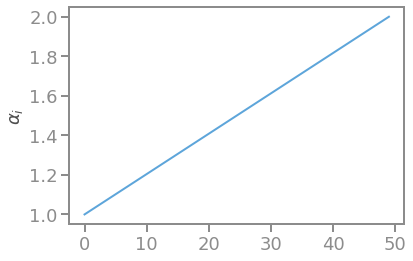

In [3]:
plt.rc('text', usetex=False)
plt.plot(np.linspace(1., 2))
plt.ylabel(r'$\alpha_i$')

## Analyis helps

In [4]:
class DefaultDamage:
    def __init__(self, state, matpar, name = "Default damage model: atk aka JJK aka LS", slug = "atk"):
        self.state = state
        self.matpar = matpar
        self.str = name
        self.slug = slug

    def _a(self, Œ±):
        _Œ± = self.state[Œ±]
        # _Œ± = Œ±
        # _E0 = self.matpar[E0]
        _k = self.matpar[k]

        return (1 - Œ±) / ((_k-1) * Œ± + 1)

    def _w(self, _Œ±):
        # _Œ± = Œ±
        # _w1 = self.matpar[w1]

        return self.matpar[w1] * _Œ±

    def energy(self, state):
        """Total energy"""
        return self._elastic(state) + self._damage(state) - self.work(state)

    def work(self, state):
        return 0

    def _elastic(self, state):
        _E0 = self.matpar[E0]
        _u = state[u]
        _Œ± = state[Œ±]

        return 1./2. * _E0 * self._a(_Œ±) * sp.diff(_u, x)**2 

    def _damage(self, state):
        _Œ± = state[Œ±]
        matpar = self.matpar
        _w1 = matpar[w1]
        _ùìÅ = matpar[ùìÅ]

        return _w1 * (self._w(_Œ±) + matpar[ùìÅ]**2 * (sp.diff(_Œ±, x))**2 )


    def __str__(self):
     return self.str


class DamageATJJ(DefaultDamage):
    """docstring for Model"""
    def __init__(self, state, matpar, name = "ATJJ Damage Model, JJ & Seb Neukirch", slug = "atjj"):
        super(DamageATJJ, self).__init__(state, matpar, name = name, slug = slug)

    def _a(self, Œ±):
        # _Œ± = self.state[Œ±]
        w = self._w(Œ±)
        # _Œ± = Œ±
        # _E0 = self.matpar[E0]
        _k = self.matpar[k]

        return (1 - w) / (1 + (_k-1) * w)

    def _w(self, _Œ±):
        _w1 = matpar[w1]

        return 1-(1.-_Œ±)**2


class DamageATn(DefaultDamage):
    """docstring for Model"""
    def __init__(self, state, matpar, slug, name = "ATn Damage Model"):
        super(DamageATn, self).__init__(state, matpar, name = name, slug = slug)

    def _a(self, Œ±):
        return (1 - Œ±)**2

    def _w(self, _Œ±):
        _Œ± = Œ±
        _n = self.matpar[n]
        return _Œ±**_n


class DamagePQ(DefaultDamage):
    """Particularly interesting model, as per marigo-2012"""
    def __init__(self, state, matpar = None, slug = "pq", name = "PQ Damage Model"):
        if matpar == {}:
            p, q, E0, L, w1, ùìÅ, œÉc = sp.symbols('p q E0 L w1 ùìÅ œÉ_c')
            matpar = {p: p, q: q, E0: E0, w1: w1, ùìÅ: ùìÅ, L: L, œÉc: œÉc}

        self.matpar = matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, matpar, name = name, slug = slug)

    def _a(self, Œ±):
        _q = self.matpar[q]
        _p = self.matpar[p]

        return (1 - Œ±)**_q / (1 + Œ±)**_p  

    def _w(self, _Œ±):
        print(self.matpar)
        _Œ± = Œ±
        _q = self.matpar[q]
        _p = self.matpar[p]
        _œÉc = self.matpar[œÉ_c]
        _E0 = self.matpar[E0]

        return (_p+_q) * _Œ± * _œÉc**2 / _E0


class DamagePQ2(DefaultDamage):
    """Particularly interesting other model, as per marigo-2012, 
        Requires: q > p > 0
    """
    def __init__(self, state, matpar = {}, slug = "pq2", name = "PQ Damage Model"):
        if matpar == {}:
            p, q, E0, L, w1, ùìÅ, œÉc = sp.symbols('p q E0 L w1 ùìÅ œÉ_c')
            _matpar = {p: p, q: q, E0: E0, w1: w1, ùìÅ: ùìÅ, L: L, œÉc: œÉc}
            self._matpar = _matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, _matpar, name = "PQ Damage Model", slug = slug)

    def _a(self, Œ±):
        _q = self._matpar[q]
        _p = self._matpar[p]

        return (1 - Œ±)**_q 

    def _w(self, _Œ±):
        
        _Œ± = Œ±
        _q = self._matpar[q]
        _p = self._matpar[p]
        _œÉc = self._matpar[œÉ_c]
        _E0 = self._matpar[E0]

        return _q * _œÉc**2 / (2.* _p * _E0)  * (1.-(1.-_Œ±)**_p)


class PerfectBrittle(DefaultDamage):
    """Perfectly brittle model, as per marigo-2012, 
        w'/E' is constant
    """
    def __init__(self, state, matpar = {}, name = "PQ Damage Model", slug = "pq3"):
        if matpar == {}:
            p, q, E0, L, w1, ùìÅ, œÉc = sp.symbols('p q E0 L w1 ùìÅ œÉ_c')
            _matpar = {p: p, q: q, E0: E0, w1: w1, ùìÅ: ùìÅ, L: L, œÉc: œÉc}
            self._matpar = _matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, _matpar, name = "PQ Damage Model", slug = "pq3")

    def _a(self, Œ±):
        _q = self._matpar[q]
        _p = self._matpar[p]

        # return (1 - Œ±)**_q 
        # return ?

    def _w(self, _Œ±):
        
        _Œ± = Œ±
        _œÉc = self._matpar[œÉc]
        _E0 = self._matpar[E0]
        _ec = _œÉc / _E0

        return _E0 * (1 - self._a) * _ec**2 /2.


In [5]:
## Simple Analytic 

E0, L, w1, ùìÅ, œÉc = sp.symbols('E0 L w1 ùìÅ œÉ_c')
k = sp.symbols('k', integer = True)

x, t = sp.symbols('x t')

Œ± = sp.Function('Œ±')(x)
u = sp.Function('u')(x)

_œÉ = sp.symbols('œÉ')
_Œ≤ = sp.symbols('Œ≤')
_Œ±0 = sp.symbols('Œ±0')
_Œ≥ = sp.symbols('Œ≥')

_times = np.linspace(0., 3.)
_damage = np.linspace(0., 1.)

state = {u: u, Œ±: Œ±}

# sp.diff(atk.elastic(state), Œ±).subs({u: _u0}).simplify()



### Analysis demands derivatives
<!-- u = tx -->
<!-- alpha = 0 -->

In [6]:
class ModelAnalysis:
    """Helper class to analyse stability properties of a model"""

    def __init__(self, model):
        self.model = model
        self.state = model.state
        _state = self.state
        self.matpar = model.matpar

        self._s = 1/self.model._a(_state[Œ±])
        self._sp = sp.diff(self._s, _state[Œ±], 1)
        self._spp = sp.diff(self._s, _state[Œ±], 2)

        self._a = self.model._a(_state[Œ±])
        self._ap = sp.diff(self._a, _state[Œ±], 1)
        self._app = sp.diff(self._a, _state[Œ±], 2)

        self._w = self.model._w(_state[Œ±])
        self._wp = sp.diff(self._w, _state[Œ±])
        self._wpp = sp.diff(self._w, _state[Œ±], 2)
        self.criterion()

    def _print_model_functions(self, matpar = {}):
        if matpar == {}:
            _fname = f"model-{self.model.slug}.txt"
        else: 
            _fname = f"model-{self.model.slug}-matpar.txt"
        print(f"Output in {_fname}")

        sp.latex(self._a)
        sp.latex(self._ap)
        sp.latex(self._app)
        sp.latex(self._s)
        sp.latex(self._sp)
        sp.latex(self._spp)
        
        _fcs = [self._a.subs(matpar), 
            self._ap.subs(matpar), 
            self._app.subs(matpar), 
            self._s.subs(matpar), 
            self._sp.subs(matpar), 
            self._spp.subs(matpar)]
        _lab = ["a", "aprime", "apprime", "s", "sprime", "spprime"]
        _known = ["a(\\alpha)=", "a'(\\alpha)=", "a''(\\alpha)=", 
                "s(\\alpha)=", "s'(\\alpha)=", "s''(\\alpha)="]

        out_file = open(_fname,"w")
        
        for y in zip(_fcs, _lab, _known):
            _tex = y[2] + str(sp.latex(y[0])).replace("Œ±", "\\alpha")
            out_file.write("\\begin{equation}")
            out_file.write(f"\\label{{ eqn:{self.model.slug}-{y[1]} }}")
            out_file.write(_tex)
            out_file.write("\\end{equation}")
            out_file.write("\n")

        out_file.close()

        _œÉ = sp.symbols('œÉ')
        _Œ≤ = sp.symbols('Œ≤')
        _Œ±0 = sp.symbols('Œ±0')
        _Œ≥ = sp.symbols('Œ≥')
        _E0 = self.model.matpar[E0]

        _fch = self._H_damage_profile()

        fc0 = self.criterion()
        fc1 = self.critical_load(matpar)
        fc3 = _fch.subs(matpar).subs({_Œ≤: -_Œ≥/_Œ±0+1})
        fc4 = (1/sp.sqrt(
                _fch.subs(matpar))
                ).simplify()
        fc5 = ((self._s - 1/E0).subs(Œ±, _Œ≤)/sp.sqrt(_fch))    \
            .subs(matpar)                                              \
            .simplify()

        fc6 = (((self._s - 1/E0).subs(Œ±, _Œ≤)/sp.sqrt(_fch)))    \
            .subs(matpar).subs({_Œ≤: -_Œ≥/_Œ±0+1})                \
            # .simplify()
        
        fc7 = _fch.subs(matpar).subs({_Œ≤: -_Œ≥/_Œ±0+1})
        fc7_Œ≥ = sp.diff(fc7, _Œ≥).subs({_Œ≥: 1}).simplify()
        # HœÉŒ≥_Œ≥.simplify()
        fc6_Œ≥ = sp.diff(fc6, _Œ≥).subs({_Œ≥: 1}).subs(matpar).simplify()

        _fcs = [fc0, fc1, _fch, 
                # fc2, 
                fc3, fc4, fc5, fc6, fc7, fc7_Œ≥, fc6_Œ≥]
        _lab = ["crit", "crit_load", "Hsigmabeta", 
                # "Hsigmagamma", 
                "Hsigmabeta_mat", "one_over_H",
                "eps_integrand", 
                "eps_integrand_gamma", 
                "deriv_integrand_gamma", 
                "deriv_integrand_gamma_one", 
                "deriv_integrand_gamma_one", 
                ]
        _known = ["0=", "t_c=", 
                "H(\\sigma, \\beta)=", 
                # "H(\\sigma, \\beta)=",
                "H(\\sigma, \\gamma)=",
                "1/\\sqrt{H(\\sigma, \\beta)}=",
                "(S(\\beta)-S_0)/\\sqrt{H(\\sigma, \\beta)}=",
                "(S(\\gamma)-S_0)/\\sqrt{H(\\sigma, \\gamma)}=",
                "\\frac{\\partial H}{\\partial \\gamma}=",
                "\\frac{\\partial H}{\\partial \\gamma}|_{\\gamma=1}=",
                "\\frac{\\partial 1/\\sqrt{H}}{\\partial \\gamma}|_{\\gamma=1}="
                ]

        out_file = open(_fname,"a")
        out_file.write("\n")
        
        for y in zip(_fcs, _lab, _known):
            print(y[2])
            _tex = y[2] + str(sp.latex(y[0])).replace("Œ±", "\\alpha") \
                                    .replace("œÉ", "\\sigma")    \
                                    .replace("Œ≤", "\\beta")    \
                                    .replace("Œ≥", "\\gamma")    
            out_file.write("\\begin{equation}")
            out_file.write(f"\\label{{ eqn:{self.model.slug}-{y[1]} }}")
            out_file.write(_tex)
            out_file.write("\\end{equation}")
            out_file.write("\n")

        out_file.close()

    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state

        _u0 = t*x/L
        _alpha0 = 0

        _crit = sp.diff(model.energy(state), Œ±) \
            .subs({u: _u0, Œ±: _alpha0})         \
            .simplify()
        # .subs(matpar).simplify()
        # _ts = np.array(sp.solve(_crit, t))
        # return np.where(_ts > 0)
        self.crit = _crit

        return _crit

    def critical_load(self, matpar = {}):
        ans = sp.solve(self.crit, t)
        _ = [t.subs(matpar) for t in ans]
        positive = np.where(np.array(_) >= 0)[0][0]
        # pdx
        self._critical_load = ans[positive]
        return ans[positive]

    def critical_load_N(self, _matpar={}):
        return np.float64(self._critical_load.subs(_matpar))

    def _homogeneous_energy(self, _matpar):
        state, (_uf, _af) = self._homogeneous_state(_matpar)

        _u = state[0]
        _alpha = state[1]

        return

    def set_critical_load(self, _critical_load):
        """If needed, set the critical load explicitly and manually"""
        self._critical_load = _critical_load

    def _check_constitutive(self):
        _a = 1
        # a -> E(a) decreasing
        # a -> w(a) increasing
        # a -> -w'/E' increasing
        # a -> -w'/s' decreasing
        return

    def _homogeneous_alpha(self, matpar = None):
        _u0 = t*x/L

        if matpar is not None:
            _matpar = matpar
        else:
            _matpar = self.matpar

        try:
            _eq = sp.diff(self.model.energy(state), Œ±) \
                .subs({u: _u0, Œ±: Œ±})         \
                .simplify()

            _ah = sp.solve(_eq, Œ±)

        # except NotImplementedError as e:
        except:
            _eq = sp.diff(ana.model.energy(state), Œ±)   \
                .subs({u: _u0, Œ±: Œ±})                   \
                .subs(_matpar)                   \
                .simplify()

            _ah = sp.solve(_eq, Œ±)

        return _ah
    
    def _homogeneous_state(self, _matpar={}, ah=None):
        if ah is None:
            # Good luck with the first solution
            _ah = self._homogeneous_alpha()[0]
        else:
            _ah = ah
        try:
            _tc = self.critical_load_N(_matpar)
        except:
            _tc = self._critical_load

        x, t = sp.symbols('x t')
        print(_tc)
        _homogeneous_alpha = sp.Piecewise((_ah, t >= _tc), (0, t < _tc))
        _homogeneous_u = t * x / L

        _uf = sp.lambdify((t, x), _homogeneous_u.subs(_matpar), "numpy")
        _af = sp.lambdify(t, _homogeneous_alpha.subs(_matpar), "numpy")

        state = {u: _homogeneous_u, Œ±: _homogeneous_alpha}

        return state, (_uf, _af)

    def _set_homogeneous_alpha(self, ah):
        self._alpha_h = ah

        return

    def plot_homogeneous_alpha(self, _matpar={}):
        ah = self._homogeneous_alpha()
        _tc = self.critical_load_N(_matpar)

        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the zero range
        subcritical_times = np.linspace(0., _tc)
        axis.plot(subcritical_times, [0 for t in subcritical_times], c="C0")

        supercritical_times = np.linspace(_tc, 3)

        for _a in ah:
            _af = sp.lambdify(t, _a.subs(_matpar), "numpy")

            axis.plot(supercritical_times, [_af(t)
                      for t in supercritical_times], c="C0")
            # plt.plot()

        axis.set_xlim(0, 3)
        axis.set_ylim(0, 1)

        plt.axvline(_tc, c='k')
        plt.axhline(1, c='k')

        return fig, axis

    def plot_homogeneous_stress(self, _matpar={}, ah=None):
        ah = self._homogeneous_alpha()
        # _tc = self.critical_load_N(_matpar)
        try:
            _tc = self.critical_load_N(_matpar)
        except:
            _tc = self._critical_load
        print(f"_tc {_tc}")
        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the zero range
        times = np.linspace(0, 3, 30)

        _sf = sp.lambdify(t, self._stress(ah=ah).subs(_matpar), "numpy")

        # axis.plot(np.linspace(0, 3), [_sf(t) for t in times], c="C0")
        axis.plot(_times, [_sf(t) for t in _times], c="C0")

        plt.axvline(_tc, c='k')
        plt.axhline(1, c='k')

        axis.set_xlim(0, 3)
        axis.set_ylim(0, 1)

        return fig, axis

    def plot_homogeneous_energies(self, _matpar):

        _homog_state, (_uf, _af) = self._homogeneous_state(_matpar)

        _en_h = sp.lambdify(t, at1.energy(_homog_state).subs(
            {Œ±: _homog_state[1]}).subs(_matpar), "numpy")
        _en_dam_h = sp.lambdify(t, at1._damage(_homog_state).subs(
            {Œ±: _homog_state[1]}).subs(_matpar), "numpy")
        _en_ela_h = sp.lambdify(t, at1._elastic(_homog_state).subs(
            {Œ±: _homog_state[1]}).subs(_matpar), "numpy")
        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        plt.plot(np.linspace(0., 3.), [_en_h(t)
                 for t in np.linspace(0., 3.)], c="C0")
        plt.plot(np.linspace(0., 3.), [_en_dam_h(t)
                 for t in np.linspace(0., 3.)], c="C1")
        plt.plot(np.linspace(0., 3.), [_en_ela_h(t)
                 for t in np.linspace(0., 3.)], c="C2")

        return fig, axis

    def plot_material(self, _matpar):
        _damage = np.linspace(0., 1.)

        _wf = sp.lambdify(Œ±, self._w.simplify().subs(_matpar), "numpy")
        _af = sp.lambdify(Œ±, self._a.simplify().subs(_matpar), "numpy")
        _apf = sp.lambdify(Œ±, self._ap.simplify().subs(_matpar), "numpy")
        _appf = sp.lambdify(Œ±, self._app.simplify().subs(_matpar), "numpy")

        # _apf = sp.lambdify(t, ana.)ap.subs(_matpar), "numpy")
        # _apf

        figure, axis = plt.subplots(1, 2, figsize=(8, 6))
        _ax = axis[0]
        _ax.axhline(0, c='k')
        _ax.plot(_damage, [_af(Œ±) for Œ± in _damage], label="a")
        _ax.legend(loc=2)
        _ax.plot(_damage, [_apf(Œ±) for Œ± in _damage], label="a'", c='r')
        _ax.plot(_damage, [_appf(Œ±) for Œ± in _damage], label="a''")
        # _ax2 = _ax.twiny()
        left, bottom, width, height = [0.25, 0.5, 0.2, 0.2]
        _ax2 = figure.add_axes([left, bottom, width, height])

        _ax2.plot(_damage, [_wf(Œ±) for Œ± in _damage], label="w", c='k', ls='dashed')

        _ax.set_xlim(0, 1)
        _ax2.set_xlim(0, 1)
        # _ax2.set_ylim(0, 1)
        _ax.legend()
        _ax2.legend(loc=3)

        _sf = sp.lambdify(Œ±, self._s.simplify().subs(_matpar), "numpy")
        _spf = sp.lambdify(Œ±, self._sp.simplify().subs(_matpar), "numpy")
        _sppf = sp.lambdify(Œ±, self._spp.simplify().subs(_matpar), "numpy")

        _ax = axis[1]

        _ax.plot(_damage, [_sf(Œ±) for Œ± in _damage], label="s")
        _ax.legend(loc=2)
        _ax.axhline(0, c='k')
        _ax.twinx()
        _ax.plot(_damage, [_spf(Œ±) for Œ± in _damage], label="s'")
        _ax.plot(_damage, [_sppf(Œ±) for Œ± in _damage], label="s''")
        _ax.set_xlim(0, 1)
        _ax.set_ylim(0, 10)
        _ax.legend(loc=1)
        figure.suptitle(f"Behaviour of {self.model.__str__()} is Material")

        return figure, axis

    def _hypotheses1(self):
        """As per marigo-2012, HP1: w'/S' decreasing wrt alpha"""

        _hp1 = self._sp / self._wp
        return _hp1

    def _H_damage_profile(self):
        """A function of sigma and beta constructs localisation profiles"""
        _œÉ = sp.symbols('œÉ')
        _Œ≤ = sp.symbols('Œ≤')

        _Hf = 1/E0*(2*self._w - _œÉ**2 * (self._s - 1/E0)).subs({Œ±: _Œ≤})

        return _Hf

    def max_Œ±(self, matpar = {}):
        """Maximum value of alpha as a function of sigma, returns 
        real solutions and the index of admissible solutions in [0, 1]"""
        _Œ≤ = sp.symbols('Œ≤')
        _œÉ = sp.symbols('œÉ')
            
        sol = sp.solve(self._H_damage_profile().subs(matpar), _Œ≤)

        # simple tet
        arr = np.array([a.subs({_œÉ: .9}) for a in sol])
        real_filter = [sp.N(a).is_real for a in arr]
        sol = np.compress(real_filter, sol)
        r_arr = np.array([a.subs({_œÉ: .9}) for a in sol])
        idx = np.argwhere((r_arr > 0) & (r_arr < 1)).flatten()[0]

        return sol, idx

    def _Œ±_max(self, œÉ, matpar = None):
        _Œ≤ = sp.symbols('Œ≤')
        _œÉ = sp.symbols('œÉ')
        # _matpar = self.matpar
        _HœÉŒ≤ = self._H_damage_profile().subs(matpar)

        _HŒ≤ = _HœÉŒ≤.subs({_œÉ: œÉ})
        _sol = sp.solve(_HŒ≤, _Œ≤, (0, 1), solver='bisect')
        # print(_sol)
        Œ±max = np.float64(_sol[1][0])

        return Œ±max

    def _integrate_Hminusonehalf(self, œÉv, H):
        _œÉ = sp.symbols('œÉ')
        _fv = sp.lambdify(_Œ≥, ((H.subs({_œÉ: œÉv}))**(-1/2)), "numpy")
        return _integ.quad(_fv, 0, 1)

    def _integrate_Dsigma(self, œÉv, H = None, matpar = {}):
        _œÉ = sp.symbols('œÉ')
        sol, idx = self.max_Œ±(matpar)

        if H is not None:
            _bar_H = H.subs(matpar)
        else:    
            _bar_H = self._H_damage_profile().subs(matpar)    \
                .subs({_Œ≤: _Œ≥*_Œ±0})                 \
                .subs({_Œ±0: sol[idx]}).simplify()
            
        _f = ((_bar_H)**(-1/2)*sol[idx]).subs({_œÉ: œÉv})
        _fv = sp.lambdify(_Œ≥, _f, "numpy")
        return _integ.quad(_fv, 0, 1)

    def _integrate_epsilon_localised(self, œÉv, H = None, matpar = {}):
        _œÉ = sp.symbols('œÉ')
        sol, idx = self.max_Œ±(matpar)

        if H is not None:
            _bar_H = H.subs(matpar)
        else:    
            _bar_H = self._H_damage_profile().subs(matpar)    \
                .subs({_Œ≤: _Œ≥*_Œ±0})                         \
                .subs({_Œ±0: sol[idx]}).simplify()
        
        _prefact = (self._s - 1/E0).subs(matpar)            \
                .subs({_Œ±: _Œ≥*_Œ±0})                         \
                .subs({_Œ±0: sol[idx]}).simplify()
        
        _f = (2*_prefact*(_bar_H)**(-1/2)*sol[idx]).subs({_œÉ: œÉv})
        _fv = sp.lambdify(_Œ≥, _f, "numpy")
        return _integ.quad(_fv, 0, 1)

    def _stress(self, ah=None):
        _homog_state, (_uf, _af) = self._homogeneous_state(_matpar, ah=ah)

        _ah = _homog_state[Œ±]

        _tc = self.critical_load_N(_matpar)

        stress_alpha = sp.Piecewise(
            (sp.sqrt(2 * self._wp / self._sp).subs({Œ±: _ah}), t >= _tc),
            # sigma = E(alpha=0) u'
            (sp.diff(_homog_state[u], x).subs(_matpar), t < _tc))

        # return sp.sqrt( 2* self._wp / self._sp).subs({Œ±: _ah})
        return stress_alpha

    def _DœÉ(self, œÉ):
        """Half length of the localisation as a function of œÉ"""
        _Œ±h = self._homogeneous_alpha()
        _Œ≥ = sp.symbols('Œ≥')
        _Œ±max = self._Œ±_max(œÉ)

        _E0 = self.model._matpar[E0]
        _ùìÅ = self.model._matpar[ùìÅ]

        _f = 1/self._H_damage_profile()

        _DœÉ = _ùìÅ * sp.integrate(_f, (_Œ≤, 0, _Œ±max))

    def D0(self, matpar):
        """Half length of the localisation as a function of œÉ, (in the limit) sigma = 0"""
        _Œ≥ = sp.symbols('Œ≥')
        _i = (((2*self._w)/E0)**(-1/2)).subs({Œ±: _Œ≥}).subs(matpar) 
        _fv = sp.lambdify(_Œ≥, _i, "numpy")

        return _integ.quad(_fv, 0, 1)

    def _œÉc(self, matpar):
        return sp.sqrt(2*self._wp/self._sp).subs(matpar).subs({Œ±: 0})

    def _Dc(self, matpar):
        """Half length of the localisation at the onset"""

        _sigma0 = self._œÉc(matpar)
        _D = np.pi * \
            sp.sqrt(2 * E0 / (_sigma0**2 * self._spp - 2.*self._wpp)) \
                .subs({Œ±: 0}).subs(matpar)

        return _D
    
    def localised_deformation(self, matpar):

        sol, idx = self.max_Œ±(matpar)

        _H_subs = self._H_damage_profile().subs(matpar)    \
                .subs({_Œ≤: _Œ≥*_Œ±0})                             \
                .subs({_Œ±0: sol[idx]}).simplify()

        _integrand = 2*((self._s - 1/E0)*_H_subs**(-1/2))         \
                .subs({Œ±: _Œ≥*_Œ±0})                             \
                .subs(matpar)                              \
                .subs({_Œ±0: sol[idx]}).simplify()
        
        _fv = sp.lambdify(_Œ≥, (_integrand.subs({_œÉ: œÉv})), "numpy")
        
        return _integ.quad(_fv, 0, 1)

    def snap_back(self, matpar):
        _Œ± = self.model.state[Œ±]
        _E0 = self.model.matpar[E0]
        _w1 = self.model.matpar[w1]
        S0 =  1 / _E0
        _œÉc = sp.sqrt( 2* self.model.matpar[w1]*self._wp / (S0*self._sp) ).subs({Œ±: 0})
        _sp = self._sp
        _w = self._w

    def _eps_1_d(self, œÉv, matpar, tol = 1e-3):
        # _Œ≤ = sp.symbols('Œ≤')
        # _Œ±_max = self._Œ±_max(œÉv, matpar)
        # _f = (self._s - 1/E0).subs(Œ±, _Œ≤)/sp.sqrt(self._H_damage_profile())    \
        #     .subs(matpar)                                                   \
        #     .subs({_œÉ: œÉv})                                                   \
        #     .simplify()

        # __fv = sp.lambdify(_Œ≤, f.subs(matpar), "numpy")
        # _tol = 0.001
        _betas = np.linspace(_tol, _Œ±_max - tol, 30)
        _f, _Œ±_max, __fv = self._eps_1_d_integrand(œÉv, matpar)
        eps = np.trapz([__fv(b) for b in _betas], _betas)

        return eps, (_f, _Œ±_max)

    def _eps_1_d_integrand(self, œÉv, matpar):
        _Œ≤ = sp.symbols('Œ≤')
        _Œ±_max = self._Œ±_max(œÉv, matpar)

        _f = ((self._s - 1/E0).subs(Œ±, _Œ≤)/sp.sqrt(self._H_damage_profile()))    \
            .subs(matpar)                                                       \
            .subs({_œÉ: œÉv})                                                   \
            .simplify()

        __fv = sp.lambdify(_Œ≤, _f.subs(matpar), "numpy")

        return _f, _Œ±_max, __fv




        return - ((np.pi * 2**(5/2) * (S0 * _sp)**2 * _œÉc**2 * _E0**1/2) /
                  (S0*self._spp * _œÉc**2 - 2. * _w1 * self._wpp) ** (3/2))       \
                    .subs({Œ±: 0}).subs(matpar)

    # check: dependence of localisation zone wrt stress
    # check: global maccro response

    def _plot_H_Hminusonehalf_alphamax(self, matpar):
        figure, axis = plt.subplots(1, 2, figsize=(10, 6))
        figure.tight_layout()
        # figure.subplots_adjust(left  = 0.125, 
        #     right = 1  ,  
        #     bottom = 0.1 ,  
        #     top = 1    ,  
        #     wspace = .9 ,  
        #     hspace = 0.2 
        #     )

        _tol = 1e-4

        sol, idx = self.max_Œ±(matpar)

        _bar_H = self._H_damage_profile().subs(matpar)    \
            .subs({_Œ≤: _Œ≥*_Œ±0})                 \
            .subs({_Œ±0: sol[idx]})

        _bar_H
        ax2 = axis[0].twinx()

        for œÉv in np.linspace(.99, .01, 10):
            _fv = sp.lambdify(_Œ≥, (_bar_H.subs({_œÉ: œÉv})), "numpy")
            axis[0].plot(_damage, [_fv(b) for b in _damage], label = f"$\sigma/\sigma_0$  = {œÉv:.2f}")
            ax2.plot(_damage, [(_fv(b))**(-1/2) for b in _damage], lw=1, c='gray')

        # ax2.set_yticks([])
        ax2.set_ylim(0, 10)

        # , marker = 'o'
        axis[0].set_xlabel("$\\beta/\\bar \\alpha$")
        axis[0].legend()

        amax = []
        for i in np.linspace(.999, .01, 10):
            amax.append(self._Œ±_max(i, _matpar))


        axis[1].plot(amax, np.linspace(1, .0, 10), marker='o')
        axis[1].set_xlabel('$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\, \\sigma$')
        axis[1].set_ylabel('$\\sigma/\\sigma_0$')
        axis[1].set_xlim(0., 1.)
        # axis[1].set_title(f"{self.model}")

        _fc = sol[idx]
        # sol[idx]
        _fv = sp.lambdify(_œÉ, _fc, "numpy")
        _sigmas = np.linspace(1, .0, 10)
        axis[1].plot([_fv(s) for s in _sigmas], _sigmas, label = "analytic")

        axis[1].legend()
        figure.suptitle(f"{self.model}")

        return figure, axis



## ATJJ

In [7]:
state = {u: u, Œ±: Œ±}
_matpar = {k: 2, E0: 1, w1: 1, ùìÅ:0.4, L: 1}
matpar = {k: k, E0: E0, w1: w1, ùìÅ:ùìÅ, L: L}
atjj_matpar = _matpar

_u0 = t*x/L
_alpha0 = 0 


œâ = sp.symbols('œâ')


atjj = DamageATJJ(state, matpar)
ana = ModelAnalysis(atjj)

In [216]:
atjj._w(state[Œ±])

1 - (1.0 - Œ±(x))**2

In [217]:
ana._sp.simplify()

-2.0*k/(1.0*Œ±(x)**3 - 3.0*Œ±(x)**2 + 3.0*Œ±(x) - 1.0)

stress = 2 w'/s'

In [218]:
n, d = sp.fraction(ana._sp.simplify())


(2*ana._wp / (n/d.factor())).simplify()

2.0*(Œ±(x) - 1)**4/k

In [219]:
ana._a

(1.0 - Œ±(x))**2/((1 - (1.0 - Œ±(x))**2)*(k - 1) + 1)

tc**2:

In [220]:
(- 2*ana._wp / ana._ap).subs({Œ±: 0}).simplify()

2.0/k

In [221]:
ana._a.subs({Œ±: 0}).simplify()

1.00000000000000

In [222]:
(ana._wp).subs({Œ±: 0}).simplify()

2.00000000000000

In [223]:
ana.criterion()

-1.0*E0*k*t**2/L**2 + 2.0*w1

crit

In [224]:
a_œâ = atjj._a(Œ±).subs({atjj._w(Œ±): œâ}).subs({1- atjj._w(Œ±): 1- œâ})
a_œâ


(1 - œâ)/(œâ*(k - 1) + 1)

In [225]:
ana.critical_load(_matpar)

1.4142135623731*L*sqrt(w1/(E0*k))

In [226]:
ana._w

1 - (1.0 - Œ±(x))**2

<lambdifygenerated-5>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (2 - (1.0 - _Dummy_40)**2)/(_Dummy_40 - 1.0)**2
<lambdifygenerated-6>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return -4.0/(1.0*_Dummy_41**3 - 3.0*_Dummy_41**2 + 3.0*_Dummy_41 - 1.0)
<lambdifygenerated-7>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 12.0/(1.0*_Dummy_42**4 - 4.0*_Dummy_42**3 + 6.0*_Dummy_42**2 - 4.0*_Dummy_42 + 1.0)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


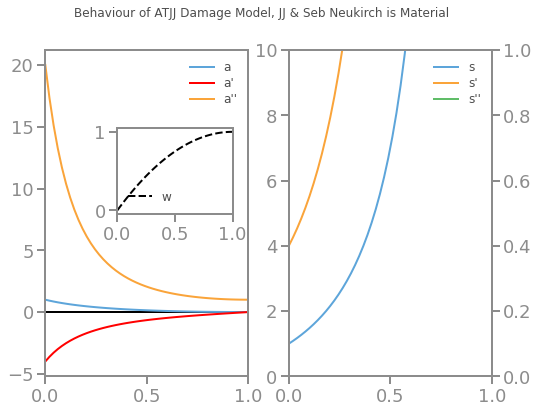

In [19]:
figure, axis = ana.plot_material(_matpar)
# axis[0].set_ylim(-1, 2)
# axis[1].set_ylim(-1, 2)
# axis[0].semilogy()

stress softening if negative

In [20]:
sp.diff(ana._a, Œ±).simplify()

2*k*Œ±(x)/(k*(Œ±(x) - 1.0)**2 - k - (Œ±(x) - 1.0)**2)**2 - 2.0*k/(k*(Œ±(x) - 1.0)**2 - k - (Œ±(x) - 1.0)**2)**2

srain hardening

In [21]:
_matpar

{k: 2, E0: 1, w1: 1, ùìÅ: 0.4, L: 1}

In [22]:
_u0 = t*x/L
_a = sp.symbols('Œ±')
# _eq = sp.diff(ana.model.energy(state), Œ±).subs({u: _u0, Œ±: _a}).simplify().subs(_matpar)
_eq = sp.diff(ana.model.energy(state), Œ±).subs({u: _u0, Œ±: _a}).simplify().subs({E0: 1, w1: 1, ùìÅ: 0.4, L: 1})
_ah = sp.solve(_eq, _a)
_ah[1]

In [ ]:
_tc = np.float32(ana.critical_load(_matpar).subs(_matpar).evalf())
_tc

1.0

1.00000000000000
1.0 - 1.4142135623731*sqrt(1 - 0.5*t)
1.0 - 1.4142135623731*sqrt(0.5*t + 1)
1.4142135623731*sqrt(1 - 0.5*t) + 1.0
1.4142135623731*sqrt(0.5*t + 1) + 1.0


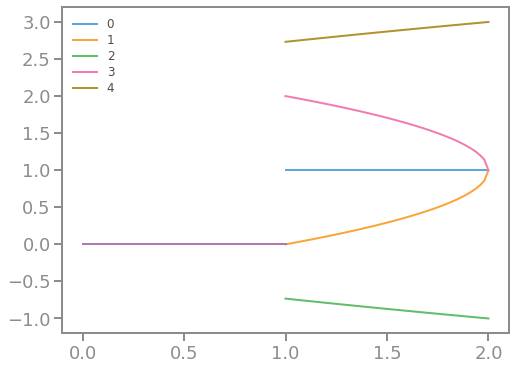

In [360]:

supercritical_times = np.linspace(_tc, _matpar[k])

_af = sp.lambdify(t, _ah[3].subs(_matpar), "numpy")

fig, axis = plt.subplots(1, 1, figsize=(8, 6))

# axis.plot(supercritical_times, [_af(t)
#             for t in supercritical_times], c="C0")

# plt.plot()

for i, _a in enumerate(_ah):
    print(_a.subs(_matpar))
    _af = sp.lambdify(t, _a.subs(_matpar), "numpy")

    axis.plot(supercritical_times, [_af(t)
                for t in supercritical_times], label=i)
    plt.plot()
    plt.legend()

axis.plot(np.linspace(0, _tc), [0
            for t in np.linspace(0, _tc)])


In [234]:
ah = _ah[1]
ah

1.0 - 1.4142135623731*sqrt(1 - 0.5*t)

In [236]:
_u0

t*x/L

In [361]:
def _stress(self, ah=None):
    if ah is None:
        return
    _ah = ah

    _tc = np.float32(self.critical_load(_matpar).subs(_matpar).evalf())
    
    stress_alpha = sp.Piecewise(
        (sp.sqrt(2 * self._wp / self._sp).subs({Œ±: _ah}), t >= _tc),
        (sp.diff(_u0, x).subs(_matpar), t < _tc))

    # return sp.sqrt( 2* self._wp / self._sp).subs({Œ±: _ah})
    return stress_alpha

In [362]:
_stress(ana, ah)

Piecewise((2*sqrt(sqrt(2 - t)/(2*(k - 1)/sqrt(2 - t) + 2*((k - 1)*(t - 1) + 1)/(2 - t)**(3/2))), t >= 1.0), (t, True))

In [363]:
sf = _stress(ana, ah).subs(_matpar)
_f = sp.lambdify(t, sf, "numpy")
sf


Piecewise((2*sqrt(sqrt(2 - t)/(2*t/(2 - t)**(3/2) + 2/sqrt(2 - t))), t >= 1.0), (t, True))

<lambdifygenerated-281>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return select([greater_equal(t, 1.0),True], [2*sqrt(sqrt(2 - t)/(2*t/(2 - t)**(3/2) + 2/sqrt(2 - t))),t], default=nan)


(0.0, 2.0)

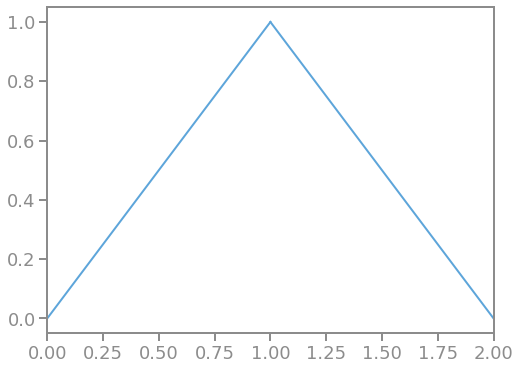

In [364]:

fig, axis = plt.subplots(1, 1, figsize=(8, 6))

supercritical_times  = np.linspace(_tc, _matpar[k])
subcritical_times  = np.linspace(0, _tc)

axis.plot(supercritical_times, [_f(t)
            for t in supercritical_times], c="C0")

axis.plot(subcritical_times, subcritical_times, c="C0")

axis.set_xlim(0, _matpar[k])
# plt.plot()

### rayleigh

In [8]:
# ah

__ah = 1-sp.sqrt(2-t)
ah = __ah

In [10]:
# _stress

_stress = sp.sqrt((2 * (ana._wp / ana._sp).subs({Œ±: ah})).factor()).simplify()

In [11]:
# RAYLEIGH ANALYSIS



state = {u: u, Œ±: Œ±}
_matpar = {k: 2, E0: 1, w1: 1, ùìÅ:0.4, L: 1}
matpar = {k: k, E0: E0, w1: w1, ùìÅ:ùìÅ, L: L}
atjj_matpar = _matpar

_u0 = t*x/L
_alpha0 = 0 

œâ = sp.symbols('œâ')

atjj = DamageATJJ(state, matpar)
ana = ModelAnalysis(atjj)

_u0 = t*x/L
_a = sp.symbols('Œ±')
_eq = sp.diff(ana.model.energy(state), Œ±).subs({u: _u0, Œ±: _a}).simplify().subs(_matpar)
_ah = sp.solve(_eq, _a)
_ah[1]

__ah = 1-sp.sqrt(2-t)
ah = __ah

_B0 = (1/2*ana._spp * _stress - ana._wpp).subs(_matpar).subs({Œ±: ah}).simplify()
_A = (2 * _matpar[ùìÅ]**2 / _B0).subs(_matpar)
_B = (ana._a.subs({Œ±: ah}).simplify() / _B0).subs(_matpar)
_C = - (ana._ap/ana._a).subs(_matpar).subs({Œ±: ah}).simplify().subs(_matpar)




<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in double_scalars
  return 0.32*pi**2/(2 + 6.0*sqrt((t - 2)**2)/(t - 2)**2) - 16/(t**3*(2 + 6.0*sqrt((t - 2)**2)/(t - 2)**2))
<lambdifygenerated-2>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.72354775202551*pi**0.666666666666667*(1/(t*(2 - t)**2))**0.333333333333333
<lambdifygenerated-3>:2: RuntimeWarning: invalid value encountered in double_scalars
  return 16/(t**3*(2 + 6.0*sqrt((t - 2)**2)/(t - 2)**2))
<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in double_scalars
  return 4.34306818655185*pi**0.666666666666667*(1/(t**3*(2 + 6.0*sqrt((t - 2)**2)/(t - 2)**2)))**0.666666666666667*((2 + 6.0*sqrt((t - 2)**2)/(t - 2)**2)**(-1.0))**0.333333333333333


Text(0.5, 0.98, 'Linear-softening $\\ell$=0.4')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


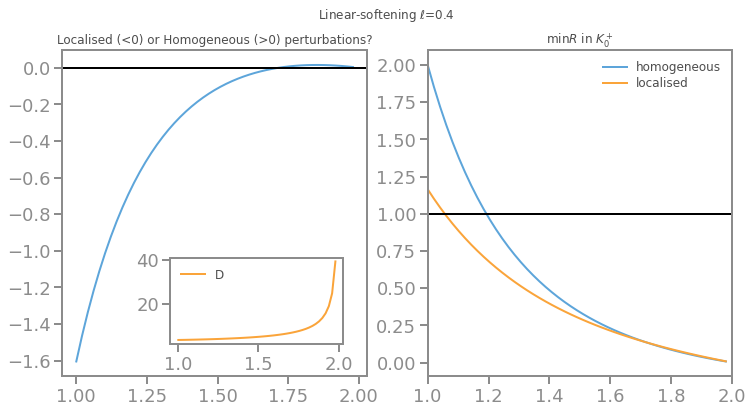

In [12]:
fig, axis = plt.subplots(1, 2, figsize=(12, 6))
_tc = np.float32(ana.critical_load(_matpar).subs(_matpar).evalf())

supercritical_times  = np.linspace(_tc, _matpar[k])

_loc_crit = sp.pi**2*_A -_B*_C**2
_f = sp.lambdify(t, _loc_crit, "numpy")

axis[0].plot(supercritical_times, [_f(t)
            for t in supercritical_times], c="C0")
axis[0].axhline(0, c='k')

# _ax = axis[0].twinx()

left, bottom, width, height = [0.25, 0.2, 0.2, 0.2]
_ax = fig.add_axes([left, bottom, width, height])


_supp = (sp.pi**2*_A / _B*_C**2)**(1/3)
_f = sp.lambdify(t, _supp, "numpy")
_ax.plot(supercritical_times, [_f(t)
            for t in supercritical_times], c="C1", label = "D")
# _ax.set_ylim(0, 3)

_ax.legend()
_Rhomog = _B*_C**2
_f = sp.lambdify(t, _Rhomog, "numpy")
axis[1].plot(supercritical_times, [_f(t)
            for t in supercritical_times], c="C0", label="homogeneous")

_Rloc = (sp.pi**2*_A)**(1/3)*(_B*_C**2)**(2/3)
_f = sp.lambdify(t, _Rloc, "numpy")
axis[1].plot(supercritical_times, [_f(t)
            for t in supercritical_times], c="C1", label="localised")

axis[1].legend()
axis[1].axhline(1, c='k')
axis[1].set_xlim(1, _matpar[k])
# plt.plot()
axis[0].set_title('Localised (<0) or Homogeneous (>0) perturbations?')
axis[1].set_title('$\min R$ in $K^+_0$')
# fig.suptitle(f"{ana.model} $\ell$={_matpar[ùìÅ]}")
fig.suptitle(f"Linear-softening $\ell$={_matpar[ùìÅ]}")



<lambdifygenerated-39>:2: RuntimeWarning: invalid value encountered in double_scalars
  return 16/(t**3*(2 + 6.0*sqrt((t - 2)**2)/(t - 2)**2))
<lambdifygenerated-40>:2: RuntimeWarning: invalid value encountered in double_scalars
  return 4.34306818655185*pi**0.666666666666667*(1/(t**3*(2 + 6.0*sqrt((t - 2)**2)/(t - 2)**2)))**0.666666666666667*((2 + 6.0*sqrt((t - 2)**2)/(t - 2)**2)**(-1.0))**0.333333333333333


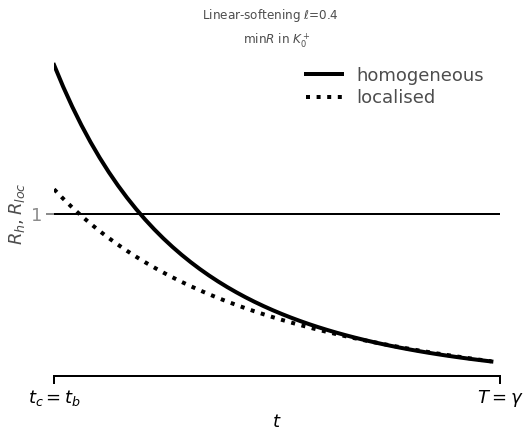

In [37]:
fig, axis = plt.subplots(1, 1, figsize=(8, 6))
_tc = np.float32(ana.critical_load(_matpar).subs(_matpar).evalf())

supercritical_times  = np.linspace(_tc, _matpar[k])
_Rhomog = _B*_C**2
_f = sp.lambdify(t, _Rhomog, "numpy")
axis.plot(supercritical_times, [_f(t)
            for t in supercritical_times], c="k", label="homogeneous", lw=4)

_Rloc = (sp.pi**2*_A)**(1/3)*(_B*_C**2)**(2/3)
_f = sp.lambdify(t, _Rloc, "numpy")
axis.plot(supercritical_times, [_f(t)
            for t in supercritical_times], c="k", ls=':' , label="localised", lw=4)

axis.legend( prop={'size': 18})
axis.axhline(1, c='k')
axis.set_xlim(1, _matpar[k])
# plt.plot()
axis.set_title('$\min R$ in $K^+_0$')
# fig.suptitle(f"{ana.model} $\ell$={_matpar[ùìÅ]}")
fig.suptitle(f"Linear-softening $\ell$={_matpar[ùìÅ]}")
axis.set_xlabel('$t$')
axis.set_ylabel('$R_{h}, R_{loc}$')
axis.set_yticks([1])
axis.set_xticks([1,  _matpar[k]])
axis.set_xticklabels(['$t_c=t_b$', '$T=\gamma $'])
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
# axis.spines['bottom'].set_visible(False)
axis.spines['left'].set_visible(False)



axis.spines['bottom'].set_color('k')
axis.spines['top'].set_color('k')
axis.xaxis.label.set_color('k')
axis.tick_params(axis='x', colors='k')

In [35]:
fig.savefig('Rmin.png', bbox_inches='tight')

## ATk

In [61]:
state = {u: u, Œ±: Œ±}
_matpar = {k: 2, E0: 1, w1: 1, ùìÅ:0.1, L: 1}
matpar = {k: k, E0: E0, w1: w1, ùìÅ:ùìÅ, L: L}
atk_matpar = _matpar

_u0 = t*x/L
_alpha0 = 0 

atk = DefaultDamage(state, matpar)
ana = ModelAnalysis(atk)
_crit = sp.diff(atk.energy(state), Œ±).subs({u: _u0, Œ±: _alpha0}).simplify()
_crit




-0.5*E0*k*t**2/L**2 + 1.0*w1

### First order

In [192]:
sp.diff(ana.model.energy(state), Œ±).subs({u: _u0, Œ±: Œ±}).simplify()

-0.5*E0*k*t**2/(L**2*(k*Œ±(x) - Œ±(x) + 1)**2) + w1

In [193]:
ana.criterion()

-0.5*E0*k*t**2/L**2 + 1.0*w1

In [194]:
ana.critical_load(matpar = _matpar)
# sp.solve(ana.crit, t)

1.4142135623731*L*sqrt(w1/(E0*k))

In [195]:
ana._print_model_functions(_matpar)
# ana._print_model_functions()

Output in model-atk-matpar.txt
0=
t_c=
H(\sigma, \beta)=
H(\sigma, \gamma)=
1/\sqrt{H(\sigma, \beta)}=
(S(\beta)-S_0)/\sqrt{H(\sigma, \beta)}=
(S(\gamma)-S_0)/\sqrt{H(\sigma, \gamma)}=
\frac{\partial H}{\partial \gamma}=
\frac{\partial H}{\partial \gamma}|_{\gamma=1}=
\frac{\partial 1/\sqrt{H}}{\partial \gamma}|_{\gamma=1}=


In [196]:
ana.critical_load_N(_matpar)

1.0

In [197]:
ana.set_critical_load(ana.critical_load(matpar = _matpar))
# ana.set_critical_load(ana.critical_load_N(_matpar))
ana._critical_load

1.4142135623731*L*sqrt(w1/(E0*k))

In [198]:
_ = sp.diff(atk.energy(state), Œ±) \
    .subs({u: _u0, Œ±: Œ±}) \
    .simplify()

In [39]:
_
sp.latex(_)

'- \\frac{0.5 E_{0} k t^{2}}{L^{2} \\left(k Œ±{\\left(x \\right)} - Œ±{\\left(x \\right)} + 1\\right)^{2}} + w_{1}'

In [40]:
ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])

1.4142135623731*L*sqrt(w1/(E0*k))


({u(x): t*x/L,
  Œ±(x): Piecewise(((-L*w1 + 0.707106781186548*t*sqrt(E0*k*w1))/(L*w1*(k - 1.0)), t >= 1.4142135623731*L*sqrt(w1/(E0*k))), (0, True))},
 (<function _lambdifygenerated(t, x)>, <function _lambdifygenerated(t)>))

In [41]:
_eq = sp.diff(atk.energy(state), Œ±) \
    .subs({u: _u0, Œ±: Œ±}) \
    .simplify()

_eq

_ah = sp.solve(_eq, Œ±)

[a.subs(_matpar) for a in _ah]


[-0.707106781186548*sqrt(2)*t - 1.0, 0.707106781186548*sqrt(2)*t - 1.0]

(0.0, 2.0)

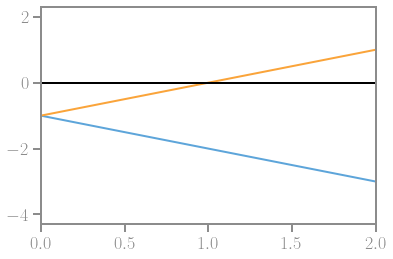

In [42]:
_eq = sp.diff(atk.energy(state), Œ±) \
    .subs({u: _u0, Œ±: Œ±}) \
    .simplify()

_ah = sp.solve(_eq, Œ±)


_ah_f = [sp.lambdify(t, a.subs(_matpar), "numpy") for a in _ah]

# _ahp = sp.lambdify(t, _ah_sub[0].subs(_matpar), "numpy")

_times = np.linspace(0., 3)

for _a in _ah_f:
    plt.plot(_times, [_a(t) for t in _times])

plt.axhline(0, c='k')
plt.xlim(0, _matpar[k])
# plt.plot()

### Check if multiple solutions

In [96]:
_state, (_uf, _af) = ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])

1.4142135623731*L*sqrt(w1/(E0*k))


In [97]:
_state

{u(x): t*x/L,
 Œ±(x): Piecewise(((-L*w1 + 0.707106781186548*t*sqrt(E0*k*w1))/(L*w1*(k - 1.0)), t >= 1.4142135623731*L*sqrt(w1/(E0*k))), (0, True))}

In [98]:
_ = _state[Œ±]

In [99]:
_a = _state[Œ±]

_ah_f = sp.lambdify(t, _a.subs(_matpar), "numpy")
_ah_f(0)

array(0.)

In [50]:
ana.critical_load_N(_matpar)

1.0

Text(0.5, 1.0, 'Default damage model: atk aka JJK aka LS')

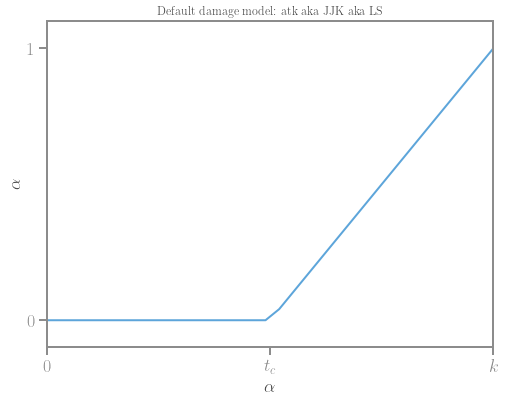

In [52]:
fig, axis = plt.subplots(1, 1, figsize=(8, 6))

axis.plot(_times, [_ah_f(t) for t in _times])
tc = ana.critical_load_N(_matpar)

# axis.axhline(0, c='k')
axis.set_xlim(0, _matpar[k])
axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, tc, _matpar[k]], ["0", "$t_c$", "$k$"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$\\alpha$")
axis.set_ylabel("$\\alpha$")
axis.set_title(f"{ana.model}")


In [ ]:
fig.tight_layout()
fig.savefig("../../notes/figures/atk-alpha-homog.pdf")

In [56]:
state

{u(x): u(x), Œ±(x): Œ±(x)}

In [58]:
atk.energy(_homog_state)

NameError: name '_homog_state' is not defined

### Material

<lambdifygenerated-17>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (-_Dummy_353 - 1)/(_Dummy_353 - 1)
<lambdifygenerated-18>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2/(_Dummy_354**2 - 2*_Dummy_354 + 1)
<lambdifygenerated-19>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return -4/(_Dummy_355**3 - 3*_Dummy_355**2 + 3*_Dummy_355 - 1)


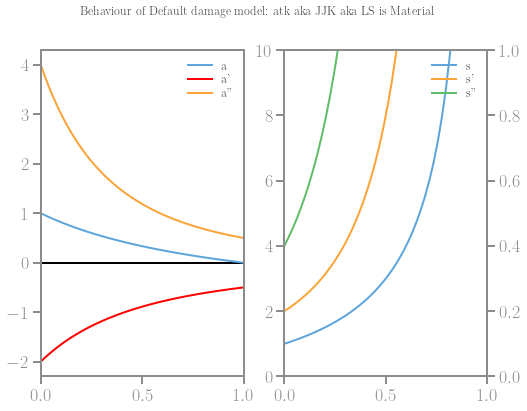

In [59]:
figure, axis = ana.plot_material(_matpar)
# axis[0].set_ylim(-1, 2)
# axis[1].set_ylim(-1, 2)


In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/atk-model.pdf")

In [60]:
# Localised branches
ana._s, ana._sp.simplify(), ana._spp.simplify()

(((k - 1)*Œ±(x) + 1)/(1 - Œ±(x)),
 k/(Œ±(x)**2 - 2*Œ±(x) + 1),
 -2*k/(Œ±(x)**3 - 3*Œ±(x)**2 + 3*Œ±(x) - 1))

1.0


(0.0, 100.0)

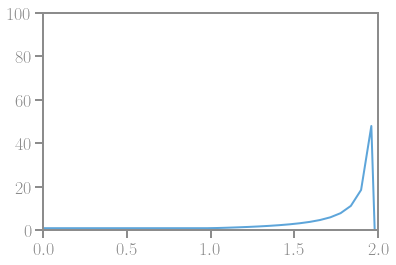

In [61]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar, ah = ana._homogeneous_alpha()[1])


_s = ana._s.subs({Œ±: _homog_state[Œ±]}).subs(_matpar)
_sf = sp.lambdify(t, _s, "numpy")

plt.plot(_times, [_sf(t) for t in _times], c="C0")
plt.xlim(0, _matpar[k])
plt.ylim(0, 100)


In [62]:
_en_h = sp.lambdify(t, atk.energy(_homog_state).subs({Œ±: _homog_state[Œ±]}).subs(_matpar), "numpy")
_en_dam_h = sp.lambdify(t, atk._damage(_homog_state).subs({Œ±: _homog_state[Œ±]}).subs(_matpar), "numpy")
_en_ela_h = sp.lambdify(t, atk._elastic(_homog_state).subs({Œ±: _homog_state[Œ±]}).subs(_matpar), "numpy")

plt.plot(np.linspace(0., 3.), [_en_h(t) for t in np.linspace(0., 3.)], c="C0")
plt.plot(np.linspace(0., 3.), [_en_dam_h(t) for t in np.linspace(0., 3.)], c="C1")
plt.plot(np.linspace(0., 3.), [_en_ela_h(t) for t in np.linspace(0., 3.)], c="C2")


KeyError: Piecewise(((-L*w1 + 0.707106781186548*t*sqrt(E0*k*w1))/(L*w1*(k - 1.0)), t >= 1.0), (0, True))

1.0


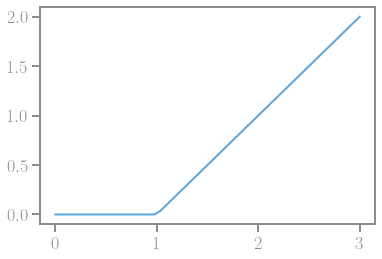

In [63]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar, ah = ana._homogeneous_alpha()[1])


_w = ana._w.subs({Œ±: _homog_state[Œ±]}).subs(_matpar)
_wf = sp.lambdify(t, _w, "numpy")

plt.plot(_times, [_wf(t) for t in _times], c="C0")


### Localised branches and H-

<lambdifygenerated-1>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.9801 - 0.9801*(Œ≤ + 1)/(1 - Œ≤)
<lambdifygenerated-2>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.834177777777778 - 0.834177777777778*(Œ≤ + 1)/(1 - Œ≤)
<lambdifygenerated-3>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.700011111111111 - 0.700011111111111*(Œ≤ + 1)/(1 - Œ≤)
<lambdifygenerated-4>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.5776 - 0.5776*(Œ≤ + 1)/(1 - Œ≤)
<lambdifygenerated-5>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.466944444444444 - 0.466944444444444*(Œ≤ + 1)/(1 - Œ≤)
<lambdifygenerated-6>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.368044444444444 - 0.368044444444444*(Œ≤ + 1)/(1 - Œ≤)
<lambdifygenerated-7>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2

(-1.0, 2.0)

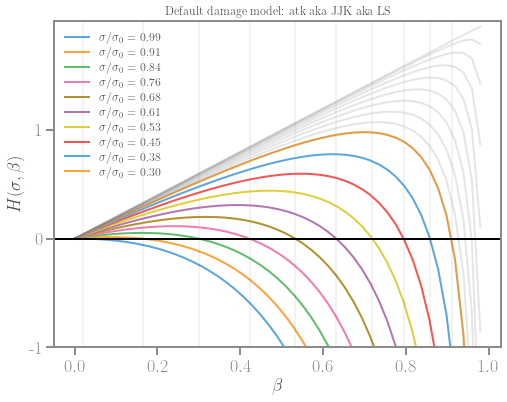

In [11]:
_HœÉŒ≤ = ana._H_damage_profile().subs(_matpar)

_œÉ = sp.symbols('œÉ')
_Œ≤ = sp.symbols('Œ≤')

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


for sigmav in np.linspace(.99, .3, 10):
# for sigmav in np.arange(2, 5):
    _HŒ≤ = _HœÉŒ≤.subs({_œÉ: sigmav})
    # _HŒ≤ = _HœÉŒ≤.subs({_œÉ: 1./k})
    _HŒ≤f = sp.lambdify(_Œ≤, _HŒ≤, "numpy")
    _sol = sp.solve(_HŒ≤, _Œ≤, (0, 1), solver='bisect') 
    Œ±max = _sol[1][0]
    axis.plot(_damage, [_HŒ≤f(Œ≤) for Œ≤ in _damage], label = f"$\sigma/\sigma_0$  = {sigmav:.2f}")
    # axis.plot(_damage, [_HŒ≤f(Œ≤) for Œ≤ in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    axis.axvline(Œ±max, c='k', lw=.1)

for sigmav in np.linspace(.3, .01, 10):
# for sigmav in np.arange(2, 5):
    _HŒ≤ = _HœÉŒ≤.subs({_œÉ: sigmav})
    # _HŒ≤ = _HœÉŒ≤.subs({_œÉ: 1./k})
    _HŒ≤f = sp.lambdify(_Œ≤, _HŒ≤, "numpy")
    _sol = sp.solve(_HŒ≤, _Œ≤, (0, 1), solver='bisect') 
    Œ±max = _sol[1][0]
    axis.plot(_damage, [_HŒ≤f(Œ≤) for Œ≤ in _damage], 
        # label = f"$\sigma/\sigma_0$  = {sigmav:.2f}", 
        c='gray',
        alpha = .2
        )
    # axis.plot(_damage, [_HŒ≤f(Œ≤) for Œ≤ in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    # axis.axvline(Œ±max, c='k', lw=.1)



axis.set_ylabel("$H(\\sigma, \\beta)$")
axis.set_xlabel("$\\beta$")
axis.set_title(f"{ana.model}")
axis.legend()
axis.axhline(0, c="k")
axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
axis.set_ylim(-1, 2)


In [12]:
figure.tight_layout()
figure.savefig("../../notes/figures/atk-Hbeta.pdf")

In [199]:
_matpar == atk_matpar
# _matpar

True

In [200]:
ana._H_damage_profile().subs(atk_matpar)

2*Œ≤ - œÉ**2*(-1 + (Œ≤ + 1)/(1 - Œ≤))

In [201]:
sol, idx = ana.max_Œ±(atk_matpar)
sol[idx]

1 - œÉ**2

In [203]:

_bar_H = ana._H_damage_profile().subs(atk_matpar)    \
    .subs({_Œ≤: _Œ≥*_Œ±0})                 \
    .subs({_Œ±0: sol[idx]}).simplify()

_bar_H

2*Œ≥*(œÉ**2 - 1)*(Œ≥*(œÉ**2 - 1) - œÉ**2 + 1)/(-Œ≥*(œÉ**2 - 1) - 1)

/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_93117/3521142342.py:524: RuntimeWarning: divide by zero encountered in double_scalars
  ax2.plot(_damage, [(_fv(b))**(-1/2) for b in _damage], lw=1, c='gray')
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_93117/3521142342.py:524: RuntimeWarning: divide by zero encountered in double_scalars
  ax2.plot(_damage, [(_fv(b))**(-1/2) for b in _damage], lw=1, c='gray')
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_93117/3521142342.py:524: RuntimeWarning: divide by zero encountered in double_scalars
  ax2.plot(_damage, [(_fv(b))**(-1/2) for b in _damage], lw=1, c='gray')
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_93117/3521142342.py:524: RuntimeWarning: invalid value encountered in double_scalars
  ax2.plot(_damage, [(_fv(b))**(-1/2) for b in _damage], lw=1, c='gray')
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_93117/3521142342.py:524: RuntimeWarning: divide by zero encountered in

(<Figure size 720x432 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\beta/\\bar \\alpha$'>,
        <AxesSubplot:xlabel='$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\\, \\sigma$', ylabel='$\\sigma/\\sigma_0$'>],
       dtype=object))

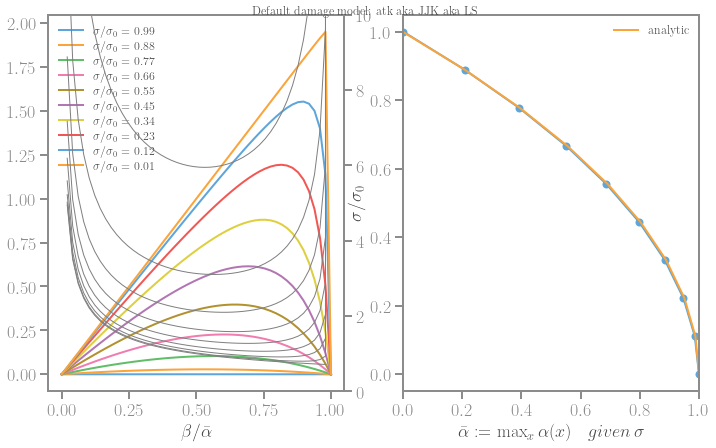

In [104]:
ana._plot_H_Hminusonehalf_alphamax(atk_matpar)

In [108]:
_subs_sing = {Œ±: _Œ≥*_Œ±0}
_h = (2*ana._w - _œÉ**2 * (ana._s - 1/E0)).subs(_matpar).subs(_subs_sing)

_h

2*Œ±0*Œ≥ - œÉ**2*(-1 + (Œ±0*Œ≥ + 1)/(-Œ±0*Œ≥ + 1))

In [233]:
_hprime = sp.diff(_h, _Œ≥)
_hprime

2*Œ±0 - œÉ**2*(Œ±0/(-Œ±0*Œ≥ + 1) + Œ±0*(Œ±0*Œ≥ + 1)/(-Œ±0*Œ≥ + 1)**2)

(-1.0, 2.0)

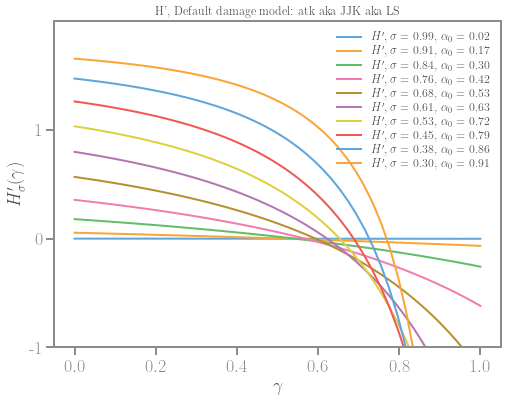

In [234]:
_œÉ = sp.symbols('œÉ')
_Œ≤ = sp.symbols('Œ≤')
_HœÉŒ≤ = ana._H_damage_profile().subs(_matpar)

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


for sigmav in np.linspace(.99, .3, 10):
    _HŒ≤ = _HœÉŒ≤.subs({_œÉ: sigmav})

    _sol = sp.solve(_HŒ≤, _Œ≤, (0, 1), solver='bisect') 

    Œ±max = _sol[1][0]
    # print(amax)
    _hprimeS = _hprime.subs({_œÉ: sigmav, _Œ±0: Œ±max})
    _hprimeSf = sp.lambdify(_Œ≥, _hprimeS, "numpy")

    # _hprimeSf
    axis.plot(_damage, [_hprimeSf(Œ≤) for Œ≤ in _damage], label = f"$H', \\sigma =$ {sigmav:.2f}, $\\alpha_0 = $ {_sol[1][0]:.2f}")
    # axis.plot(_damage, [_HŒ≤f(Œ≤) for Œ≤ in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    # axis.axvline(Œ±max, c='k', lw=.1)


axis.set_ylabel("$H'_\\sigma(\\gamma)$")
axis.set_xlabel("$\\gamma$")
axis.set_title(f"H', {ana.model}")
axis.legend()
# axis.axhline(0, c="k")
axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
axis.set_ylim(-1, 2)


In [235]:
_h

2*Œ±0*Œ≥ - œÉ**2*(-1 + (Œ±0*Œ≥ + 1)/(-Œ±0*Œ≥ + 1))

In [236]:
_h**(-1/2)

(2*Œ±0*Œ≥ - œÉ**2*(-1 + (Œ±0*Œ≥ + 1)/(-Œ±0*Œ≥ + 1)))**(-0.5)

In [237]:
(sp.solve((2*ana._w - _œÉ**2 * (ana._s - 1/E0)), Œ±)[0]).subs(_matpar).simplify()

-œÉ**2/2 - sqrt(œÉ**4 - 2*œÉ**2 + 1)/2 + 1/2

In [239]:
sp.diff(_h, _Œ≥).subs({_Œ≥: 0})

-2*Œ±0*œÉ**2 + 2*Œ±0

In [240]:
sp.diff(_h, _Œ≥).subs({_Œ≥: 1})

2*Œ±0 - œÉ**2*(Œ±0/(1 - Œ±0) + Œ±0*(Œ±0 + 1)/(1 - Œ±0)**2)

In [106]:
_HœÉŒ≤ = ana._H_damage_profile()
_HœÉŒ≤
# Lin√©aire - lin√©aire (JJK)

(2*Œ≤ - œÉ**2*((Œ≤*(k - 1) + 1)/(1 - Œ≤) - 1/E0))/E0

In [107]:
_HœÉŒ≤ = ana._H_damage_profile().subs(_matpar)
_HœÉŒ≤

2*Œ≤ - œÉ**2*(-1 + (Œ≤ + 1)/(1 - Œ≤))

In [227]:
_HœÉŒ≤ = ana._H_damage_profile().subs(_matpar)
HœÉŒ≤_Œ≤ = sp.diff(_HœÉŒ≤, _Œ≤)
HœÉŒ≤_Œ≤

-œÉ**2*(1/(1 - Œ≤) + (Œ≤ + 1)/(1 - Œ≤)**2) + 2

In [68]:
HœÉŒ≤_Œ≤.subs({_Œ≤: 0})


2 - 2*œÉ**2

In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/atk-maxalpha.pdf")

In [75]:
ana.snap_back(_matpar) 
# < 0

In [73]:
print(ana.model)

Default damage model: atk aka JJK aka LS


In [ ]:
_HœÉŒ≥ = ana._H_damage_profile().subs(_matpar).subs({_Œ≤: _Œ±0*_Œ≥})
HœÉŒ≥_Œ≥ = sp.diff(_HœÉŒ≥, _Œ≥)
# HœÉŒ≥_Œ≥.simplify().subs({_Œ≥: 1})
HœÉŒ≥_Œ≥




In [109]:
sol[idx]

1 - œÉ**2

In [115]:
((_bar_H)**(-1/2))*sol[idx]

(1 - œÉ**2)/(2*Œ≥*(1 - œÉ**2) - œÉ**2*(-1 + (Œ≥*(1 - œÉ**2) + 1)/(-Œ≥*(1 - œÉ**2) + 1)))**0.5

Text(0.5, 1.0, 'Default damage model: atk aka JJK aka LS')

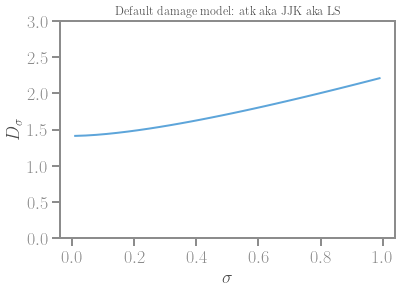

In [117]:
sol, idx = ana.max_Œ±(atk_matpar)

sol[idx].simplify()

_bar_H = ana._H_damage_profile().subs(atk_matpar)    \
    .subs({_Œ≤: _Œ≥*_Œ±0})                 \
    .subs({_Œ±0: sol[idx]}).simplify()

ana._integrate_Hminusonehalf(.1, _bar_H)

_D = []
_sigmas = np.linspace(.99, .01, 30)
for œÉv in _sigmas:
    _anot = sol[idx].subs({_œÉ: œÉv})
    _fv = sp.lambdify(_Œ≥, ((_bar_H)**(-1/2)*sol[idx]).subs({_œÉ: œÉv}), "numpy")
    val = _integ.quad(_fv, 0, 1)
    # val = ana._integrate_Hminusonehalf(œÉv, _bar_H)
    _D.append(val[0])
plt.plot(_sigmas, _D)
plt.ylim(0, 3)
plt.ylabel("$D_\\sigma$")
plt.xlabel("$\\sigma$")
plt.title(ana.model)

In [125]:
ana.max_Œ±(atk_matpar)

([0, 1 - œÉ**2], 1)

In [128]:
ana._integrate_Dsigma(.99, _bar_H, matpar=atk_matpar)


(2.2103482155334926, 4.3674175387309333e-10)

Text(0.5, 1.0, 'Default damage model: atk aka JJK aka LS')

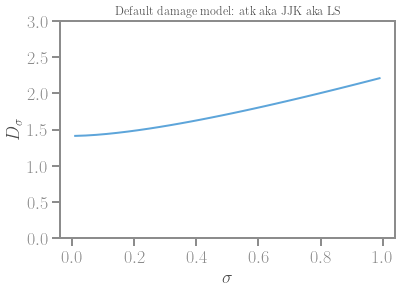

In [132]:
_D = []
_sigmas = np.linspace(.99, .01, 30)
for œÉv in _sigmas:
    val = ana._integrate_Dsigma(œÉv, _bar_H, matpar=atk_matpar)
    _D.append(val[0])
plt.plot(_sigmas, _D)
plt.ylim(0, 3)
plt.ylabel("$D_\\sigma$")
plt.xlabel("$\\sigma$")
plt.title(ana.model)

In [32]:
ana.model

## ATn

In [133]:
## Simple Analytic 
# import visuals

E0, L, w1, ùìÅ, œÉc = sp.symbols('E0 L w1 ùìÅ œÉ_c')
# x, t = sp.symbols('x t')
Œ± = sp.Function('Œ±')(x)
u = sp.Function('u')(x)

n = sp.symbols('n')


#### ATn, n=1 => AT1

In [134]:
state = {u: u, Œ±: Œ±}
matpar = {n: 1, E0: 1, w1: 1, ùìÅ:ùìÅ}
_matpar = {n: 1, L: 1, E0: 1, w1: 1, ùìÅ:ùìÅ}

at1_matpar = _matpar

at1 = DamageATn(state, matpar={n: 1, E0: E0, w1: w1, ùìÅ:ùìÅ, L: L}, name="At1 Damage Model", slug=f"at1")
ana = ModelAnalysis(model = at1)


print(ana.model)


At1 Damage Model


#### First order

In [135]:
ana.model.slug

'at1'

In [28]:
# ana._print_model_functions()
ana._print_model_functions(_matpar)

Output in model-atk-matpar.txt
0=
t_c=
H(\sigma, \beta)=
H(\sigma, \gamma)=
1/\sqrt{H(\sigma, \beta)}=
(S(\beta)-S_0)/\sqrt{H(\sigma, \beta)}=
(S(\gamma)-S_0)/\sqrt{H(\sigma, \gamma)}=
\frac{\partial H}{\partial \gamma}=
\frac{\partial H}{\partial \gamma}|_{\gamma=1}=
\frac{\partial 1/\sqrt{H}}{\partial \gamma}|_{\gamma=1}=


In [246]:
_ = ana.model.energy(ana.model.state)
# , Œ±) \
#     .subs({u: _u0, Œ±: _alpha0})         \
#     .simplify()

In [147]:
# sp.solve(ana.crit, t)
_ = ana.critical_load(_matpar)

In [148]:
_

L*sqrt(w1/E0)

In [249]:
sp.latex(_)

'L \\sqrt{\\frac{1}{E_{0}}}'

In [141]:
ana.criterion()

-1.0*E0*t**2/L**2 + w1

In [149]:
ana._critical_load

L*sqrt(w1/E0)

In [150]:
ana.critical_load_N(_matpar)

1.0

In [ ]:

figure, axis = ana.plot_homogeneous_alpha(_matpar)
axis.set_ylim(-0.1, 1)

# axis.axhline(0, c='k')
axis.set_xlim(0, 3)
axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, ana.critical_load_N(_matpar), 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$\\alpha$")
axis.set_ylabel("$\\alpha$")
axis.set_title(f"{ana.model}")

In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-alpha-homog.pdf")

In [ ]:

figure, axis = ana.plot_homogeneous_stress(_matpar)


# axis.axhline(0, c='k')
axis.set_xlim(0, 3)
axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, ana.critical_load_N(_matpar), 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$t$")
axis.set_ylabel("$\\sigma$")
axis.set_title(f"{ana.model}")

In [ ]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar)
_ = _homog_state[Œ±]


In [ ]:
sp.latex(_)

In [ ]:
at1.energy({u: _homog_state[u], Œ±: _homog_state[Œ±]})

In [ ]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


_en_h = sp.lambdify(t, at1.energy(_homog_state).subs({Œ±: _homog_state[Œ±]}).subs(_matpar), "numpy")
_en_dam_h = sp.lambdify(t, at1._damage(_homog_state).subs({Œ±: _homog_state[Œ±]}).subs(_matpar), "numpy")
_en_ela_h = sp.lambdify(t, at1._elastic(_homog_state).subs({Œ±: _homog_state[Œ±]}).subs(_matpar), "numpy")

axis.plot(np.linspace(0., 3.), [_en_h(t) for t in np.linspace(0., 3.)], c="C0", label = "total")
axis.plot(np.linspace(0., 3.), [_en_dam_h(t) for t in np.linspace(0., 3.)], c="C1", label = "damage")
axis.plot(np.linspace(0., 3.), [_en_ela_h(t) for t in np.linspace(0., 3.)], c="C2", label = "elastic")
axis.axvline(np.float64(tc), c='k', lw=.1)
axis.legend()


axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, tc, 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$t$")
axis.set_ylabel("$E$")
axis.set_title(f"{ana.model}")


In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-energies-homog.pdf")

In [ ]:
figure, axis = ana.plot_material(_matpar)

In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-model.pdf")

#### Max alpha as a function of sigma

#### Localised branches


In [383]:
_œÉ = sp.symbols('œÉ')
_Œ≤ = sp.symbols('Œ≤')

In [ ]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar)


_s = ana._sp.subs({Œ±: _homog_state[Œ±]}).subs(_matpar)
_sf = sp.lambdify(t, _s, "numpy")

plt.plot(_times, [_sf(t) for t in _times], c="C0")


$$E_0 H(\sigma, \beta) = 2w(\beta) - \sigma^2 (S(\beta)-S_0))$$

with
$$\eta^2 \alpha'(x)^2 = H(\sigma, \alpha(x)) \qquad \qquad x\in S_i$$

$$e_\text{loc}(\sigma)=\int_0^{\bar \alpha(\sigma)} \frac{S(\beta)-S_0}{\sqrt{2w(\beta) - \sigma^2(S(\beta)-S_0))}}d\beta$$

In [255]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-Hbeta.pdf")

In [152]:
_subs_sing = {Œ±: _Œ≥*_Œ±0}
_h = (2*ana._w - _œÉ**2 * (ana._s - 1/E0)).subs(_matpar).subs(_subs_sing)

_h

2*Œ±0*Œ≥ - œÉ**2*(-1 + (-Œ±0*Œ≥ + 1)**(-2))

In [259]:
_hprime = sp.diff(_h, _Œ≥)
_hprime

-2*Œ±0*œÉ**2/(-Œ±0*Œ≥ + 1)**3 + 2*Œ±0

(-1.0, 2.0)

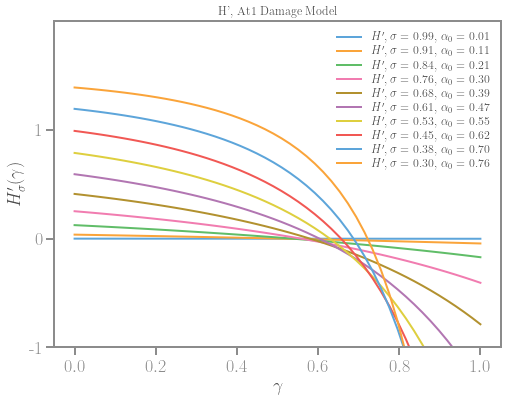

In [260]:
_œÉ = sp.symbols('œÉ')
_Œ≤ = sp.symbols('Œ≤')
_HœÉŒ≤ = ana._H_damage_profile().subs(_matpar)

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


for sigmav in np.linspace(.99, .3, 10):
    _HŒ≤ = _HœÉŒ≤.subs({_œÉ: sigmav})

    _sol = sp.solve(_HŒ≤, _Œ≤, (0, 1), solver='bisect') 

    Œ±max = _sol[1][0]
    # print(amax)
    _hprimeS = _hprime.subs({_œÉ: sigmav, _Œ±0: Œ±max})
    _hprimeSf = sp.lambdify(_Œ≥, _hprimeS, "numpy")

    # _hprimeSf
    axis.plot(_damage, [_hprimeSf(Œ≤) for Œ≤ in _damage], label = f"$H', \\sigma =$ {sigmav:.2f}, $\\alpha_0 = $ {_sol[1][0]:.2f}")
    # axis.plot(_damage, [_HŒ≤f(Œ≤) for Œ≤ in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    # axis.axvline(Œ±max, c='k', lw=.1)


axis.set_ylabel("$H'_\\sigma(\\gamma)$")
axis.set_xlabel("$\\gamma$")
axis.set_title(f"H', {ana.model}")
axis.legend()
# axis.axhline(0, c="k")
axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
axis.set_ylim(-1, 2)


In [261]:
_h

2*Œ±0*Œ≥ - œÉ**2*(-1 + (-Œ±0*Œ≥ + 1)**(-2))

In [262]:
_h**(-1/2)

(2*Œ±0*Œ≥ - œÉ**2*(-1 + (-Œ±0*Œ≥ + 1)**(-2)))**(-0.5)

In [263]:
sp.diff(_h, _Œ≥).subs({_Œ≥: 0})

-2*Œ±0*œÉ**2 + 2*Œ±0

In [265]:
sp.diff(_h, _Œ≥).subs({_Œ≥: 1})

-2*Œ±0*œÉ**2/(1 - Œ±0)**3 + 2*Œ±0

In [268]:
2*_C*x+-1 +1/(1-_C*x)**2

2*C*x - 1 + (-C*x + 1)**(-2)

In [148]:
sol, idx = ana.max_Œ±(_matpar)

sol[idx].simplify()

_H_subs = ana._H_damage_profile().subs(matpar)    \
    .subs({_Œ≤: _Œ≥*_Œ±0})                 \
    .subs({_Œ±0: sol[idx]})

_HœÉŒ≥ = _H_subs.simplify()
_HœÉŒ≥.collect(_Œ≥)

Œ≥*(-œÉ**2/2 - œÉ*sqrt(œÉ**2 + 8)/2 + 2) + œÉ**2 - 16*œÉ**2/(Œ≥*(œÉ**2 + œÉ*sqrt(œÉ**2 + 8) - 4) + 4)**2

/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_88367/1285665131.py:491: RuntimeWarning: divide by zero encountered in double_scalars
  ax2.plot(_damage, [(_fv(b))**(-1/2) for b in _damage], lw=1, c='gray')
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_88367/1285665131.py:491: RuntimeWarning: divide by zero encountered in double_scalars
  ax2.plot(_damage, [(_fv(b))**(-1/2) for b in _damage], lw=1, c='gray')
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_88367/1285665131.py:491: RuntimeWarning: divide by zero encountered in double_scalars
  ax2.plot(_damage, [(_fv(b))**(-1/2) for b in _damage], lw=1, c='gray')
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_88367/1285665131.py:491: RuntimeWarning: divide by zero encountered in double_scalars
  ax2.plot(_damage, [(_fv(b))**(-1/2) for b in _damage], lw=1, c='gray')
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_88367/1285665131.py:491: RuntimeWarning: invalid value encountered in

(<Figure size 720x432 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\beta/\\bar \\alpha$'>,
        <AxesSubplot:xlabel='$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\\, \\sigma$', ylabel='$\\sigma/\\sigma_0$'>],
       dtype=object))

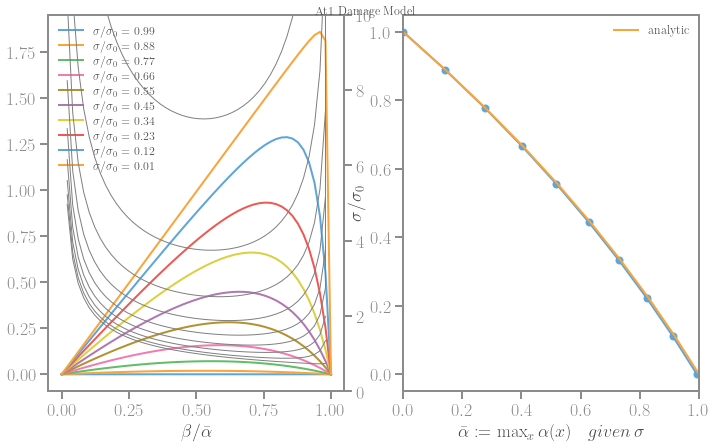

In [150]:
ana._plot_H_Hminusonehalf_alphamax(at1_matpar)

Integration

Text(0.5, 1.0, 'At1 Damage Model')

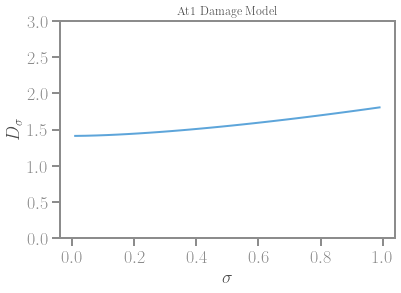

In [179]:
_D = []
_sigmas = np.linspace(.99, .01, 30)
for œÉv in _sigmas:
    val = ana._integrate_Dsigma(œÉv, _bar_H, matpar=at1_matpar)
    _D.append([œÉv, val[0]])
plt.plot(np.array(_D)[:, 0], np.array(_D)[:, 1])
plt.ylim(0, 3)
plt.ylabel("$D_\\sigma$")
plt.xlabel("$\\sigma$")
plt.title(ana.model)

In [ ]:
def _eps_1_d(sigma, tol = 1e-3):
    _Œ±_max = ana._Œ±_max(sigma, _matpar)
    _f = (ana._s - 1/E0).subs(Œ±, _Œ≤)/sp.sqrt(ana._H_damage_profile())    \
        .subs(_matpar)                                                   \
        .subs({_œÉ: œÉv})                                                   \
        .simplify()

    __fv = sp.lambdify(_Œ≤, f.subs(_matpar), "numpy")
    # _tol = 0.001
    _betas = np.linspace(_tol, _Œ±_max-_tol, 30)
    eps = np.trapz([__fv(b) for b in _betas], _betas)

    return eps, (_f, _Œ±_max)

def _eps_1_d_integrand(sigma, matpar, tol = 1e-3):
    _Œ±_max = ana._Œ±_max(sigma, matpar)
    _f = ((ana._s - 1/E0).subs(Œ±, _Œ≤)/sp.sqrt(ana._H_damage_profile()))    \
        .subs(matpar)                                                   \
        .subs({_œÉ: sigma})                                                   \
        .simplify()

    __fv = sp.lambdify(_Œ≤, f.subs(matpar), "numpy")

    return _f, _Œ±_max, __fv




0.707106781186548*(œÉ**2 - 1)*((Œ≥*œÉ**2 - Œ≥ + 1)**2 - 1)/((-Œ≥*(œÉ**2 - 1)*(Œ≥*(œÉ**2 - 1) - œÉ**2 + 1)/(Œ≥*(œÉ**2 - 1) + 1))**0.5*(Œ≥*œÉ**2 - Œ≥ + 1)**2)

In [186]:
sol, idx = ana.max_Œ±(at1_matpar)

sol[idx].simplify()

_bar_H = ana._H_damage_profile().subs(atk_matpar)    \
    .subs({_Œ≤: _Œ≥*_Œ±0})                 \
    .subs({_Œ±0: sol[idx]}).simplify()

_S = (ana._s - 1/E0).subs(Œ±, _Œ≤)            \
    .subs(atk_matpar).subs({_Œ≤: _Œ≥*_Œ±0})                 \
    .subs({_Œ±0: sol[idx]}).simplify()

_f = (_S * (_bar_H)**(-1/2)*sol[idx]).simplify()

_s = []
_sigmas = np.linspace(.99, .01, 30)

for œÉv in _sigmas:
    _fv = sp.lambdify(_Œ≥, _f.subs({_œÉ: œÉv}), "numpy")
    val = _integ.quad(_fv, 0, 1)
    _s.append((œÉv, val[0]))

# plt.plot(_sigmas, _D)
# plt.ylim(0, 3)
# plt.ylabel("$D_\\sigma$")
# plt.xlabel("$\\sigma$")
# plt.title(ana.model)

Text(0.5, 1.0, 'At1 Damage Model')

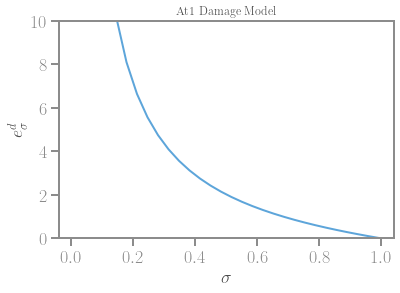

In [190]:

plt.plot(np.array(_s)[:, 0], np.array(_s)[:, 1])
plt.ylim(0, 10)
plt.ylabel("$e^d_\\sigma$")
plt.xlabel("$\\sigma$")
plt.title(ana.model)

#### Behaviour around $\beta=0$

$$\frac{\partial f}{\partial \beta}|_{\beta=0}$$

with $f = 1/\sqrt{H(\sigma, \beta)}$

In [ ]:
sp.diff(_f, _Œ≤).simplify().subs({ _Œ≤: 0})

In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-maxalpha.pdf")

In [287]:
ana.snap_back(matpar) < 0

TypeError: '<' not supported between instances of 'NoneType' and 'int'

In [ ]:
ana._eps_1_d_integrand(.99, _matpar)

In [378]:
def _analyse_H(analysis, matpar = {}):
    fig, ax = _plot_H(analysis)
    fig.tight_layout()
    _fname = f"../../notes/figures/{analysis.model.slug}-Hbeta.pdf"
    fig.savefig(_fname)

    print(f"H Figure in {_fname}")

    fig, ax = _plot_Hprime(analysis)
    fig.tight_layout()
    _fname = f"../../notes/figures/{analysis.model.slug}-H-prime-beta.pdf"
    fig.savefig(_fname)

    print(f"H-prime Figure in {_fname}")

    _subs_sing = {_Œ≤: _Œ≥*_Œ±0}
    h = analysis._H_damage_profile().subs(_matpar).subs(_subs_sing)
    hprime = sp.diff(h, _Œ≥)
    hprime_zero = hprime.subs({_Œ≥: 0})
    hprime_one = hprime.subs({_Œ≥: 1})
    # sp.latex(h)

    if matpar == {}:
        _fname = f"H-{analysis.model.slug}.txt"
    else: 
        _fname = f"H-{analysis.model.slug}-matpar.txt"
    print(f"Output in {_fname}")
    
    _fcs = [h,
            hprime,
            hprime_zero,
            hprime_one
            ]
    _lab = ["H", "Hprime", "Hprime-zero", "Hprime-one"]
    _known = ["H_\\sigma(, \\gamma)=", 
              "H'_\\sigma(\\gamma)=",
              "H'_\\sigma(\\gamma)(0)=",
              "H'_\\sigma(\\gamma)(1)=",
              ]
    out_file = open(_fname,"w")
    
    for y in zip(_fcs, _lab, _known):
        _tex = y[2] + str(sp.latex(y[0])) \
            .replace("Œ±", "\\alpha") \
            .replace("Œ≤", "\\beta") \
            .replace("Œ≥", "\\gamma") \
            .replace("œÉ", "\\sigma")
        out_file.write("\\begin{equation}")
        out_file.write(f"\\label{{ eqn:{analysis.model.slug}-{y[1]} }}")
        out_file.write(_tex)
        out_file.write("\\end{equation}")
        out_file.write("\n")

    out_file.close()

    return


def _plot_H(analysis):
    _HœÉŒ≤ = analysis._H_damage_profile().subs(_matpar)
    _œÉ = sp.symbols('œÉ')
    _Œ≤ = sp.symbols('Œ≤')

    figure, axis = plt.subplots(1, 1, figsize=(8, 6))

    for sigmav in np.linspace(.99, .3, 10):
        _HŒ≤ = _HœÉŒ≤.subs({_œÉ: sigmav})
        _HŒ≤f = sp.lambdify(_Œ≤, _HŒ≤, "numpy")
        _sol = sp.solve(_HŒ≤, _Œ≤, (0, 1), solver='bisect') 
        Œ±max = _sol[1][0]
        axis.plot(_damage, [_HŒ≤f(Œ≤) for Œ≤ in _damage], label = f"$\sigma/\sigma_0$  = {sigmav:.2f}")
        axis.axvline(Œ±max, c='k', lw=.1)

    for sigmav in np.linspace(.3, .01, 10):
        _HŒ≤ = _HœÉŒ≤.subs({_œÉ: sigmav})
        _HŒ≤f = sp.lambdify(_Œ≤, _HŒ≤, "numpy")
        _sol = sp.solve(_HŒ≤, _Œ≤, (0, 1), solver='bisect') 
        Œ±max = _sol[1][0]
        axis.plot(_damage, [_HŒ≤f(Œ≤) for Œ≤ in _damage], 
            c='gray',
            alpha = .2
            )

    axis.set_ylabel("$H(\\sigma, \\beta)$")
    axis.set_xlabel("$\\beta$")
    axis.set_title(f"{analysis.model}")
    axis.legend()
    axis.axhline(0, c="k")
    axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
    axis.set_ylim(-1, 2)

    return figure, axis


def _plot_Hprime(analysis):
    _œÉ = sp.symbols('œÉ')
    _Œ≤ = sp.symbols('Œ≤')
    _HœÉŒ≤ = analysis._H_damage_profile().subs(_matpar)

    figure, axis = plt.subplots(1, 1, figsize=(8, 6))

    for sigmav in np.linspace(.99, .3, 10):
        _HŒ≤ = _HœÉŒ≤.subs({_œÉ: sigmav})

        _sol = sp.solve(_HŒ≤, _Œ≤, (0, 1), solver='bisect') 

        Œ±max = _sol[1][0]
        _hprimeS = _hprime.subs({_œÉ: sigmav, _Œ±0: Œ±max})
        _hprimeSf = sp.lambdify(_Œ≥, _hprimeS, "numpy")

        axis.plot(_damage, [_hprimeSf(Œ≤) for Œ≤ in _damage], label = f"$H', \\sigma =$ {sigmav:.2f}, $\\alpha_0 = $ {_sol[1][0]:.2f}")

    axis.set_ylabel("$H'_\\sigma(\\gamma)$")
    axis.set_xlabel("$\\gamma$")
    axis.set_title(f"H', {analysis.model}")
    axis.legend()
    axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
    axis.set_ylim(-1, 2)

    return figure, axis



<lambdifygenerated-1071>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.9801 - 0.9801/(1 - Œ≤)**2
<lambdifygenerated-1072>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.834177777777778 - 0.834177777777778/(1 - Œ≤)**2
<lambdifygenerated-1073>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.700011111111111 - 0.700011111111111/(1 - Œ≤)**2
<lambdifygenerated-1074>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.5776 - 0.5776/(1 - Œ≤)**2
<lambdifygenerated-1075>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.466944444444444 - 0.466944444444444/(1 - Œ≤)**2
<lambdifygenerated-1076>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.368044444444444 - 0.368044444444444/(1 - Œ≤)**2
<lambdifygenerated-1077>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.2809 - 

H Figure in ../../notes/figures/at1-Hbeta.pdf
H-prime Figure in ../../notes/figures/at1-H-prime-beta.pdf
Output in H-at1.txt


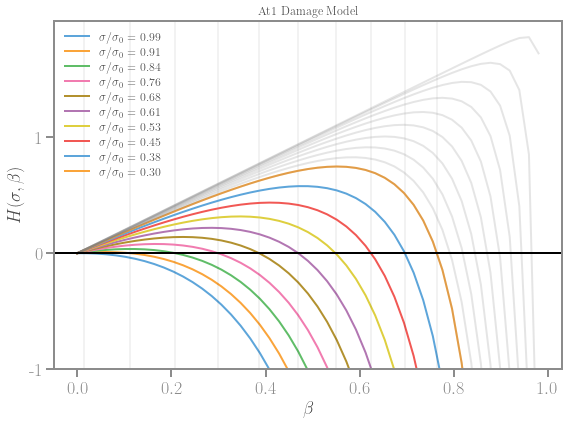

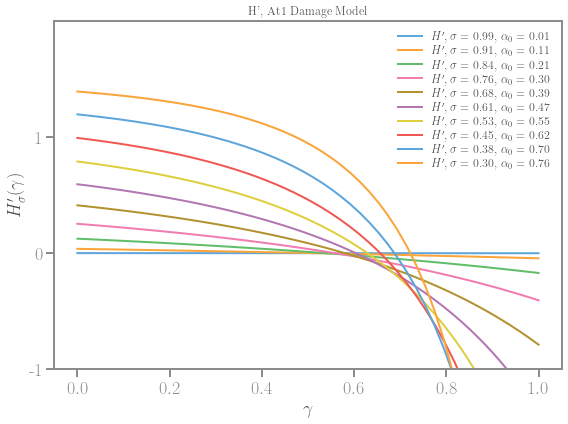

In [379]:
# %%capture
_analyse_H(ana)

In [382]:
%%capture

state = {u: u, Œ±: Œ±}

# ATK
_matpar = {k: 2, E0: 1, w1: 1, ùìÅ:ùìÅ, L: 1}
matpar = {k: k, E0: E0, w1: w1, ùìÅ:ùìÅ, L: L}

atk = DefaultDamage(state, matpar, slug=f"atk")
ana_atk = ModelAnalysis(atk)
ana_atk.criterion()
_analyse_H(ana_atk)

# ATN

matpar = {n: 1, E0: 1, w1: 1, ùìÅ:ùìÅ}
_matpar = {n: 1, L: 1, E0: 1, w1: 1, ùìÅ:ùìÅ}

at1 = DamageATn(state, matpar={n: 1, E0: E0, w1: w1, ùìÅ:ùìÅ, L: L},
                name="At1 Damage Model",
                slug=f"at1")
ana_at1 = ModelAnalysis(model = at1)
ana_at1.criterion()
_analyse_H(ana_at1)

# PQ

p, q, E0, L, w1, ùìÅ, œÉc = sp.symbols('p q E0 L w1 ùìÅ œÉ_c')

matpar = {p: p, q: q, E0: E0, L: L, w1: w1, ùìÅ:ùìÅ, œÉc: œÉc}
_matpar = {p: 1, q: 1, E0: 1, L: 1, w1: 2, ùìÅ:ùìÅ, œÉc: 1}

dpq = DamagePQ(state, matpar=matpar,
               name="PQ Damage Model",
               slug = "pq")
ana_pq = ModelAnalysis(model = dpq)
ana_pq.criterion()
_analyse_H(ana_pq)


# for damage_class in [ana_atk, ana_at1]:
#     damage_class.criterion()
#     print(damage_class.model.slug)
#     _analyse_H(damage_class)


In [381]:
ana._H_damage_profile()

(2*Œ≤ - œÉ**2*((1 - Œ≤)**(-2) - 1/E0))/E0

## PQ1

In [110]:
matpar

{p: p, q: q, E0: E0, L: L, w1: w1, ùìÅ: ùìÅ, œÉ_c: œÉ_c}

In [260]:
state = {u: u, Œ±: Œ±}
p, q, E0, L, w1, ùìÅ, œÉ_c = sp.symbols('p q E0 L w1 ùìÅ œÉ_c')

matpar = {p: p, q: q, E0: E0, L: L, w1: w1, ùìÅ:ùìÅ, œÉ_c: œÉc}
_matpar = {p: 1, q: 1, E0: 1, L: 1, w1: 2, ùìÅ:ùìÅ, œÉ_c: 1}
pq_matpar = _matpar


dpq = DamagePQ(state, matpar=pq_matpar, name="PQ Damage Model", slug = "pq")
ana = ModelAnalysis(model = dpq)


{p: 1, q: 1, E0: 1, L: 1, w1: 2, ùìÅ: ùìÅ, œÉ_c: 1}
{p: 1, q: 1, E0: 1, L: 1, w1: 2, ùìÅ: ùìÅ, œÉ_c: 1}


In [261]:
# ana._print_model_functions()
ana._print_model_functions(_matpar)

Output in model-pq-matpar.txt
{p: 1, q: 1, E0: 1, L: 1, w1: 2, ùìÅ: ùìÅ, œÉ_c: 1}
0=
t_c=
H(\sigma, \beta)=
H(\sigma, \gamma)=
1/\sqrt{H(\sigma, \beta)}=
(S(\beta)-S_0)/\sqrt{H(\sigma, \beta)}=
(S(\gamma)-S_0)/\sqrt{H(\sigma, \gamma)}=
\frac{\partial H}{\partial \gamma}=
\frac{\partial H}{\partial \gamma}|_{\gamma=1}=
\frac{\partial 1/\sqrt{H}}{\partial \gamma}|_{\gamma=1}=


In [105]:
ana.model.energy(ana.model.state)


0.5*E0*(1 - Œ±(x))**q*Derivative(u(x), x)**2/(Œ±(x) + 1)**p + w1*(ùìÅ**2*Derivative(Œ±(x), x)**2 + œÉc**2*(p + q)*Œ±(x)/E0)

In [106]:
sp.latex(_)

'0.5 E_{0} \\left(1 - Œ±{\\left(x \\right)}\\right)^{q} \\left(Œ±{\\left(x \\right)} + 1\\right)^{- p} \\left(\\frac{d}{d x} u{\\left(x \\right)}\\right)^{2} + w_{1} \\left(ùìÅ^{2} \\left(\\frac{d}{d x} Œ±{\\left(x \\right)}\\right)^{2} + \\frac{œÉc^{2} \\left(p + q\\right) Œ±{\\left(x \\right)}}{E_{0}}\\right)'

In [107]:
_ = ana.criterion()
_

(p + q)*(-0.5*E0**2*t**2/L**2 + w1*œÉc**2)/E0

In [ ]:
sp.latex(_)

In [ ]:
[np.float(t.subs(_matpar).subs({L: 1})) for t in sp.solve(ana.crit, t)]

In [ ]:
ana._critical_load

In [ ]:
ana.critical_load_N(_matpar)

In [ ]:
_ = ana.model.energy(ana.model.state)
# , Œ±) \
#     .subs({u: _u0, Œ±: _alpha0})         \
#     .simplify()

In [ ]:
sp.latex(_)

In [ ]:
_eq = sp.diff(dpq.energy(state), Œ±) \
    .subs({u: _u0, Œ±: Œ±}) \
    .simplify()

In [ ]:
# _ = _eq.subs(_matpar).subs({p: 2, q: 1}).simplify()
_ = _eq.subs(_matpar).simplify()

In [ ]:
_ = ana._homogeneous_alpha(_matpar)[1]
_

In [ ]:
ana.crit
ana.critical_load()

In [ ]:
tc = ana.critical_load().subs(_matpar)


In [ ]:
state, (_uf, _af) = ana._homogeneous_state(ah = ana._homogeneous_alpha(_matpar)[1])

In [ ]:
_a = state[Œ±]

_ah_f = sp.lambdify(t, _a.subs(_matpar), "numpy")
_ah_f(0)

In [ ]:
print(ana.model)

In [ ]:
figure, axis = plt.subplots(1, 1, figsize=(8, 6))

axis.plot(_times, [_ah_f(t) for t in _times])
tc = ana.critical_load().subs(_matpar)

# axis.axhline(0, c='k')
axis.set_xlim(0, 3)
axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, tc, 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$\\alpha$")
axis.set_ylabel("$\\alpha$")
axis.set_title(f"{ana.model}")


In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/pq-alpha-homog.pdf")

In [ ]:
ana._s.subs(_matpar)

In [ ]:
figure, axis = ana.plot_material(_matpar)

/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_88367/624291778.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  ax2.plot(_damage, [(_fv(b))**(-1/2) for b in _damage], lw=1, c='gray')
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_88367/624291778.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  ax2.plot(_damage, [(_fv(b))**(-1/2) for b in _damage], lw=1, c='gray')
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_88367/624291778.py:25: RuntimeWarning: invalid value encountered in double_scalars
  ax2.plot(_damage, [(_fv(b))**(-1/2) for b in _damage], lw=1, c='gray')
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_88367/624291778.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  ax2.plot(_damage, [(_fv(b))**(-1/2) for b in _damage], lw=1, c='gray')
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_88367/624291778.py:25: RuntimeWarning: divide by zero encountered in double_sc

Text(0.5, 0.98, 'PQ Damage Model')

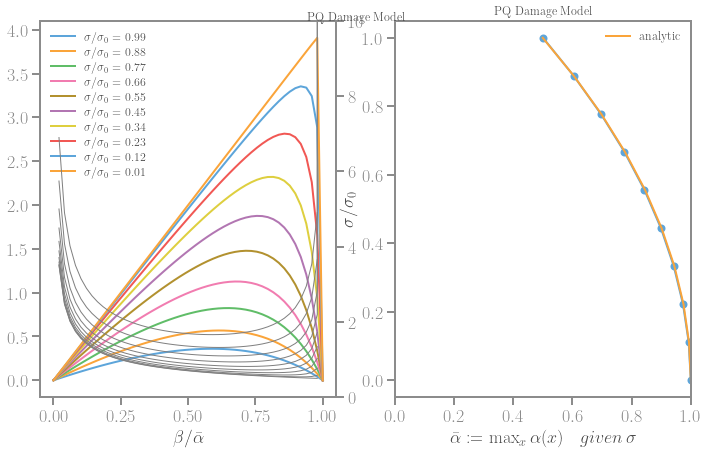

In [128]:

figure, axis = plt.subplots(1, 2, figsize=(10, 6))
figure.tight_layout()
# figure.subplots_adjust(left  = 0.125, 
#     right = 1  ,  
#     bottom = 0.1 ,  
#     top = 1    ,  
#     wspace = .9 ,  
#     hspace = 0.2 
#     )

_tol = 1e-4

sol, idx = ana.max_Œ±(pq_matpar)

_bar_H = ana._H_damage_profile().subs(pq_matpar)    \
    .subs({_Œ≤: _Œ≥*_Œ±0})                 \
    .subs({_Œ±0: sol[idx]})

_bar_H
ax2 = axis[0].twinx()

for œÉv in np.linspace(.99, .01, 10):
    _fv = sp.lambdify(_Œ≥, (_bar_H.subs({_œÉ: œÉv})), "numpy")
    axis[0].plot(_damage, [_fv(b) for b in _damage], label = f"$\sigma/\sigma_0$  = {œÉv:.2f}")
    ax2.plot(_damage, [(_fv(b))**(-1/2) for b in _damage], lw=1, c='gray')

# ax2.set_yticks([])
ax2.set_ylim(0, 10)

# , marker = 'o'
axis[0].set_xlabel("$\\beta/\\bar \\alpha$")
axis[0].legend()

amax = []
for i in np.linspace(.999, .01, 10):
    amax.append(ana._Œ±_max(i, _matpar))


axis[1].plot(amax, np.linspace(1, .0, 10), marker='o')
axis[1].set_xlabel('$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\, \\sigma$')
axis[1].set_ylabel('$\\sigma/\\sigma_0$')
axis[1].set_xlim(0., 1.)
axis[1].set_title(f"{ana.model}")

_fc = sol[idx]
# sol[idx]
_fv = sp.lambdify(_œÉ, _fc, "numpy")
_sigmas = np.linspace(1, .0, 10)
axis[1].plot([_fv(s) for s in _sigmas], _sigmas, label = "analytic")

axis[1].legend()
figure.suptitle(f"{ana.model}")


In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/pq-H-maxalpha.pdf")

Text(0.5, 1.0, 'PQ Damage Model')

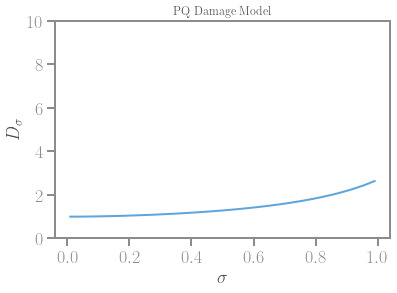

In [164]:
sol, idx = ana.max_Œ±(_matpar)

# sol[idx].simplify()

_bar_H = ana._H_damage_profile().subs(pq_matpar)    \
    .subs({_Œ≤: _Œ≥*_Œ±0})                 \
    .subs({_Œ±0: sol[idx]}).simplify()

ana._integrate_Hminusonehalf(.1, _bar_H)


_D = []
_sigmas = np.linspace(.99, .01, 30)
for œÉv in _sigmas:
    val = ana._integrate_Hminusonehalf(œÉv, _bar_H)
    _D.append(val[0])
plt.plot(_sigmas, _D)
plt.ylim(0, 10)
plt.ylabel("$D_\\sigma$")
plt.xlabel("$\\sigma$")
plt.title(ana.model)

## PQ2

In [287]:
state = {u: u, Œ±: Œ±}
p, q, E0, L, w1, ùìÅ, œÉ_c = sp.symbols('p q E0 L w1 ùìÅ œÉ_c')

matpar = {p: p, q: q, E0: E0, L: L, w1: w1, ùìÅ:ùìÅ, œÉ_c: œÉc}
_matpar = {p: 4, q: 2, E0: 1, L: 1, w1: 2, ùìÅ:ùìÅ, œÉ_c: 1}
pq2_matpar = _matpar


dpq2 = DamagePQ(state, matpar=pq2_matpar, name="PQ Damage Model 2", slug = "pq2")
ana = ModelAnalysis(model = dpq2)


{p: 4, q: 2, E0: 1, L: 1, w1: 2, ùìÅ: ùìÅ, œÉ_c: 1}
{p: 4, q: 2, E0: 1, L: 1, w1: 2, ùìÅ: ùìÅ, œÉ_c: 1}


In [263]:
ana._print_model_functions(_matpar)

Output in model-pq2-matpar.txt
{p: 4, q: 2, E0: 1, L: 1, w1: 2, ùìÅ: ùìÅ, œÉ_c: 1}
0=
t_c=
H(\sigma, \beta)=
H(\sigma, \gamma)=
1/\sqrt{H(\sigma, \beta)}=
(S(\beta)-S_0)/\sqrt{H(\sigma, \beta)}=
(S(\gamma)-S_0)/\sqrt{H(\sigma, \gamma)}=
\frac{\partial H}{\partial \gamma}=
\frac{\partial H}{\partial \gamma}|_{\gamma=1}=
\frac{\partial 1/\sqrt{H}}{\partial \gamma}|_{\gamma=1}=


In [265]:
ana.crit
ana.critical_load(_matpar)

2.0*L

In [304]:
# sol, idx = ana.max_Œ±(pq2_matpar)

"""Maximum value of alpha as a function of sigma"""
_Œ≤ = sp.symbols('Œ≤')
_œÉ = sp.symbols('œÉ')
    
sol = sp.solve(ana._H_damage_profile().subs(_matpar), _Œ≤)
arr = np.array([a.subs({_œÉ: .9}) for a in sol])
real_filter = [sp.N(a).is_real for a in arr]
sol = np.compress(real_filter, sol)
r_arr = np.array([a.subs({_œÉ: .9}) for a in sol])
# simple tet
# r_arr = arr[real_filter]

sol
idx = np.argwhere((r_arr > 0) & (r_arr < 1)).flatten()[0]
sol[idx].simplify()

-(12*sqrt(3)*sqrt(7 - 228/œÉ**2 + 2448/œÉ**4 - 1728/œÉ**6) + 55 - 900/œÉ**2 + 3024/œÉ**4 - 1728/œÉ**6)**(1/3)/3 - 4/3 - 1/(3*(12*sqrt(3)*sqrt(7 - 228/œÉ**2 + 2448/œÉ**4 - 1728/œÉ**6) + 55 - 900/œÉ**2 + 3024/œÉ**4 - 1728/œÉ**6)**(1/3)) + 4/œÉ**2 + 56/(œÉ**2*(12*sqrt(3)*sqrt(7 - 228/œÉ**2 + 2448/œÉ**4 - 1728/œÉ**6) + 55 - 900/œÉ**2 + 3024/œÉ**4 - 1728/œÉ**6)**(1/3)) - 48/(œÉ**4*(12*sqrt(3)*sqrt(7 - 228/œÉ**2 + 2448/œÉ**4 - 1728/œÉ**6) + 55 - 900/œÉ**2 + 3024/œÉ**4 - 1728/œÉ**6)**(1/3))

array([0,
       -(-3*(5*œÉ**2 + 24)/œÉ**2 + (4*œÉ**2 - 12)**2/œÉ**4)/(3*(sqrt(-4*(-3*(5*œÉ**2 + 24)/œÉ**2 + (4*œÉ**2 - 12)**2/œÉ**4)**3 + (27*(6*œÉ**2 - 12)/œÉ**2 - 9*(4*œÉ**2 - 12)*(5*œÉ**2 + 24)/œÉ**4 + 2*(4*œÉ**2 - 12)**3/œÉ**6)**2)/2 + 27*(6*œÉ**2 - 12)/(2*œÉ**2) - 9*(4*œÉ**2 - 12)*(5*œÉ**2 + 24)/(2*œÉ**4) + (4*œÉ**2 - 12)**3/œÉ**6)**(1/3)) - (sqrt(-4*(-3*(5*œÉ**2 + 24)/œÉ**2 + (4*œÉ**2 - 12)**2/œÉ**4)**3 + (27*(6*œÉ**2 - 12)/œÉ**2 - 9*(4*œÉ**2 - 12)*(5*œÉ**2 + 24)/œÉ**4 + 2*(4*œÉ**2 - 12)**3/œÉ**6)**2)/2 + 27*(6*œÉ**2 - 12)/(2*œÉ**2) - 9*(4*œÉ**2 - 12)*(5*œÉ**2 + 24)/(2*œÉ**4) + (4*œÉ**2 - 12)**3/œÉ**6)**(1/3)/3 - (4*œÉ**2 - 12)/(3*œÉ**2)],
      dtype=object)

In [293]:
# sol, idx = ana.max_Œ±(pq2_matpar)

sol = sp.solve(ana._H_damage_profile().subs(_matpar), _Œ≤)
sol
arr = np.array([a.subs({_œÉ: .9}) for a in sol])
# arr > 0

# np.argwhere((arr > 0) & (arr < 1)).flatten()[0]
real_filter = [sp.N(a).is_real for a in arr]
arr[real_filter]
# filter
# print(sp.N(arr[2]).is_real)
# sol[real_filter]
# np.argwhere(real_filter & (arr > 0) & (arr < 1)).flatten()[0]


TypeError: list indices must be integers or slices, not list

TypeError: cannot determine truth value of Relational

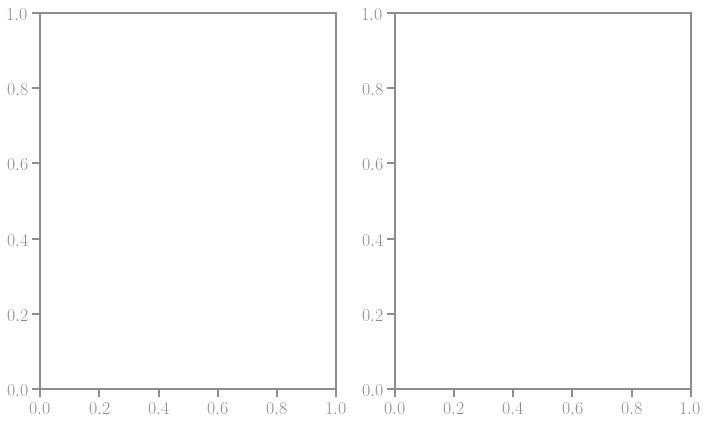

In [266]:

figure, axis = plt.subplots(1, 2, figsize=(10, 6))
figure.tight_layout()

_tol = 1e-4

sol, idx = ana.max_Œ±(pq2_matpar)

_bar_H = ana._H_damage_profile().subs(pq2_matpar)    \
    .subs({_Œ≤: _Œ≥*_Œ±0})                 \
    .subs({_Œ±0: sol[idx]})

_bar_H
ax2 = axis[0].twinx()

for œÉv in np.linspace(.99, .01, 10):
    _fv = sp.lambdify(_Œ≥, (_bar_H.subs({_œÉ: œÉv})), "numpy")
    axis[0].plot(_damage, [_fv(b) for b in _damage], label = f"$\sigma/\sigma_0$  = {œÉv:.2f}")
    ax2.plot(_damage, [(_fv(b))**(-1/2) for b in _damage], lw=1, c='gray')

ax2.set_ylim(0, 10)

axis[0].set_xlabel("$\\beta/\\bar \\alpha$")
axis[0].legend()

amax = []
for i in np.linspace(.999, .01, 10):
    amax.append(ana._Œ±_max(i, _matpar))


axis[1].plot(amax, np.linspace(1, .0, 10), marker='o')
axis[1].set_xlabel('$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\, \\sigma$')
axis[1].set_ylabel('$\\sigma/\\sigma_0$')
axis[1].set_xlim(0., 1.)
axis[1].set_title(f"{ana.model}")

_fc = sol[idx]
# sol[idx]
_fv = sp.lambdify(_œÉ, _fc, "numpy")
_sigmas = np.linspace(1, .0, 10)
axis[1].plot([_fv(s) for s in _sigmas], _sigmas, label = "analytic")

axis[1].legend()
figure.suptitle(f"{ana.model}")


## Playground

In [683]:

# ATN

matpar = {n: 2, E0: 1, w1: 1, ùìÅ:ùìÅ}
at2_matpar = {n: 2, L: 1, E0: 1, w1: 1, ùìÅ:ùìÅ}

at2 = DamageATn(state, matpar={n: 2, E0: E0, w1: w1, ùìÅ:ùìÅ, L: L},
                name="At1 Damage Model",
                slug=f"at1")
ana_at2 = ModelAnalysis(model = at2)

ana_at2.criterion()
ana_at2.model._w(sp.symbols('Œ±'))
# ana_at2.critical_load()


sol = sp.solve(ana_at2._H_damage_profile().subs(matpar), _Œ≤)
sol
arr = np.array([a.subs({_œÉ: .5}) for a in sol])
arr
# idx = np.argwhere((arr > 0) & (arr < 1)).flatten()[0]
# arr

# sol, idx = ana_at2.max_Œ±(matpar)
ana_at2._H_damage_profile()
# .subs(matpar)

(2*Œ≤**2 - œÉ**2*((1 - Œ≤)**(-2) - 1/E0))/E0

In [679]:
ana_at2.crit

-1.0*E0*t**2/L**2

In [663]:
ans = sp.solve(ana_at2.crit, t)
np.where(np.array([t.subs(matpar) for t in ans]) >= 0)[0][0]

0

In [667]:
ana_at2.critical_load()

0.0

Model showcase

In [ ]:
dpq.matpar

In [14]:
state = {u: u, Œ±: Œ±}
n = sp.symbols('n')

# ATK
atk_matpar = {k: 2, E0: 1, w1: 1, ùìÅ:ùìÅ, L: 1}
# atk_matpar = {k: k, E0: E0, w1: w1, ùìÅ:ùìÅ, L: L}

atk = DefaultDamage(state, atk_matpar, slug=f"atk")
ana_atk = ModelAnalysis(atk)

# ATN N=1

matpar = {n: 1, E0: 1, w1: 1, ùìÅ:ùìÅ}
at1_matpar = {n: 1, L: 1, E0: 1, w1: 1, ùìÅ:ùìÅ}

at1 = DamageATn(state, matpar={n: 1, E0: E0, w1: w1, ùìÅ:ùìÅ, L: L},
                name="At1 Damage Model",
                slug=f"at1")
ana_at1 = ModelAnalysis(model = at1)

# ATN N=2

matpar = {n: 2, E0: 1, w1: 1, ùìÅ:ùìÅ}
at2_matpar = {n: 2, L: 1, E0: 1, w1: 1, ùìÅ:ùìÅ}

at2 = DamageATn(state, matpar={n: 2, E0: E0, w1: w1, ùìÅ:ùìÅ, L: L},
                name="At2 Damage Model",
                slug=f"at2")
ana_at2 = ModelAnalysis(model = at2)

# PQ

p, q, E0, L, w1, ùìÅ, œÉ_c = sp.symbols('p q E0 L w1 ùìÅ œÉ_c')

matpar = {p: p, q: q, E0: E0, L: L, w1: w1, ùìÅ:ùìÅ, œÉ_c: œÉ_c}
pq_matpar = {p: 1, q: 1, E0: 1, L: 1, w1: 2, ùìÅ:ùìÅ, œÉ_c: 1}

dpq = DamagePQ(state, matpar=pq_matpar,
               name="PQ Damage Model",
               slug = "pq")
ana_pq = ModelAnalysis(model = dpq)

# model_list = [ana_atk, ana_at1, ana_at2, ana_pq]
# parameters_list = [atk_matpar, at1_matpar, at2_matpar, pq_matpar]

model_list = [ana_atk, ana_at1, ana_pq]
parameters_list = [atk_matpar, at1_matpar, pq_matpar]



sols = []
labs = []
knowns = [] 

_œÉ = sp.symbols('œÉ')
_Œ≤ = sp.symbols('Œ≤')


for case, parameters in zip(model_list, parameters_list):
    # print(case.model.slug, parameters)
    print()
    print(case.model.slug)
    case.criterion()
    # sp.print_latex(case.crit)
    # _analyse_H()
    # sp.print_latex(case.max_Œ±(parameters))
    sol, idx = case.max_Œ±(parameters)
    print(sol[idx])
    sols.append(sol[idx])
    labs.append(f"{case.model.slug}-alpha-max")
    knowns.append("\\bar \\alpha=") 



{p: 1, q: 1, E0: 1, L: 1, w1: 2, ùìÅ: ùìÅ, œÉ_c: 1}
{p: 1, q: 1, E0: 1, L: 1, w1: 2, ùìÅ: ùìÅ, œÉ_c: 1}

atk
1 - œÉ**2

at1
-œÉ*sqrt(œÉ**2 + 8)/4 - (œÉ - 2)*(œÉ + 2)/4

pq
{p: 1, q: 1, E0: 1, L: 1, w1: 2, ùìÅ: ùìÅ, œÉ_c: 1}
1 - œÉ**2/2


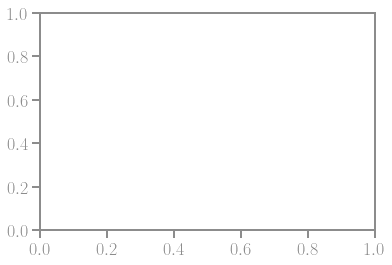

In [246]:
plt.axhline(0)


atk
1 - œÉ**2
atk {k: 2, E0: 1, w1: 1, ùìÅ: ùìÅ, L: 1}

at1
-œÉ*sqrt(œÉ**2 + 8)/4 - (œÉ - 2)*(œÉ + 2)/4
at1 {n: 1, L: 1, E0: 1, w1: 1, ùìÅ: ùìÅ}

pq
{p: 1, q: 1, E0: 1, L: 1, w1: 2, ùìÅ: ùìÅ, œÉ_c: 1}
1 - œÉ**2/2
pq {p: 1, q: 1, E0: 1, L: 1, w1: 2, ùìÅ: ùìÅ, œÉ_c: 1}


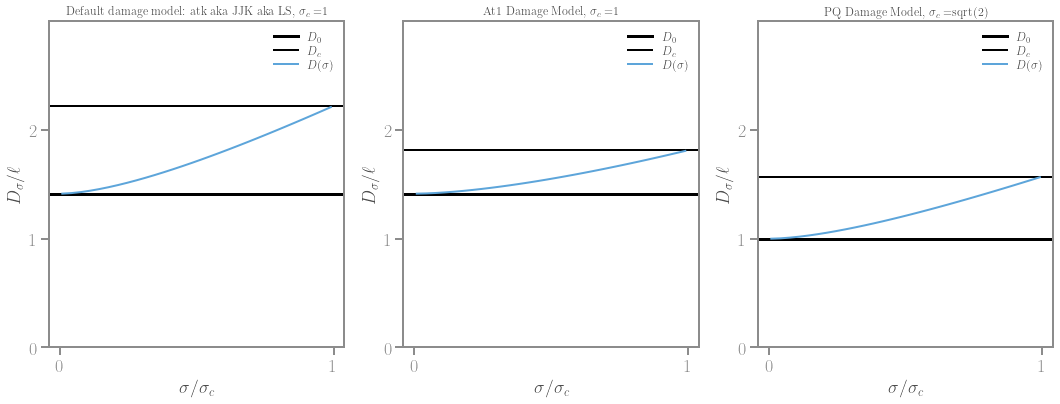

In [15]:
# D of sigma

figure, axis = plt.subplots(1, len(model_list), figsize=(18, 6))
i = 0

_Hs = []
for case, parameters in zip(model_list, parameters_list):
    # print(case.model.slug, parameters)
    print()
    print(case.model.slug)
    case.criterion()
    # sp.print_latex(case.crit)
    # _analyse_H()
    # sp.print_latex(case.max_Œ±(parameters))
    sol, idx = case.max_Œ±(parameters)
    print(sol[idx])
    sols.append(sol[idx])
    labs.append(f"{case.model.slug}-alpha-max")
    knowns.append("\\bar \\alpha=") 

    _H_subs = case._H_damage_profile().subs(parameters)    \
            .subs({_Œ≤: _Œ≥*_Œ±0})                             \
            .subs({_Œ±0: sol[idx]}).simplify()
            
    _Hs.append(_H_subs)
    print(case.model.slug, parameters)
    sol, idx = case.max_Œ±(parameters)

    _bar_H = case._H_damage_profile().subs(parameters)    \
        .subs({_Œ≤: _Œ≥*_Œ±0})                 \
        .subs({_Œ±0: sol[idx]}).simplify()


    _D = []
    _tol = 1e-2
    _œÉcrit = case._œÉc(parameters)
    _sigmas = np.linspace(.01, np.float64(_œÉcrit-_tol), 30)

    for œÉv in _sigmas:
        val = case._integrate_Dsigma(œÉv, _bar_H, matpar=parameters)
        _D.append(val[0])

    axis[i].axhline(case.D0(parameters)[0], c='k', lw=3, label='$D_0$')
    axis[i].axhline(case._Dc(parameters), c='k', label='$D_c$')
    axis[i].plot(_sigmas, _D, label='$D(\\sigma)$')
    axis[i].set_ylim(0, 3)
    axis[i].set_ylabel("$D_\\sigma/\\ell$")
    axis[i].set_xlabel("$\\sigma/\\sigma_c$")
    axis[i].set_title(f"{case.model}, $\\sigma_c=${_œÉcrit}")
    axis[i].legend()
    axis[i].set_xticks([0, _œÉcrit], ["0", "1"])
    axis[i].set_yticks([0, 1, 2], ["0", "1", "2"])

    i+=1



# num, den = sp.fraction(_Hs[0])




atk
1 - œÉ**2
atk {k: 2, E0: 1, w1: 1, ùìÅ: ùìÅ, L: 1}

at1
-œÉ*sqrt(œÉ**2 + 8)/4 - (œÉ - 2)*(œÉ + 2)/4
at1 {n: 1, L: 1, E0: 1, w1: 1, ùìÅ: ùìÅ}

pq
{p: 1, q: 1, E0: 1, L: 1, w1: 2, ùìÅ: ùìÅ, œÉ_c: 1}
1 - œÉ**2/2
pq {p: 1, q: 1, E0: 1, L: 1, w1: 2, ùìÅ: ùìÅ, œÉ_c: 1}


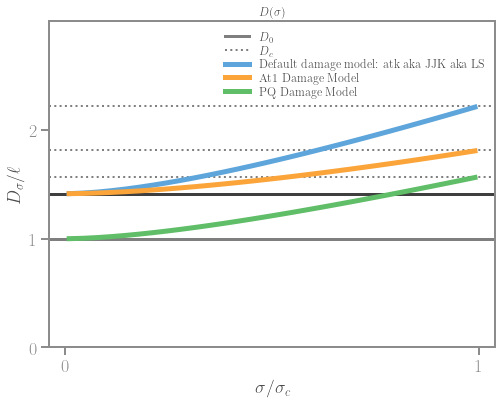

In [26]:
# D of sigma

figure, axis = plt.subplots(1,1, figsize=(8, 6))
i = 0

_Hs = []
for case, parameters in zip(model_list, parameters_list):
    # print(case.model.slug, parameters)
    print()
    print(case.model.slug)
    case.criterion()
    # sp.print_latex(case.crit)
    # _analyse_H()
    # sp.print_latex(case.max_Œ±(parameters))
    sol, idx = case.max_Œ±(parameters)
    print(sol[idx])
    sols.append(sol[idx])
    labs.append(f"{case.model.slug}-alpha-max")
    knowns.append("\\bar \\alpha=") 

    _H_subs = case._H_damage_profile().subs(parameters)    \
            .subs({_Œ≤: _Œ≥*_Œ±0})                             \
            .subs({_Œ±0: sol[idx]}).simplify()
            
    _Hs.append(_H_subs)
    print(case.model.slug, parameters)
    sol, idx = case.max_Œ±(parameters)

    _bar_H = case._H_damage_profile().subs(parameters)    \
        .subs({_Œ≤: _Œ≥*_Œ±0})                 \
        .subs({_Œ±0: sol[idx]}).simplify()


    _D = []
    _tol = 1e-2
    _œÉcrit = case._œÉc(parameters)
    # _sigmas = np.linspace(.01, np.float64(_œÉcrit-_tol), 30)
    _sigmas = np.linspace(.01, 1-_tol, 30)

    for œÉv in _sigmas:
        # print(np.float(_œÉcrit)*œÉv)
        # print(_œÉcrit*œÉv)
        val = case._integrate_Dsigma(_œÉcrit*œÉv, _bar_H, matpar=parameters)
        _D.append(val[0])

    if i == 0:
        axis.axhline(case.D0(parameters)[0], c='k', zorder=0, alpha =.5, lw=3, label='$D_0$')
        axis.axhline(case._Dc(parameters), ls='dotted', c='k', zorder=0, alpha =.5, label='$D_c$')
    else:
        axis.axhline(case.D0(parameters)[0], c='k', zorder=0, alpha =.5, lw=3)
        axis.axhline(case._Dc(parameters), ls='dotted', c='k', zorder=0, alpha =.5)

    axis.plot(_sigmas, _D, label=f'{case.model}', lw=5)
    axis.set_ylim(0, 3)
    axis.set_ylabel("$D_\\sigma/\\ell$")
    axis.set_xlabel("$\\sigma/\\sigma_c$")
    axis.set_title(f"$D(\\sigma)$")
    axis.legend()
    axis.set_xticks([0, 1], ["0", "1"])
    axis.set_yticks([0, 1, 2], ["0", "1", "2"])

    i+=1



# num, den = sp.fraction(_Hs[0])



#### bifurcatinos

In [27]:
figure.tight_layout()
figure.savefig("../../notes/figures/localisation-support-collapse-models.pdf")

Simplify bar H, model by model, by hand

In [228]:
# ATK

_t = sp.symbols('œÑ')

# sp.simplify(num).subs({_œÉ**2-1: _t})
atk_matpar = {k: 2, E0: 1, w1: 1, ùìÅ:ùìÅ, L: 1}
matpar = {k: k, E0: E0, w1: w1, ùìÅ:ùìÅ, L: L}

atk = DefaultDamage(state, matpar, slug=f"atk")
ana_atk = ModelAnalysis(atk)

sol, idx = ana_atk.max_Œ±(atk_matpar)

_H_subs = ana_atk._H_damage_profile().subs(atk_matpar)    \
        .subs({_Œ≤: _Œ≥*_Œ±0})                             \
        .subs({_Œ±0: sol[idx]}).simplify()
        
_Hs.append(_H_subs)

num, den = sp.fraction(_H_subs)
sp.simplify(num)

2*Œ≥*(œÉ**2 - 1)*(Œ≥*(œÉ**2 - 1) - œÉ**2 + 1)

In [221]:
_int_eps = (_H_subs*sol[idx]).simplify()
_int_eps

2*Œ≥*(œÉ**2 - 1)**2*(Œ≥*(œÉ**2 - 1) - œÉ**2 + 1)/(Œ≥*(œÉ**2 - 1) + 1)

In [229]:
ana_atk._œÉc(atk_matpar)

1

In [241]:
ana_atk.D0(atk_matpar), ana_atk._Dc(atk_matpar)

((1.414213562373096, 7.549516567451064e-15), 1.5707963267949*sqrt(2))

In [232]:
_sigma0 = ana_atk._œÉc(atk_matpar)
np.pi * sp.sqrt(2*E0/(_sigma0**2 * ana_atk._spp - 2*ana_atk._wpp)).subs({Œ±:0}).subs(atk_matpar)

1.5707963267949*sqrt(2)

In [222]:
_int_eps.subs({_œÉ: 0}).simplify()

2*Œ≥

In [ ]:
_int_eps.subs({_œÉ: 0}).simplify()

In [210]:
ana_atk._s

((k - 1)*Œ±(x) + 1)/(1 - Œ±(x))

In [211]:
sol[idx]

1 - œÉ**2

In [212]:
ana_atk._H_damage_profile().subs(atk_matpar)

2*Œ≤ - œÉ**2*(-1 + (Œ≤ + 1)/(1 - Œ≤))

In [213]:
_H_subs

2*Œ≥*(œÉ**2 - 1)*(Œ≥*(œÉ**2 - 1) - œÉ**2 + 1)/(-Œ≥*(œÉ**2 - 1) - 1)

In [215]:
str(sp.latex(_H_subs)) \
        .replace("Œ±", "\\alpha") \
        .replace("Œ≤", "\\beta") \
        .replace("Œ≥", "\\gamma") \
        .replace("œÉ", "\\sigma") \
        .replace("œÑ", "\\tau")

'\\frac{2 \\gamma \\left(\\sigma^{2} - 1\\right) \\left(\\gamma \\left(\\sigma^{2} - 1\\right) - \\sigma^{2} + 1\\right)}{- \\gamma \\left(\\sigma^{2} - 1\\right) - 1}'

In [216]:
sp.simplify(num)

2*Œ≥*(œÉ**2 - 1)*(Œ≥*(œÉ**2 - 1) - œÉ**2 + 1)

In [217]:
sp.simplify(den)

-Œ≥*œÉ**2 + Œ≥ - 1

In [218]:
s_num = sp.simplify(num).subs({_œÉ**2-1: _t})
s_num,

(2*Œ≥*œÑ*(Œ≥*œÑ - œÑ),)

In [219]:
ss_num = 2*_Œ≥*_t*(_Œ≥*_t - _t)
ss_num

2*Œ≥*œÑ*(Œ≥*œÑ - œÑ)

In [220]:
s_den = den.subs({_œÉ**2-1: _t})
s_den

-Œ≥*œÑ - 1

In [221]:
_bar_h_atk = (ss_num/s_den).simplify()
str(sp.latex(_bar_h_atk)) \
        .replace("Œ±", "\\alpha") \
        .replace("Œ≤", "\\beta") \
        .replace("Œ≥", "\\gamma") \
        .replace("œÉ", "\\sigma") \
        .replace("œÑ", "\\tau")



'\\frac{2 \\gamma \\tau^{2} \\cdot \\left(1 - \\gamma\\right)}{\\gamma \\tau + 1}'

In [222]:
_bar_h_atk

2*Œ≥*œÑ**2*(1 - Œ≥)/(Œ≥*œÑ + 1)

In [223]:
_H_subs

2*Œ≥*(œÉ**2 - 1)*(Œ≥*(œÉ**2 - 1) - œÉ**2 + 1)/(-Œ≥*(œÉ**2 - 1) - 1)

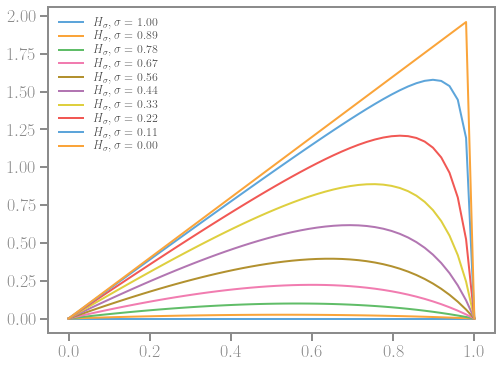

In [224]:
figure, axis = plt.subplots(1, 1, figsize=(8, 6))

_tol = 1e-3
for sigmav in np.linspace(1 - _tol, 0 + _tol, 10):
    _fc = sp.lambdify(_Œ≥, _H_subs.subs({_œÉ: sigmav}), "numpy")

#     # _hprimeSf
    axis.plot(_damage, [(_fc(Œ≥)) for Œ≥ in _damage], \
              label = f"$H_\\sigma, \\sigma = $ {sigmav:.2f}")
            #   """, $\\alpha_0 = $ {_sol[1][0]:.2f}")

axis.legend()  

In [225]:
figure.tight_layout()
figure.savefig("../../notes/figures/atk-model-barH.pdf")

In [235]:
# ATN N=1

matpar = {n: 1, E0: 1, w1: 1, ùìÅ:ùìÅ}
at1_matpar = {n: 1, L: 1, E0: 1, w1: 1, ùìÅ:ùìÅ}

at1 = DamageATn(state, matpar=at1_matpar,
                name="At1 Damage Model",
                slug=f"at1")
ana_at1 = ModelAnalysis(model = at1)

sol, idx = ana_at1.max_Œ±(at1_matpar)


_H_subs = ana_at1._H_damage_profile().subs(at1_matpar)    \
        .subs({_Œ≤: _Œ≥*_Œ±0})                             \
        .subs({_Œ±0: sol[idx]}).simplify()
        
# _Hs.append(_H_subs)

num, den = sp.fraction(_H_subs)


In [236]:
_H_subs


-Œ≥*œÉ**2/2 - Œ≥*œÉ*sqrt(œÉ**2 + 8)/2 + 2*Œ≥ + œÉ**2 - 16*œÉ**2/(Œ≥*œÉ**2 + Œ≥*œÉ*sqrt(œÉ**2 + 8) - 4*Œ≥ + 4)**2

In [237]:
sp.collect(_H_subs, _œÉ)

-Œ≥*œÉ*sqrt(œÉ**2 + 8)/2 + 2*Œ≥ + œÉ**2*(-Œ≥/2 + 1 - 16/(Œ≥*œÉ**2 + Œ≥*œÉ*sqrt(œÉ**2 + 8) - 4*Œ≥ + 4)**2)

In [251]:
sp.collect(_H_subs, _Œ≥),

(Œ≥*(-œÉ**2/2 - œÉ*sqrt(œÉ**2 + 8)/2 + 2) + œÉ**2 - 16*œÉ**2/(Œ≥*(œÉ**2 + œÉ*sqrt(œÉ**2 + 8) - 4) + 4)**2,)

In [244]:
num, den = sp.fraction(16*_œÉ**2/(_Œ≥*(_œÉ**2 + _œÉ*sp.sqrt(_œÉ**2 + 8) - 4) + 4)**2)

In [250]:
sp.simplify(den)

(Œ≥*(œÉ**2 + œÉ*sqrt(œÉ**2 + 8) - 4) + 4)**2

In [239]:
sp.simplify(_H_subs)

-Œ≥*œÉ**2/2 - Œ≥*œÉ*sqrt(œÉ**2 + 8)/2 + 2*Œ≥ + œÉ**2 - 16*œÉ**2/(Œ≥*œÉ**2 + Œ≥*œÉ*sqrt(œÉ**2 + 8) - 4*Œ≥ + 4)**2

In [227]:
num

-2*Œ≥*œÉ**2 + 2*Œ≥ + œÉ**2 - œÉ**2/(Œ≥*œÉ**2 - Œ≥ + 1)**2

In [228]:
den

1

In [637]:
_fcs = []
_lab = []
_known = []

for case, parameters in zip(model_list, parameters_list):
    # print(case.model.slug, parameters)
    print(case.model.slug)
    _H_subs = case._H_damage_profile().subs(parameters)    \
        .subs({_Œ≤: _Œ≥*_Œ±0})                             \
        .subs({_Œ±0: sol[idx]}).simplify()
        
    _hprime = sp.diff(_H_subs, _Œ≥)
    _f = _hprime.collect(_Œ≥).subs({_Œ≥: 0}).simplify()
    _fcs.append(_f)
    _lab.append(f"{case.model.slug}-Hprimezero")
    _known.append(f"\\text{{ {case.model.slug } }}\\quad \\bar H'_\\sigma(0)=")

    _f = _hprime.collect(_Œ≥).subs({_Œ≥: 1}).simplify()
    _fcs.append(_f)
    _lab.append(f"{case.model.slug}-Hprimeone")
    _known.append(f"\\text{{ {case.model.slug } }}\\quad \\bar H'_\\sigma(1)=")

_fname = f"Hprime-models.txt"

out_file = open(_fname,"w")

for y in zip(_fcs, _lab, _known):
    _tex = y[2] + str(sp.latex(y[0])) \
        .replace("Œ±", "\\alpha") \
        .replace("Œ≤", "\\beta") \
        .replace("Œ≥", "\\gamma") \
        .replace("œÉ", "\\sigma")
    out_file.write("\\begin{equation}")
    out_file.write(f"\\label{{ eqn:{y[1]} }}")
    out_file.write(_tex)
    out_file.write("\\end{equation}")
    out_file.write("\n")

out_file.close()


atk
at1
pq


atk
at1
pq


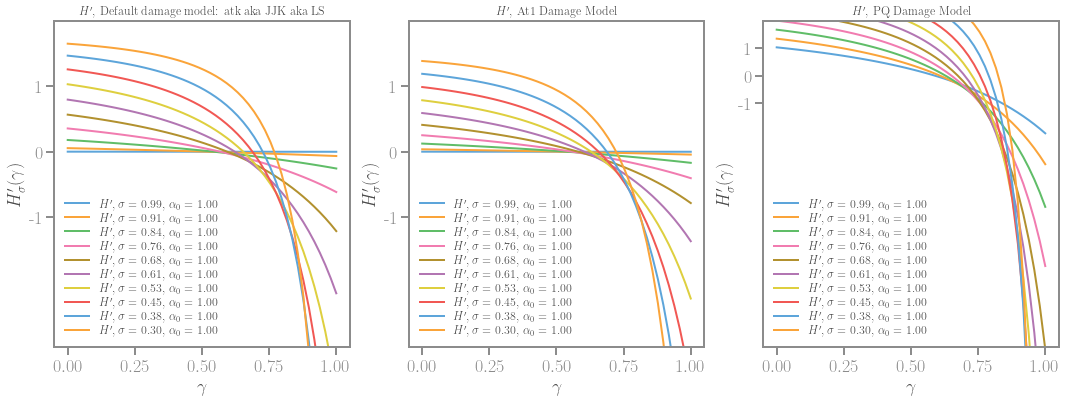

In [252]:


figure, axis = plt.subplots(1, len(model_list), figsize=(18, 6))
i = 0
for case, parameters in zip(model_list, parameters_list):
    # print(case.model.slug, parameters)
    print(case.model.slug)
    sol, idx = case.max_Œ±(parameters)
    _HœÉŒ≤ = case._H_damage_profile().subs(parameters).subs({_Œ≤: _Œ≥*_Œ±0})     \
        .subs({_Œ±0: sol[idx]}).simplify()
    _hprime = sp.diff(_HœÉŒ≤, _Œ≥)
    
    for sigmav in np.linspace(.99, .3, 10):
        _HŒ≤ = _HœÉŒ≤.subs({_œÉ: sigmav})
        _hprimeS = _hprime.subs({_œÉ: sigmav})
        
        _hprimeSf = sp.lambdify(_Œ≥, _hprimeS, "numpy")

    #     # _hprimeSf
        axis[i].plot(_damage, [_hprimeSf(Œ≤) for Œ≤ in _damage], label = f"$H', \\sigma =$ {sigmav:.2f}, $\\alpha_0 = $ {_sol[1][0]:.2f}")
        # axis.plot(_damage, [_HŒ≤f(Œ≤) for Œ≤ in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
        # axis.axvline(Œ±max, c='k', lw=.1)


        axis[i].set_ylabel("$H'_\\sigma(\\gamma)$")
        axis[i].set_xlabel("$\\gamma$")
        axis[i].set_title(f"$H'$, {case.model}")
        axis[i].legend()
        # axis[i].axhline(0, c="k")
        axis[i].set_yticks([-1, 0, 1], ["-1", "0", "1"])
        axis[i].set_ylim(-3, 2)


    axis[2].set_ylim(-10, 2)


    i += 1

In [253]:
figure.tight_layout()
figure.savefig("../../notes/figures/Hprime-models.pdf")

In [439]:
%%capture

state = {u: u, Œ±: Œ±}

# ATK
atk_matpar = {k: 2, E0: 1, w1: 1, ùìÅ:ùìÅ, L: 1}
matpar = {k: k, E0: E0, w1: w1, ùìÅ:ùìÅ, L: L}

atk = DefaultDamage(state, matpar, slug=f"atk")
ana_atk = ModelAnalysis(atk)
ana_atk.criterion()
# _analyse_H(ana_atk)

# ATN

matpar = {n: 1, E0: 1, w1: 1, ùìÅ:ùìÅ}
at1_matpar = {n: 1, L: 1, E0: 1, w1: 1, ùìÅ:ùìÅ}

at1 = DamageATn(state, matpar={n: 1, E0: E0, w1: w1, ùìÅ:ùìÅ, L: L},
                name="At1 Damage Model",
                slug=f"at1")
ana_at1 = ModelAnalysis(model = at1)
ana_at1.criterion()
# _analyse_H(ana_at1)

# PQ

p, q, E0, L, w1, ùìÅ, œÉc = sp.symbols('p q E0 L w1 ùìÅ œÉ_c')

matpar = {p: p, q: q, E0: E0, L: L, w1: w1, ùìÅ:ùìÅ, œÉc: œÉc}
pq_matpar = {p: 1, q: 1, E0: 1, L: 1, w1: 2, ùìÅ:ùìÅ, œÉc: 1}

dpq = DamagePQ(state, matpar=matpar,
               name="PQ Damage Model",
               slug = "pq")
ana_pq = ModelAnalysis(model = dpq)
ana_pq.criterion()
# _analyse_H(ana_pq)






# -----------




In [534]:

for case, parameters in zip(model_list, parameters_list):
    # print(case.model.slug, parameters)
    print(case.model.slug)
    print()
    case.criterion()
    # sp.print_latex(case.crit)
    # _analyse_H()
    # sp.print_latex(case.max_Œ±(parameters))
    sol, idx = case.max_Œ±(parameters)
    print(sol[idx])
    sols.append(sol[idx])
    labs.append(f"{case.model.slug}-alpha-max")
    knowns.append("\\bar \\alpha=") 


_fname = f"alpha-max-models.txt"

out_file = open(_fname,"w")

for y in zip(sols, labs, knowns):
    # print(str(sp.latex(y[0])))
    _tex = y[2] + str(sp.latex(y[0])) \
        .replace("Œ±", "\\alpha") \
        .replace("Œ≤", "\\beta") \
        .replace("Œ≥", "\\gamma") \
        .replace("œÉ", "\\sigma")
    print(_tex)
    out_file.write("\\begin{equation}")
    out_file.write(f"\\label{{ eqn:{y[1]} }}")
    out_file.write(_tex)
    out_file.write("\\end{equation}")
    out_file.write("\n")

# -----------
# print( sols, labs, knowns)



atk

1 - œÉ**2
at1

-œÉ*sqrt(œÉ**2 + 8)/4 - (œÉ - 2)*(œÉ + 2)/4
pq

1 - œÉ**2/2
\bar \alpha=1 - \sigma^{2}
\bar \alpha=- \frac{\sigma \sqrt{\sigma^{2} + 8}}{4} - \frac{\left(\sigma - 2\right) \left(\sigma + 2\right)}{4}
\bar \alpha=1 - \frac{\sigma^{2}}{2}


In [20]:
ana.model.slug

'atk'

In [44]:
# _Dnot = 

integrand = (((2*ana._w)/E0)**(1/2)).subs({Œ±: _Œ≥}).subs(_matpar) 
integrand


_fv = sp.lambdify(_Œ≥, integrand, "numpy")


_integ.quad(_fv, 0, 1)


ana.D0(atk_matpar)

# _i = (((2*ana._w)/E0)**(1/2)).subs({Œ±: _Œ≥}).subs(atk_matpar) 
# _i


(0.9428090415820666, 1.046728305789187e-15)

In [265]:
_integ

<module 'scipy.integrate' from '/opt/homebrew/lib/python3.9/site-packages/scipy/integrate/__init__.py'>

In [586]:
_fcs = []
_lab = []
_known = []

for case, parameters in zip(model_list, parameters_list):
    sol, idx = case.max_Œ±(parameters)
    print(sol[idx].simplify())

    _fcs.append(parameters)
    _lab.append(f"{case.model.slug}-parameters")
    _known.append(f"\\text{{ {case.model.slug} parameters}}=")

_fname = f"parameters-models.txt"

out_file = open(_fname,"w")

for y in zip(_fcs, _lab, _known):
    _tex = y[2] + str(sp.latex(y[0])) \
        .replace("Œ±", "\\alpha") \
        .replace("Œ≤", "\\beta") \
        .replace("Œ≥", "\\gamma") \
        .replace("ùìÅ", "\\ell") \
        .replace("œÉ", "\\sigma")
    out_file.write("\\begin{equation}")
    out_file.write(f"\\label{{ eqn:{y[1]} }}")
    out_file.write(_tex)
    out_file.write("\\end{equation}")
    out_file.write("\n")

out_file.close()

1 - œÉ**2
-œÉ**2/4 - œÉ*sqrt(œÉ**2 + 8)/4 + 1
1 - œÉ**2/2


In [582]:
_fcs = []
_lab = []
_known = []

for case, parameters in zip(model_list, parameters_list):
    sol, idx = case.max_Œ±(parameters)
    print(sol[idx].simplify())

    _H_subs = case._H_damage_profile().subs(parameters)    \
        .subs({_Œ≤: _Œ≥*_Œ±0})                             
    # print(_H_subs.simplify())
    _HœÉŒ≥ = _H_subs.simplify()
    # _HœÉŒ≥
    _fcs.append(_HœÉŒ≥.collect(_Œ≥))
    _lab.append(f"{case.model.slug}-Himplicit")
    _known.append("H_\\sigma(\\gamma)=")
# _fcs
# # _HœÉŒ≥

# # __h[2]
# _fcs, _lab, _known

_fname = f"Himplicit-models.txt"

out_file = open(_fname,"w")

for y in zip(_fcs, _lab, _known):
    _tex = y[2] + str(sp.latex(y[0])) \
        .replace("Œ±", "\\alpha") \
        .replace("Œ≤", "\\beta") \
        .replace("Œ≥", "\\gamma") \
        .replace("œÉ", "\\sigma")
    out_file.write("\\begin{equation}")
    out_file.write(f"\\label{{ eqn:{y[1]} }}")
    out_file.write(_tex)
    out_file.write("\\end{equation}")
    out_file.write("\n")

out_file.close()


1 - œÉ**2
-œÉ**2/4 - œÉ*sqrt(œÉ**2 + 8)/4 + 1
1 - œÉ**2/2


In [581]:
_fcs = []
_lab = []
_known = []

for case, parameters in zip(model_list, parameters_list):
    sol, idx = case.max_Œ±(parameters)
    # print(sol[idx].simplify())

    _H_subs = case._H_damage_profile().subs(parameters)    \
        .subs({_Œ≤: _Œ≥*_Œ±0})                             \
        .subs({_Œ±0: sol[idx]})
    # print(_H_subs.simplify())
    _HœÉŒ≥ = _H_subs.simplify()
    # _HœÉŒ≥
    _fcs.append(_HœÉŒ≥.collect(_Œ≥))
    _lab.append(f"{case.model.slug}-Hexplicit")
    _known.append("\\bar H_\\sigma(\\gamma)=")

# _HœÉŒ≥

# __h[2]
_fcs, _lab, _known

_fname = f"Hexplicit-models.txt"

out_file = open(_fname,"w")

for y in zip(_fcs, _lab, _known):
    _tex = y[2] + str(sp.latex(y[0])) \
        .replace("Œ±", "\\alpha") \
        .replace("Œ≤", "\\beta") \
        .replace("Œ≥", "\\gamma") \
        .replace("œÉ", "\\sigma")
    out_file.write("\\begin{equation}")
    out_file.write(f"\\label{{ eqn:{y[1]} }}")
    out_file.write(_tex)
    out_file.write("\\end{equation}")
    out_file.write("\n")

out_file.close()


deformation of localised

Text(0.5, 1.0, 'localised deformation ')

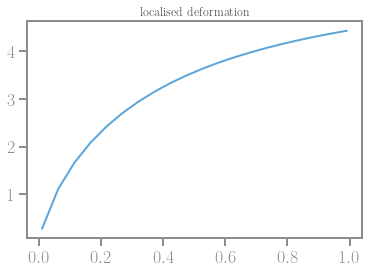

In [71]:
# ATK

_t = sp.symbols('œÑ')

# sp.simplify(num).subs({_œÉ**2-1: _t})
atk_matpar = {k: 2, E0: 1, w1: 1, ùìÅ:ùìÅ, L: 1}
matpar = {k: k, E0: E0, w1: w1, ùìÅ:ùìÅ, L: L}

atk = DefaultDamage(state, matpar, slug=f"atk")
ana_atk = ModelAnalysis(atk)

sol, idx = ana_atk.max_Œ±(atk_matpar)

_H_subs = ana_atk._H_damage_profile().subs(atk_matpar)    \
        .subs({_Œ≤: _Œ≥*_Œ±0})                             \
        .subs({_Œ±0: sol[idx]}).simplify()

_H_subs

def _localised_deformation(œÉv):
    
    _integrand = 2*((ana._s - 1/E0)*_H_subs**(-1/2))         \
            .subs({Œ±: _Œ≥*_Œ±0})                             \
            .subs(atk_matpar)                              \
            .subs({_Œ±0: sol[idx]}).simplify()
    
    _fv = sp.lambdify(_Œ≥, (_integrand.subs({_œÉ: œÉv})), "numpy")
    return _integ.quad(_fv, 0, 1)


# _integrand.subs({_œÉ: .9})


_sigmas = np.linspace(.01, .99, 20)
# _sigmas = np.linspace(.99, .01, 20)

# _localised_deformation(.9)
plt.plot(_sigmas, [œÉv*_localised_deformation(œÉv)[0] for œÉv in _sigmas])
# plt.ylim(0, 20) 
# plt.semilogy()
plt.title('localised deformation ')



ATk

In [36]:


state = {u: u, Œ±: Œ±}
_matpar = {k: 2, E0: 1, w1: 1, ùìÅ:ùìÅ, L: 1}
matpar = {k: k, E0: 1, w1: w1, ùìÅ:ùìÅ, L: L}

_u0 = t*x/L
_alpha0 = 0 

atk = DefaultDamage(state, _matpar)


ana = ModelAnalysis(atk)
_crit = sp.diff(atk.energy(state), Œ±).subs({u: _u0, Œ±: _alpha0}).simplify()
_crit

# atk = DefaultDamage(state, matpar)
ana = ModelAnalysis(atk)
ana.criterion()
ana.critical_load(matpar=_matpar)
# ana.set_critical_load(ana.critical_load_N(_matpar)[0][0])
# ana._critical_load
ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])


L


({u(x): t*x/L, Œ±(x): Piecewise(((-L + t)/L, L <= t), (0, True))},
 (<function _lambdifygenerated(t, x)>, <function _lambdifygenerated(t)>))

In [37]:
ana.criterion()


1 - 1.0*t**2/L**2

In [62]:
atk_matpar = _matpar

In [42]:
case = ana

sol, idx = case.max_Œ±(atk_matpar)

# _H_subs = case._H_damage_profile().subs(atk_matpar)    \
#         .subs({_Œ≤: _Œ≥*_Œ±0})                             \
#         .subs({_Œ±0: sol[idx]}).simplify()
        
# _Hs.append(_H_subs)
print(case.model.slug, atk_matpar)

# _bar_H = case._H_damage_profile().subs(atk_matpar)    \
#     .subs({_Œ≤: _Œ≥*_Œ±0})                 \
#     .subs({_Œ±0: sol[idx]}).simplify()

_D = []
_tol = 1e-2
_œÉcrit = case._œÉc(atk_matpar)
# _sigmas = np.linspace(.01, np.float64(_œÉcrit-_tol), 30)
_sigmas = np.linspace(.01, 1-_tol, 30)

for œÉv in _sigmas:
#     # print(np.float(_œÉcrit)*œÉv)
#     # print(_œÉcrit*œÉv)
    val = case._integrate_Dsigma(_œÉcrit*œÉv, matpar=atk_matpar)
    _D.append(val[0])

data = {"D": _D, "œÉ": _sigmas}


atk {k: 2, E0: 1, w1: 1, ùìÅ: ùìÅ, L: 1}


In [101]:
_Ebif = []
_tol = 1e-2
_œÉcrit = case._œÉc(atk_matpar)
# _sigmas = np.linspace(.01, np.float64(_œÉcrit-_tol), 30)
_sigmas = np.linspace(.01, 1-_tol, 30)

for œÉv in _sigmas:
    _œÉ_adim = œÉv/_œÉcrit

    val = case._integrate_Dsigma(_œÉ_adim, matpar=atk_matpar)[0]
    _Ebif.append(val)

data = {"Ebif": _Ebif, "œÉ": _sigmas}


In [102]:
data

{'Ebif': [1.414601880578202,
  1.4196611348780024,
  1.42889486528967,
  1.441343444401598,
  1.456446629679949,
  1.4738138692402396,
  1.4931507036825993,
  1.5142247268845133,
  1.536846851257082,
  1.5608598406559124,
  1.5861307649392118,
  1.6125457670874896,
  1.640006286408238,
  1.6684262460002857,
  1.6977299048411547,
  1.7278501831289452,
  1.7587273338134826,
  1.7903078731198534,
  1.8225437086614995,
  1.8553914207419369,
  1.8888116642330601,
  1.9227686665014265,
  1.9572298027331216,
  1.9921652342753868,
  2.027547598697628,
  2.063351742714564,
  2.0995544908085457,
  2.1361344438466863,
  2.173071803066115,
  2.2103482155334926],
 'œÉ': array([0.01      , 0.0437931 , 0.07758621, 0.11137931, 0.14517241,
        0.17896552, 0.21275862, 0.24655172, 0.28034483, 0.31413793,
        0.34793103, 0.38172414, 0.41551724, 0.44931034, 0.48310345,
        0.51689655, 0.55068966, 0.58448276, 0.61827586, 0.65206897,
        0.68586207, 0.71965517, 0.75344828, 0.78724138, 0.82103

In [105]:
case._wpp

0

In [117]:
case._œÉc({})

sqrt(2)*sqrt(1/k)

In [113]:
def _dŒµb_dœÉ_critical(model, matpar = {}):
    num = (model._sp)**2 * model._œÉc(matpar)**2 * (E0)**(1/2)
    den = (model._spp * model._œÉc(matpar)**2 - model._wpp)**(3/2)

    # num = num.subs({Œ±: 0}).subs(matpar)
    # den = den.subs({Œ±: 0}).subs(matpar)
    _coef = np.pi * 2 **(5/2)
    return ((num / den).simplify(), _coef)



derivative = _dŒµb_dœÉ_critical(case, matpar = atk_matpar)
derivative = _dŒµb_dœÉ_critical(case, matpar = {})

derivative[0]

0.25*E0**0.5*k/((-1/(Œ±(x)**3 - 3*Œ±(x)**2 + 3*Œ±(x) - 1))**1.5*(1.0*Œ±(x)**4 - 4.0*Œ±(x)**3 + 6.0*Œ±(x)**2 - 4.0*Œ±(x) + 1.0))

In [91]:
# Macro response
# 1. 1st order
# 2. 2nd order


# def Œµ(œÉ, E, ŒΩ):
#     return œÉ / E - ŒΩ * œÉ / E

_sigmas = np.linspace(1-_tol, .01, 30)

def Œµ(œÉv, model, n = 1, matpar = {}):
    _ùìÅ = matpar[ùìÅ]
    _œÉcrit = model._œÉc(matpar)
    _œÉ_adim = _œÉcrit*œÉv

    Œµel = (_œÉ_adim / E0).subs(matpar)
    Œµb = 2 * _œÉ_adim * n * (_ùìÅ*L).subs(matpar) * case._integrate_Dsigma(_œÉ_adim, matpar=matpar)[0]
    
    return (Œµel, Œµb)

Œµel = []
Œµb = []

for œÉv in _sigmas:
    (_Œµel, _Œµb) = Œµ(œÉv, ana, n = 1, matpar = atk_matpar)
    Œµel.append(_Œµel)
    Œµb.append(_Œµb)

Œµel = np.array(Œµel)
Œµb = np.array(Œµb)




In [92]:
Œµb

array([0.437648946675632, 0.415581248958782, 0.394079974985505,
       0.373141511918181, 0.352761997944093, 0.332937298793038,
       0.313662981369014, 0.294934284067026, 0.276746083240585,
       0.259092855183418, 0.241968632870552, 0.225366956526212,
       0.209280816892286, 0.193702589800007, 0.178623960311054,
       0.164035834253963, 0.149928234381957, 0.136290177594616,
       0.123109528563162, 0.110372823574046, 0.0980650561956915,
       0.0861694131084143, 0.0746669434291329, 0.0635361368394596,
       0.0527523722852196, 0.0422871745582937, 0.0321071677614977,
       0.0221725065303575, 0.0124342733882418, 0.00282920376115640],
      dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 2.0)

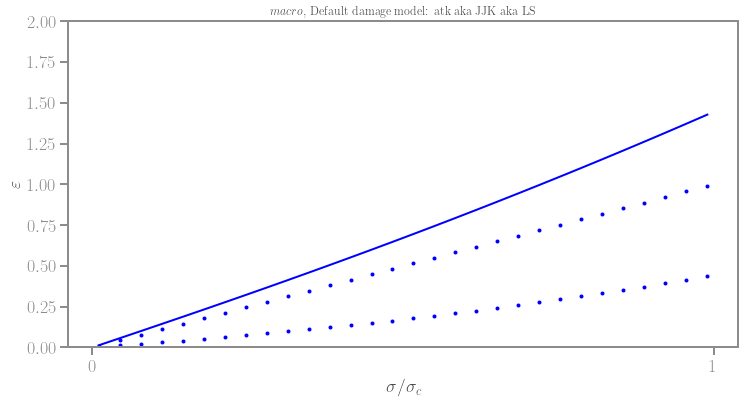

In [99]:
figure, axis = plt.subplots(1, 1, figsize=(12, 6))

axis.plot(_sigmas, Œµel, 'b.')
axis.plot(_sigmas, Œµb, 'b.')
axis.plot(_sigmas, Œµel+Œµb, 'b')


axis.set_ylabel("$\\varepsilon$")
axis.set_xlabel("$\\sigma/\\sigma_c$")
axis.set_title(f"$macro$, {case.model}")
axis.legend()
# axis.axhline(0, c="k")
# axis.set_yticks([0, 1], ["-1", "0", "1"])
axis.set_xticks([0, 1], ["0", "1"])
axis.set_ylim(0, 2)


In [ ]:
(_ùìÅ/L).subs(atk_matpar)

NameError: name '_l' is not defined

<lambdifygenerated-1747>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.9801 - 0.9801/(1 - Œ≤)**2
<lambdifygenerated-1748>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.814004938271605 - 0.814004938271605/(1 - Œ≤)**2
<lambdifygenerated-1749>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.66331975308642 - 0.66331975308642/(1 - Œ≤)**2
<lambdifygenerated-1750>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.528044444444444 - 0.528044444444444/(1 - Œ≤)**2
<lambdifygenerated-1751>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.408179012345679 - 0.408179012345679/(1 - Œ≤)**2
<lambdifygenerated-1752>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*Œ≤ + 0.303723456790123 - 0.303723456790123/(1 - Œ≤)**2
<lambdifygenerated-1753>:2: RuntimeWarning: divide by zero encountered in double_scalars
  ret

Text(0.5, 1.0, 'At1 Damage Model')

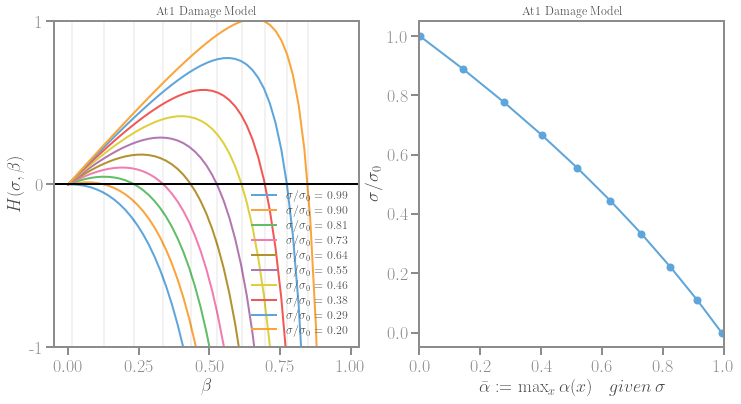

In [801]:
_HœÉŒ≤ = ana._H_damage_profile().subs(_matpar)

_œÉ = sp.symbols('œÉ')
_Œ≤ = sp.symbols('Œ≤')

figure, axis = plt.subplots(1, 2, figsize=(12, 6))


for k in np.linspace(.99, .2, 10):
# for k in np.arange(2, 5):
    _HŒ≤ = _HœÉŒ≤.subs({_œÉ: k})
    # _HŒ≤ = _HœÉŒ≤.subs({_œÉ: 1./k})
    _HŒ≤f = sp.lambdify(_Œ≤, _HŒ≤, "numpy")
    _sol = sp.solve(_HŒ≤, _Œ≤, (0, 1), solver='bisect') 
    Œ±max = _sol[1][0]
    axis[0].plot(_damage, [_HŒ≤f(Œ≤) for Œ≤ in _damage], label = f"$\sigma/\sigma_0$  = {k:.2f}")
    # axis[0].plot(_damage, [_HŒ≤f(Œ≤) for Œ≤ in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    axis[0].axvline(Œ±max, c='k', lw=.1)

axis[0].set_ylabel("$H(\\sigma, \\beta)$")
axis[0].set_xlabel("$\\beta$")
axis[0].set_title(f"{ana.model}")
axis[0].legend()
axis[0].axhline(0, c="k")
axis[0].set_yticks([-1, 0, 1], ["-1", "0", "1"])
axis[0].set_ylim(-1, 1)


amax = []
for i in np.linspace(.999, .01, 10):
    amax.append(ana._Œ±_max(i, _matpar))

axis[1].plot(amax, np.linspace(1, .0, 10), marker='o')
axis[1].set_xlabel('$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\, \\sigma$')
axis[1].set_ylabel('$\\sigma/\\sigma_0$')
axis[1].set_xlim(0., 1.)
axis[1].set_title(f"{ana.model}")


In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/pq-Hbeta.pdf")

In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/pq-maxalpha.pdf")

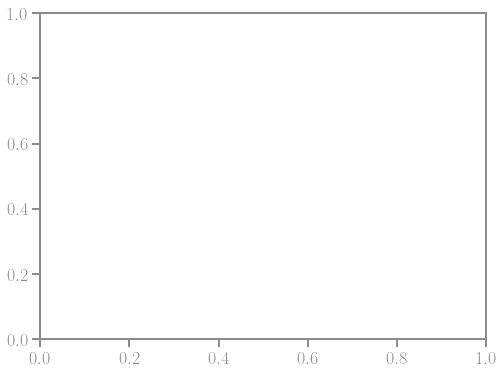

In [802]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


_en_h = sp.lambdify(t, at1.energy(_homog_state).subs({Œ±: _homog_state[Œ±]}).subs(_matpar), "numpy")
_en_dam_h = sp.lambdify(t, at1._damage(_homog_state).subs({Œ±: _homog_state[Œ±]}).subs(_matpar), "numpy")
_en_ela_h = sp.lambdify(t, at1._elastic(_homog_state).subs({Œ±: _homog_state[Œ±]}).subs(_matpar), "numpy")

axis.plot(np.linspace(0., 3.), [_en_h(t) for t in np.linspace(0., 3.)], c="C0", label = "total")
axis.plot(np.linspace(0., 3.), [_en_dam_h(t) for t in np.linspace(0., 3.)], c="C1", label = "damage")
axis.plot(np.linspace(0., 3.), [_en_ela_h(t) for t in np.linspace(0., 3.)], c="C2", label = "elastic")
axis.axvline(np.float64(tc), c='k', lw=.1)
axis.legend()


axis.set_ylim(-0.1, 2.1)
axis.set_xticks([0, tc, 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$t$")
axis.set_ylabel("$E$")
axis.set_title(f"{ana.model}")


In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/pq-energies-homog.pdf")

In [ ]:
_œÉ = sp.symbols('œÉ')
_Œ≤ = sp.symbols('Œ≤')
sigmav = .8

_f = ((ana._s - 1/E0).subs({Œ±: _Œ≤}) * 1/sp.sqrt(ana._H_damage_profile()))    \
    .subs(ana.model.matpar)                                                \
    .subs({_œÉ: sigmav, ùìÅ: .1})
_fvŒ≤ = sp.lambdify(_Œ≤, _f, "numpy")


# _Œ±_max = ana._Œ±_max(sigmav)
# 
# print(_Œ±_max.subs(ana.model.matpar))

_x = np.linspace(0.1, .3)
_fvŒ≤(_x)
plt.plot(_fvŒ≤(_x), _x, marker='o')


# np

PQ

In [ ]:
p, q, E0, L, w1, ùìÅ, œÉc = sp.symbols('p q E0 L w1 ùìÅ œÉ_c')


state = {u: u, Œ±: Œ±}
_matpar = {k: 2, E0: 1, w1: 1, ùìÅ:ùìÅ, L: 1, p: 2, q: 2, œÉc: 1}
matpar = {k: k, E0: 1, w1: w1, ùìÅ:ùìÅ, L: L}

_u0 = t*x/L
_alpha0 = 0 

dpq = DamagePQ(state, matpar={}, name="pq")


ana = ModelAnalysis(dpq)
_crit = sp.diff(dpq.energy(state), Œ±).subs({u: _u0, Œ±: _alpha0}).simplify()
_crit

# dpq = DefaultDamage(state, matpar)
ana = ModelAnalysis(dpq)
ana.criterion()
# ana.set_critical_load(ana.critical_load_N(_matpar)[0][0])
# ana._critical_load
# ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])


In [ ]:
sp.solve(ana.crit, t**2)

In [ ]:
ana.crit

In [ ]:
sp.solve(ana.crit, t**2)

In [ ]:
sp.solve(ana.crit, t**2)

In [ ]:
ana.model._matpar

In [ ]:
_eq = sp.diff(ana.model.energy(state), Œ±) \
                .subs({u: _u0, Œ±: Œ±})         \
                .simplify().subs(_matpar)

_ah = sp.solve(_eq, Œ±)

In [ ]:
ana._homogeneous_alpha(matpar = _matpar)

In [ ]:
_u0

In [ ]:
_eq = sp.diff(dpq.energy(state), Œ±) \
    .subs({u: _u0, Œ±: Œ±}) \
    .simplify().subs(_matpar)

_ah = sp.solve(_eq, Œ±)


_ah_f = [sp.lambdify(t, a.subs(_matpar), "numpy") for a in _ah]

# _ahp = sp.lambdify(t, _ah_sub[0].subs(_matpar), "numpy")

_times = np.linspace(0., 3)

for _i, _a in enumerate(_ah_f):
    plt.plot(_times, [_a(t) for t in _times], label=_i)
plt.legend()

plt.axhline(0, c='k')
plt.xlim(0, _matpar[k])
# plt.plot()

In [ ]:
ana._homogeneous_state(ah = ana._homogeneous_alpha(matpar = _matpar)[0])


In [ ]:
ana.critical_load_N(_matpar)[0][0]

In [ ]:
ana.critical_load()

In [ ]:

def plot_H_(matpar):
    """docstring for plot_H_"""
        
    _HœÉŒ≤ = ana._H_damage_profile().subs(matpar)


    _œÉ = sp.symbols('œÉ')
    _Œ≤ = sp.symbols('Œ≤')

    figure, axis = plt.subplots(1, 1, figsize=(8, 6))


    for sigmav in np.linspace(.99, .3, 10):
        _HŒ≤ = _HœÉŒ≤.subs({_œÉ: sigmav})
        _HŒ≤f = sp.lambdify(_Œ≤, _HŒ≤, "numpy")
        _sol = sp.solve(_HŒ≤, _Œ≤, (0, 1), solver='bisect') 
        Œ±max = _sol[1][0]
        axis.plot(_damage, [_HŒ≤f(Œ≤) for Œ≤ in _damage], label = f"$\sigma/\sigma_0$  = {sigmav:.2f}")
        axis.axvline(Œ±max, c='k', lw=.1)

    for sigmav in np.linspace(.3, .01, 10):
        _HŒ≤ = _HœÉŒ≤.subs({_œÉ: sigmav})
        _HŒ≤f = sp.lambdify(_Œ≤, _HŒ≤, "numpy")
        _sol = sp.solve(_HŒ≤, _Œ≤, (0, 1), solver='bisect') 
        Œ±max = _sol[1][0]
        axis.plot(_damage, [_HŒ≤f(Œ≤) for Œ≤ in _damage], 
            c='gray',
            alpha = .2
            )


    axis.set_ylabel("$H(\\sigma, \\beta)$")
    axis.set_xlabel("$\\beta$")
    axis.set_title(f"{ana.model}")
    axis.legend()
    axis.axhline(0, c="k")
    axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
    axis.set_ylim(-1, 2)
    
    return figure, axis

def plot_max_alpha(matpar):
    """docstring for plot_max_alpha"""
    figure, axis = plt.subplots(1, 1, figsize=(8, 6))

    amax = []
    for i in np.linspace(.99, .01, 10):
        amax.append(ana._Œ±_max(i, matpar))

    axis.plot(amax, np.linspace(1, .0, 10), marker='o')
    axis.set_xlabel('$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\, \\sigma$')
    axis.set_ylabel('$\\sigma/\\sigma_0$')
    axis.set_xlim(0., 1.)
    axis.set_title(f"{ana.model}")
    
    return figure, axis


### Generic analysis

In [ ]:
print(ana.model)

In [ ]:
_Œ±0 = sp.symbols('Œ±0')
_Œ≥ = sp.symbols('Œ≥')

_HœÉŒ≤_Œ±0 = ana._H_damage_profile().subs(_matpar).subs({_Œ≤: _Œ±0*_Œ≥})
_HœÉŒ≤_Œ±0


In [ ]:
plot_H_(_matpar)

In [ ]:
plot_max_alpha(_matpar)

In [ ]:
_Œ±0 = sp.symbols('Œ±0')

figure, axis = plt.subplots(1, 1, figsize=(8, 6))
_tol = 1e-4

_fsqrth_d = (1/sp.sqrt(ana._H_damage_profile()))    \
    .subs(_matpar)                                              \
    .simplify()

# _fsqrth = (_œÉ*(ana._s - 1/E0).subs(Œ±, _Œ≤)/sp.sqrt(ana._H_damage_profile()))    \
#     .subs(_matpar)                                              \
#     .simplify()

_fsqrth_n = (_œÉ*(ana._s - 1/E0).subs(Œ±, _Œ±0*_Œ≤))    \
    .subs(_matpar)                                              \
    .simplify()

ax_2 = axis.twinx()
_N = 30
for œÉv in np.linspace(.99, .1, 10):
#  = .9
    _Œ±max = ana._Œ±_max(œÉv, _matpar)
    # _betas = np.linspace(_tol, np.float64(_Œ±max)-_tol, _N)
    _betas = np.linspace(_tol, 1.-_tol, _N)

    _fvn = sp.lambdify(_Œ≤, _fsqrth_n.subs({_œÉ: œÉv, _Œ±0: _Œ±max}), "numpy")
    _fvd = sp.lambdify(_Œ≤, _fsqrth_d.subs({_œÉ: œÉv, _Œ±0: _Œ±max}), "numpy")
    # axis.plot(_betas, [_fvn(b) for b in _betas], marker = 'o', label = f"$N \sigma/\sigma_0$  = {œÉv:.2f}")
    ax_2.plot(_betas, [_fvd(b) for b in _betas], marker = '.', label = f"$D \sigma/\sigma_0$  = {œÉv:.2f}")
    # axis.axvline(_Œ±max, c='k', lw=.1)

axis.set_ylabel("$\\frac{S(\\beta)-S_0}{\\sqrt{H(\\bar \\sigma, \\beta)}}$")
axis.set_xlabel("$\\beta/\\bar \\alpha$")
# axis.set_ylim(0, 100)
# axis.set_xticks([0, _N], ["0", "1"])
axis.legend()
axis.set_title(f"{ana.model}")

ax_2.legend(loc=1)


# Discrete

The Energy
$$
E(u):=\frac{1}{2} NE_0\sum_{i=1}^N a(\alpha_i)(u_{i}-u_{i-1})^2 + \frac{w_1}{N} \sum_{i=1}^N w(\alpha_i)
$$

In [ ]:

def _print_discrete_model_functions(analysis, matpar = {}):
    if matpar == {}:
        _fname = f"model-{analysis.model.slug}.txt"
    else: 
        _fname = f"model-{analysis.model.slug}-matpar.txt"
    print(f"Output in {_fname}")

    # sp.latex(analysis._a)
    # sp.latex(analysis._ap)
    # sp.latex(analysis._app)
    # sp.latex(analysis._s)
    # sp.latex(analysis._sp)
    # sp.latex(analysis._spp)
    
    # _fcs = [analysis._a.subs(matpar), 
    #     analysis._ap.subs(matpar), 
    #     analysis._app.subs(matpar), 
    #     analysis._s.subs(matpar), 
    #     analysis._sp.subs(matpar), 
    #     analysis._spp.subs(matpar)]
    # _lab = ["a", "aprime", "apprime", "s", "sprime", "spprime"]
    # _known = ["a(\\alpha)=", "a'(\\alpha)=", "a''(\\alpha)=", 
    #         "s(\\alpha)=", "s'(\\alpha)=", "s''(\\alpha)="]

    # out_file = open(_fname,"w")
    
    # for y in zip(_fcs, _lab, _known):
    #     _tex = y[2] + str(sp.latex(y[0])).replace("Œ±", "\\alpha")
    #     out_file.write("\\begin{equation}")
    #     out_file.write(f"\\label{{ eqn:{analysis.model.slug}-{y[1]} }}")
    #     out_file.write(_tex)
    #     out_file.write("\\end{equation}")
    #     out_file.write("\n")

    # out_file.close()

    # _œÉ = sp.symbols('œÉ')
    # _Œ≤ = sp.symbols('Œ≤')
    # _Œ±0 = sp.symbols('Œ±0')
    # _Œ≥ = sp.symbols('Œ≥')
    # _E0 = analysis.model.matpar[E0]

    # _fch = analysis._H_damage_profile()

    # fc0 = analysis.criterion()
    # fc1 = analysis.critical_load()
    # fc3 = _fch.subs(matpar).subs({_Œ≤: -_Œ≥/_Œ±0+1})
    # fc4 = (1/sp.sqrt(
    #         _fch.subs(matpar))
    #         ).simplify()
    # fc5 = ((analysis._s - 1/E0).subs(Œ±, _Œ≤)/sp.sqrt(_fch))    \
    #     .subs(matpar)                                              \
    #     .simplify()

    # fc6 = (((analysis._s - 1/E0).subs(Œ±, _Œ≤)/sp.sqrt(_fch)))    \
    #     .subs(matpar).subs({_Œ≤: -_Œ≥/_Œ±0+1})                \
    #     # .simplify()
    
    # fc7 = _fch.subs(matpar).subs({_Œ≤: -_Œ≥/_Œ±0+1})
    # fc7_Œ≥ = sp.diff(fc7, _Œ≥).subs({_Œ≥: 1}).simplify()
    # # HœÉŒ≥_Œ≥.simplify()
    # fc6_Œ≥ = sp.diff(fc6, _Œ≥).subs({_Œ≥: 1}).subs(matpar).simplify()
    _Œ± = sp.symbols("a_h")
    _eh = sp.symbols("e_h") 


    _subs_Œ±h = {a: _Œ± for a in Œ±}
    _subs_eh = {e: _eh for e in state["e"]}

    eq0 =  sp.diff(analysis.model.energy(state), Œ±[0]).subs({Œ±[0]: _Œ±})
    fc0 = datk.energy(state).subs(_subs_eh).subs(_subs_Œ±h)


    _fcs = [fc0, fc1, _fch, 
            # fc2, 
            fc3, fc4, fc5, fc6, fc7, fc7_Œ≥, fc6_Œ≥]
    _lab = ["crit", "Ehomog", "Hsigmabeta", 
            # "Hsigmagamma", 
            "Hsigmabeta_mat", "one_over_H",
            "eps_integrand", 
            "eps_integrand_gamma", 
            "deriv_integrand_gamma", 
            "deriv_integrand_gamma_one", 
            "deriv_integrand_gamma_one", 
            ]
    _known = ["0=", "t_c=", 
            "E_h(\\alpha, e)=", 
            # "H(\\sigma, \\beta)=",
            "H(\\sigma, \\gamma)=",
            "1/\\sqrt{H(\\sigma, \\beta)}=",
            "(S(\\beta)-S_0)/\\sqrt{H(\\sigma, \\beta)}=",
            "(S(\\gamma)-S_0)/\\sqrt{H(\\sigma, \\gamma)}=",
            "\\frac{\\partial H}{\\partial \\gamma}=",
            "\\frac{\\partial H}{\\partial \\gamma}|_{\\gamma=1}=",
            "\\frac{\\partial 1/\\sqrt{H}}{\\partial \\gamma}|_{\\gamma=1}="
            ]

    out_file = open(_fname,"a")
    out_file.write("\n")
    
    for y in zip(_fcs, _lab, _known):
        print(y[2])
        _tex = y[2] + str(sp.latex(y[0])).replace("Œ±", "\\alpha") \
                                .replace("œÉ", "\\sigma")    \
                                .replace("Œ≤", "\\beta")    \
                                .replace("Œ≥", "\\gamma")    
        out_file.write("\\begin{equation}")
        out_file.write(f"\\label{{ eqn:{analysis.model.slug}-{y[1]} }}")
        out_file.write(_tex)
        out_file.write("\\end{equation}")
        out_file.write("\n")

    out_file.close()


In [ ]:
def _critical_load(matpar):
    _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]
    return np.sqrt(8*_w1 / (_mu*_k)/4)
    # independent of _N**2

def a_atk(alpha):
    return (1 - alpha) / ((_k-1) * alpha + 1)

def s_atk(alpha):
    return 1/a_atk(alpha)

def _homogeneous_state(t, matpar):
    """docstring for _homogeneous_state"""
    _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]


    # _tc = np.sqrt(matpar/k)
    # _a = (tau - 1) / (_k - 1)

    _tc = _critical_load(params["model"])
    _uh = [0 for i in range(0, _N+1)]
    
    if t <= _tc:
        # elastic
        _alphah = [0. for i in range(0, _N)]
        _uh = [i*t/_N for i in range(0, _N+1)]
    else:   
        # damaging
        _Œ± = (t/_tc - 1) / (_k - 1)
        _alphah = [_Œ± for i in range(0, _N)]

        # _S = reduce(lambda a, b: a+b, list(map(a_atk, _alphah)))
        
        _S = _N*a_atk(_Œ±)

        _e = t / _N
        for i in range(0, _N+1):
            if i == 0:
                _uh[i] = 0
            else: 
                _uh[i] = _e * i
        # _uh = [a_atk(_Œ±) / (_N*a_atk(_Œ±)) * i/_N for i in range(0, _N+1)]
        # print(t, _e)
    return _alphah, _uh

In [ ]:
class DiscreteDamage():
    def __init__(self, state, matpar, name = "discrete atk", slug = "atk"):
        self.state = state
        self.matpar = matpar
        self.str = name
        self.slug = slug

    def _s(self, Œ±i):
        return 1/self._a(Œ±i)
        
        # self._sp = sp.diff(self._s, state[Œ±], 1)
        # self._spp = sp.diff(self._s, state[Œ±], 2)

        # self._a = self.model._a(state[Œ±])
        # self._ap = sp.diff(self._a, state[Œ±], 1)
        # self._app = sp.diff(self._a, state[Œ±], 2)

        # self._w = self.model._w(state[Œ±])

    def _w(self, Œ±i):
        return Œ±i

    def _a(self, Œ±i):
        _k = self.matpar["k"]

        return (1 - Œ±i) / ((_k-1) * Œ±i + 1)

    def _elastic(self, state):
        _e = state["e"]
        _Œ± = state["Œ±"]
        # _w1 = matpar["w1"]
        _E0 = self.matpar["E0"]
        _N = self.matpar["N"]
    
        return sum([1./2. * _E0 * _N * self._a(_Œ±[i]) * _e[i]**2 for i in range(len(_Œ±))]) 
    
    def energy(self, state):
        """Total energy"""
        return self._elastic(state) + self._damage(state) - self.work(state)

    def work(self, state):
        return 0

    def _damage(self, state):
        _Œ± = state["Œ±"]
        _w1 = self.matpar["w1"]

        _N = self.matpar["N"]

        return sum([_w1 / _N * self._w(_Œ±[i]) for i in range(len(_Œ±))]) 
        # return _w1 * self._w(_Œ±)

    def __str__(self):
     return self.str



In [ ]:
class DiscreteAnalysis(ModelAnalysis):
    def __init__(self, model):
        self.model = model
        self.state = model.state
        self.matpar = model.matpar

    def s(self, _Œ±):
        return 1/self.model._a(_Œ±)

        # self._s = 1/self.model._a(state[Œ±])
        # self._sp = sp.diff(self._s, state[Œ±], 1)
        # self._spp = sp.diff(self._s, state[Œ±], 2)

        # self._a = self.model._a(state[Œ±])
        # self._ap = sp.diff(self._a, state[Œ±], 1)
        # self._app = sp.diff(self._a, state[Œ±], 2)

        # self._w = self.model._w(state[Œ±])
        # self._wp = sp.diff(self._w, state[Œ±])
        # self._wpp = sp.diff(self._w, state[Œ±], 2)

    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state

        # _u0 = t*x/L
        _alpha0 = 0

        _crit = sp.diff(self.model.energy(state), Œ±[0])     \
            .subs({Œ±[0]: _Œ±})                               \
            .subs({e[0]: _eh})

        # .subs(matpar).simplify()
        # _ts = np.array(sp.solve(_crit, t))
        # return np.where(_ts > 0)
        self.crit = _crit

        return _crit

    def _energy_fc_alpha(self):
        _model, _state = self.model, self.state
        _en = _model._elastic(_state) + _model._damage(_state)
        _S = sum([self.s(_state["Œ±"][i]) for i in range(len(_state["Œ±"]))]) 
        _ei = [(t/L * _model._s(_state["Œ±"][i]) / _S).simplify() \
            for i in range(len(_state["Œ±"]))]

        # _subs_e_alpha = {v[0]: v[1] for v in zip(_state["e"], _ei)}
        _, _subs_e_alpha = self._state_equilibrium_substitutions()
        # print(_subs_e_alpha)
        return _en.subs(_subs_e_alpha)

    def _homogeneous_alpha(self, matpar = None):
        if matpar is not None:
            _matpar = matpar
        else:
            # _matpar = self.matpar
            _matpar = {}

        try:
            _eq = sp.diff(self.model.energy(state), Œ±[0]) \
                .subs({Œ±[0]: _Œ±})         \
                .simplify()
            # print(_eq)
            _ah = sp.solve(_eq, _Œ±)

        # except NotImplementedError as e:
        except:
            _eq = sp.diff(self.model.energy(state), Œ±[0])   \
                .subs({Œ±[0]: _Œ±})                   \
                .subs(_matpar)                   \
                .simplify()

            _ah = sp.solve(_eq, _Œ±)

        return _ah

    def _equilirbrium_e(self):
        Œ±_state = self.state["Œ±"]
        _model = self.model
        _S = sum([self.s(_a) for _a in Œ±_state]) 
        _ei = [(t/L * _model._s(_a) / _S).simplify() \
                    for _a in Œ±_state]

        return _ei

    def _homogeneous_e(self, m=0, matpar = None):
        # _Œ± is ah the homogeneous alpha
        if matpar is not None:
            _matpar = matpar
        else:
            # _matpar = self.matpar
            _matpar = {}

        _S = sum([ self.s(state["Œ±"][i]) for i in range(len(state["Œ±"]))])
        
        if m == 0:
            _state_Œ± = state["Œ±"]
        else: 
            _bif = [state["Œ±"][k+1] for k in range(m)]

            _state_Œ± = list(set(state["Œ±"]) - set(_bif))

        _eh = [t/L * 1 / _S * self.s(_state_Œ±[i]) for i in range(len(_state_Œ±))]
        
        return _eh
        # return _eh.subs({a: _Œ± for a in Œ±})

    def _state_split(self, m, state, matpar):
        assert m < matpar[N]
        _bif = [state["Œ±"][k+1] for k in range(m)]
        _bif_e = [state["e"][k+1] for k in range(m)]

        _homo = set(state["Œ±"]) - set(_bif)
        _homo_e = set(state["e"]) - set(_bif_e)

        return _bif, _homo, _bif_e, _homo_e

    def _state_substitutions(self, m, state, matpar):
        assert m < matpar[N]
        _bif, _homo, _bif_e, _homo_e = self._state_split(m, state, matpar)

        _homo_e = set(state["e"]) - set(_bif_e)

        _subs_homo_Œ± = {_h: _Œ± for _h in _homo}
        _subs_homo_e = {_h: _eh for _h in _homo_e}

        return _subs_homo_Œ±, _subs_homo_e

    def _state_homog_substitutions(self, m, state, matpar):
        assert m < matpar[N]

        _subs_Œ±h = {a: _Œ± for a in Œ±}
        _subs_eh = {e: _eh for e in state["e"]}

        return _subs_Œ±h, _subs_eh

    def _state_bifurcation_substitutions(self, m, state, matpar):
        assert m < matpar[N]
        _bif, _homo, _bif_e, _homo_e = self._state_split(m, state, matpar)
        _Œ±b = sp.symbols("a^*")
        _eb = sp.symbols("e^*")
        _subs_Œ±h = {a: _Œ±b for a in _bif}
        _subs_eh = {e: _eb for e in _bif_e}

        return _subs_Œ±h, _subs_eh

    def _state_equilibrium_substitutions(self):
        # _model, _state = self.model, self.state
        # _S = sum([self.s(_state["Œ±"][i]) for i in range(len(_state["Œ±"]))]) 
        # # _ei = [(t/L * _model._s(_state["Œ±"][i]) / _S).simplify() \
        #     # for i in range(len(_state["Œ±"]))]
        # _ei = [(t/L * _model._s(_a) / _S).simplify() \
        #             for _a in _state["Œ±"]]
        _ei = self._equilirbrium_e()

        subs_equil = {e: _ei[k] for k, e in enumerate(state["e"])}
        _subs_equil_alpha = {v[0]: v[1] for v in zip(state["e"], _ei)}

        return subs_equil, _subs_equil_alpha

$$
E(u):=\frac{1}{2} N\mu\sum_{i=1}^N a(\alpha_i)e_i^2 + \frac{w_1}{N} \sum_{i=1}^N w(\alpha_i)
$$

In [ ]:
N, k = sp.symbols("N k", integer=True)
e = sp.symbols("e")
_N = 3

E0, L, w1, œÉc = sp.symbols('E0 L w1 œÉc')
t = sp.symbols('t')


u = sp.symbols([f"u{i}" for i in range(0, _N)])
e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
Œ± = sp.symbols([f"Œ±{i}" for i in range(1, _N+1)])
_Œ± = sp.symbols("a_h")
_eh = sp.symbols("e_h")

state = {"u": u, "Œ±": Œ±, "e": e}
_matpar = {N: _N, k: 2, "E0": 1, "w1": 1, "L": 1}
matpar = {"N": N, "k": k, "E0": E0, "w1": w1, "L": L}

# _u0 = t*x/L
_alpha0 = 0 

datk = DiscreteDamage(state, matpar)
dana = DiscreteAnalysis(datk)

# _crit = sp.diff(atk.energy(state), Œ±).subs({u: _u0, Œ±: _alpha0}).simplify()
# _crit




### Homogenous branch

In [ ]:
# m = 1
# assert(m < _N)


_subs_Œ±h = {a: _Œ± for a in Œ±}
_subs_eh = {e: _eh for e in state["e"]}


# State = homog_state + localisation

_en_Œ±N = dana._energy_fc_alpha()

_en_Œ±N

In [ ]:
sp.latex(_en_Œ±N.subs(_subs_Œ±h)), sp.latex(_en_Œ±N.subs(_subs_Œ±h).subs({N: _N})), sp.latex(_subs_Œ±h)

In [ ]:
_eq = sp.diff(_en_Œ±N.subs(_subs_Œ±h).subs({N: _N}), _Œ±)
_eq.subs(_matpar).simplify()


In [ ]:
sp.latex(_eq.subs(_matpar).simplify())

In [ ]:
sp.solve(_eq.subs(_matpar).simplify(), _Œ±)

In [ ]:
sp.latex(sp.solve(_eq.subs(_matpar).simplify(), _Œ±))

### localised branches

In [ ]:
m = 1
assert(m < _N)


# State = homog_state + localisation

In [ ]:
state

In [ ]:
datk._elastic(state) + datk._damage(state)

In [ ]:
sp.latex(datk._elastic(state) + datk._damage(state))

In [ ]:
dana._energy_fc_alpha()

In [ ]:
_eq = sp.diff(datk.energy(state), Œ±[0]).subs({Œ±[0]: _Œ±})
_eq.subs(_matpar).simplify()

In [ ]:
sp.solve(_eq.subs(_matpar).simplify(), _Œ±)

In [ ]:
dana.criterion().simplify()

In [ ]:
def _homogeneous_alpha(model, matpar = None):
    if matpar is not None:
        _matpar = matpar
    else:
        # _matpar = self.matpar
        _matpar = {}

    try:
        _eq = sp.diff(model.energy(state), Œ±[0]) \
            .subs({Œ±[0]: _Œ±})         \
            .simplify()
        # print(_eq)
        _ah = sp.solve(_eq, _Œ±)

    # except NotImplementedError as e:
    except:
        _eq = sp.diff(ana.model.energy(state), Œ±[0])   \
            .subs({Œ±[0]: _Œ±})                   \
            .subs(_matpar)                   \
            .simplify()

        _ah = sp.solve(_eq, _Œ±)

    return _ah


    
    return _eh


In [ ]:
dana._homogeneous_alpha(matpar=_matpar)[1]

In [ ]:
dana._homogeneous_e()

In [ ]:
dana._homogeneous_e()[0]

In [ ]:

_subs_Œ±h = {a: _Œ± for a in Œ±}
_subs_eh = {e: _eh for e in state["e"]}

_subs_Œ±h, _subs_eh

In [ ]:
_matpar

In [ ]:

datk.energy(state).subs(_subs_eh).subs(_subs_Œ±h)

# _subs_eh2 = {_e: dana._homogeneous_e()[0]}
# dana.model.
_bif, _homo, _bif_e, _homo_e = dana._state_split(m, state, _matpar)
_subs_homo_Œ±, _subs_homo_e = dana._state_substitutions(m, state, _matpar)
_subs_Œ±h, _subs_eh = dana._state_homog_substitutions(m, state, _matpar)
# .subs({state["e"]})
# _subs

_bif, _homo, \
_bif_e, _homo_e, \
_subs_homo_Œ±, _subs_homo_e, \
_subs_Œ±h, _subs_eh 


In [ ]:
_ = datk.energy(state).subs(_subs_Œ±h).subs({N: _N})
# .subs({N: _N})
# .subs(_subs_eh).subs(_subs_Œ±h)
# _.subs(_subs_eh2)
# .simplify()
_


In [ ]:
dana.s(sp.symbols('x'))

In [ ]:
sp.latex(dana.s(sp.symbols('x')))

### Equilibrium solution
$e_i = \frac{t}{L}\frac{s(\alpha_i)}{S}, \qquad S = \sum_i s(\alpha_i)$

In [ ]:
# del _a

In [ ]:
astate = dana.state["Œ±"]
sum([dana.s(_a) for _a in astate]) 

In [ ]:
_ei = dana._equilirbrium_e()
_ei


In [ ]:
sp.latex(_ei)

In [ ]:
_subs_Œ±h

In [ ]:
[e.subs(_subs_Œ±h) for e in _ei]
# _ei

In [ ]:
_subs_eh

In [ ]:
subs_equil = dana._state_equilibrium_substitutions()[0]
subs_equil


In [ ]:
_subs_homo_e


In [ ]:
datk._elastic(state)

In [ ]:
dana._equilirbrium_e()[0].simplify()

In [ ]:
# _subs_Œ±h = {a: _Œ± for a in Œ±}
# _subs_Œ±h
datk._elastic(state).subs(subs_equil).subs(_subs_Œ±h).simplify().subs({N: _N})
# _ei

In [ ]:
dana._homogeneous_alpha(matpar=_matpar)[1]

In [ ]:
subs_equil, _subs_equil_alpha = dana._state_equilibrium_substitutions()

# _subs_equil_alpha = strains as a function of alpha_i
_subs_equil_alpha

### Homogeneous solution as a function of alpha alone

In [ ]:
_subs_equil_alpha

In [ ]:
_en_Œ± = dana._energy_fc_alpha()
_en_Œ±

In [ ]:
_en_Œ±.subs({_xxx : 0 for _xxx in state["Œ±"]}).simplify().subs({N: _N})

In [ ]:
# non-homogeneous solutions

m = 1
# localisation on m springs, regardless of position, leaving alone boundaries
# given bifurcation load ex, compute a(ex)

_bif, _homo, _bif_e, _homo_e = dana._state_split(m, state, _matpar)
_subs_bif_Œ±, _subs_bif_e = dana._state_bifurcation_substitutions(m, state, _matpar)
_subs_homo_Œ±, _subs_homo_e = dana._state_substitutions(m, state, _matpar)
_subs_Œ±h, _subs_eh = dana._state_homog_substitutions(m, state, _matpar)
# .subs({state["e"]})
# _subs

_bif, _homo, \
_bif_e, _homo_e, \
_subs_bif_Œ±, _subs_bif_e, \
_subs_homo_Œ±, _subs_homo_e, \
_subs_Œ±h, _subs_eh 



In [ ]:
subs_equil, subs_equil_alpha = dana._state_equilibrium_substitutions()

# _subs_equil_alpha = strains as a function of alpha_i
# subs_equil,
_subs_homo_Œ±
# subs_equil_alpha

In [ ]:
_en_Œ±

In [ ]:
_en_Œ±.subs(_subs_bif_Œ±)

In [ ]:
_subs_homo, _subs_bif

In [ ]:
# _eq =  datk._damage(state)
_eq = _en_Œ±.subs(_subs_bif_Œ±)
# _Œ±, _eq
_eq
sp.diff(_eq.subs(_subs_bif_Œ±), _Œ±b).subs(_matpar).simplify()

In [ ]:
_eq = _en_Œ±.subs(_subs_homo_Œ±)
_eq.subs(_matpar)/_N


All bifurcating degrees of freedom have the same value and evolve according to the same law.
Substitute all bifurcating dofs with $Œ±^*$.

In [ ]:
_bif, _subs_bif_Œ±

In [ ]:
_homo

In [ ]:
_eq = _en_Œ±.subs(_subs_bif_Œ±)
# _eq = _en_Œ±

# _eq 
_c = sp.diff(_eq, _Œ±b).subs(_matpar)
# .simplify()
_ = _c.subs({_x : 0 for _x in _homo}).simplify()
_homogeneous_alpha_equil = sp.solve(_, _Œ±b)
# sp.solve(_, _Œ±b)
_homogeneous_alpha_equil
# _c

In [ ]:
_matpar

In [ ]:
_homogeneous_alpha_equil[0].subs(_matpar)/3

In [ ]:
_f = _homogeneous_alpha_equil[0]
_fv = sp.lambdify(t, _f.subs(_matpar)/3, "numpy")
plt.plot(np.linspace(0, 2), [_fv(t) for t in np.linspace(0, 2)])
plt.axhline(0)

In [ ]:
dana._equilirbrium_e()[0]

In [ ]:
_eq_tc = dana.criterion()    \
    .subs({_Œ±: 0})                                      \
    .subs({_eh: dana._equilirbrium_e()[0]}) \
    .subs(_matpar)                              \
    .simplify()

_eq_tc

In [ ]:
_tcs = sp.solve(_eq_tc.subs(_matpar), t)
_tcs


In [ ]:
_eh, dana._equilirbrium_e()[0]

In [ ]:
# _tc = 
_eq_tc = dana.criterion()                               \
    .subs({_Œ±: 0})                                      \
    .subs({_eh: dana._equilirbrium_e()[0]})             \
    .subs(_matpar)                                      \
    .simplify()
    # .subs({state["e"][0]: dana._equilirbrium_e()[0]}) \

_tcs = sp.solve(_eq_tc, t)
_tc = _tcs[1] 

_tc.subs(_matpar)

In [ ]:
_homogeneous_alpha_equil[1]

In [ ]:
_homogeneous_alpha = sp.Piecewise(( \
    _homogeneous_alpha_equil[1], t >= _tc), \
    (0, t < _tc))

_homogeneous_alpha.subs(_matpar)


In [ ]:
_f = _homogeneous_alpha
_fv = sp.lambdify(t, _f.subs(_matpar), "numpy")
plt.plot(np.linspace(0, 2), [_fv(t) for t in np.linspace(0, 2)])
plt.axhline(0)

In [ ]:
_eq1 = datk._elastic(state)
_eq2 = datk._damage(state)
_Œ±t = _homogeneous_alpha
# .subs(subs_equil).subs(_subs_Œ±h).simplify()
# _eq.subs({_Œ±: dana._homogeneous_alpha(matpar=_matpar)[1]}).subs(_subs_e0_alpha).subs(_matpar).simplify()

_f = _eq1.subs(_subs_e_alpha).simplify()     \
    .subs({state["Œ±"][0]: _Œ±t}) 
# \
    # .subs({state["Œ±"][1]: _Œ±t}).subs(_matpar)
_f.subs(_matpar)
_fv = sp.lambdify(t, _f.subs(_matpar), "numpy")

_f2 = _eq2.subs(_subs_e_alpha).simplify()     \
    .subs({state["Œ±"][0]: _Œ±t}) 
# \
    # .subs({state["Œ±"][1]: _Œ±t}).subs(_matpar)
_f2.subs(_matpar)
_fv2 = sp.lambdify(t, _f2.subs(_matpar), "numpy")

In [ ]:
plt.plot(np.linspace(0, 2), [_fv(t) for t in np.linspace(0, 2)])
plt.plot(np.linspace(0, 2), [_fv2(t) for t in np.linspace(0, 2)])
plt.plot(np.linspace(0, 2), [_fv(t)+_fv2(t) for t in np.linspace(0, 2)])

### Bifurcations

In [ ]:
_N = 2

u = sp.symbols([f"u{i}" for i in range(0, _N)])
e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
Œ± = sp.symbols([f"Œ±{i}" for i in range(1, _N+1)])
_Œ± = sp.symbols("a_h")
_eh = sp.symbols("e_h")
_Œ±b = sp.symbols("a^*")
_eb = sp.symbols("e^*")

state = {"u": u, "Œ±": Œ±, "e": e}
_matpar = {N: _N, k: 2, "E0": 1, "w1": 1, "L": 1}
matpar = {"N": N, "k": k, "E0": E0, "w1": w1, "L": L}

# _u0 = t*x/L
_alpha0 = 0 

datk = DiscreteDamage(state, matpar)
dana = DiscreteAnalysis(datk)

In [ ]:
m = 1
# localisation on m springs, regardless of position, leaving alone boundaries
# given bifurcation load ex, compute a(ex)

state["Œ±"]




_bif = [state["Œ±"][k+1] for k in range(m)]
_bif_e = [state["e"][k+1] for k in range(m)]

_homo = set(state["Œ±"]) - set(_bif)
_homo_e = set(state["e"]) - set(_bif_e)


_subs_homo = {_h: _Œ± for _h in _homo}
_subs_homo_e = {_h: _eh for _h in _homo_e}
_subs_homo, _subs_homo_e

# _subs_bif = {_h: _Œ±t for _h in _bif}
_subs_bif = {_h: _Œ±b for _h in _bif}


_bif, _bif_e, \
_homo, _homo_e, \
_subs_homo, _subs_bif


In [ ]:
_bif[0]

In [ ]:
_Œ±t

In [ ]:

_subs_Œ±h = {a: _Œ± for a in Œ±}
_subs_eh = {e: _eh for e in state["e"]}
_S = sum([dana.s(state["Œ±"][i]) for i in range(len(state["Œ±"]))]) 
_ei = [(t/L * datk._s(state["Œ±"][i]) / _S).simplify() for i in range(len(state["Œ±"]))]


subs_equil = {e: _ei[k] for k, e in enumerate(state["e"])}
_subs_Œ±h = {a: _Œ± for a in Œ±}

_subs_e_alpha = {v[0]: v[1] for v in zip(state["e"], _ei)}


# _subs_e_alpha, _subs_Œ±h, subs_equil, _ei, _subs_Œ±h, _subs_eh

In [ ]:
_subs_e_alpha

In [ ]:
_ = (datk._elastic(state) + datk._damage(state))    \
    .subs(_subs_e_alpha)                            \
    .subs(_subs_homo)
_

In [ ]:
_bif

In [ ]:
_Œ±

In [ ]:
_subs_homo

In [ ]:
_eq = datk._elastic(state) + datk._damage(state)
# .subs(subs_equil).subs(_subs_Œ±h).simplify()
# _eq.subs({_Œ±: dana._homogeneous_alpha(matpar=_matpar)[1]}).subs(_subs_e0_alpha).subs(_matpar).simplify()

_crit_bif = _eq.subs(_subs_e_alpha).subs(_subs_homo)                          \
    .subs({_Œ±: 0})                                                          \
    .subs(_subs_bif)                                                        \
    # .simplify()
    
_crit_bif

# .subs({state["Œ±"][0]: 0}) \
    # .subs({state["Œ±"][1]: 0})

In [ ]:
_eq.subs(_subs_e_alpha).subs(_subs_homo)

In [ ]:
_crit_bif

In [ ]:
_matpar

In [ ]:
# _.subs({N: _N, L:1, E0: 1,w1: 1,})
_

In [ ]:
_ = sp.solve(sp.diff(_crit_bif, _Œ±b), _Œ±b)[1]
# _
_f = sp.lambdify(t, _.subs(_matpar), "numpy")
plt.plot(np.linspace(0, 2), [_f(t) for t in np.linspace(0, 2)])
plt.axhline(0)

In [ ]:
_fb = _en_bif
_fb.subs(_matpar)


_fvb = sp.lambdify(t, _fb.subs(_matpar), "numpy")

plt.plot(np.linspace(0, 2), [_fvb(t) for t in np.linspace(0, 2)])
plt.plot(np.linspace(0, 2), [_fv(t) for t in np.linspace(0, 2)])
plt.plot(np.linspace(0, 2), [_fv2(t) for t in np.linspace(0, 2)])
plt.plot(np.linspace(0, 2), [_fv(t)+_fv2(t) for t in np.linspace(0, 2)])

plt.title(f'Bifurcation with (N,m)={_N,m}')

In [ ]:
dana.criterion()

In [ ]:
dana.model.energy(state)

In [ ]:
_N, m

In [ ]:
dana._homogeneous_e(m=1)

In [ ]:
def stress(ex):
    

In [ ]:
def get_alpha_homogeneous(ex):
    # discriminate ex < tc, ex > tc
    return dana._homogeneous_alpha(matpar=_matpar)[1].subs({state["e"][0]: ex})

In [ ]:
get_alpha_homogeneous(1.1).subs(_matpar).subs({k: 2}).evalf()

In [ ]:
_subs_Œ±h = {a: _Œ± for a in Œ±}
# _subs_ah = {} 

dana._homogeneous_e()[0].subs(_subs_Œ±h)



In [ ]:
m, a, i, n = sp.symbols('m a i n')
err, x, y = sp.symbols('err x y', cls=sp.Function)
err = sp.summation((m * x(i) + a - y(i)) ** 2, (i, 0, n))

In [ ]:
sp.Sum((m * x(i) + a - y(i)) ** 2, (i, 0, n))


## Wrap Up

Model, constitutive functions, H-function, damage support zone, localised deformation

# Garbage collection

# def _critical_load(matpar):
#     _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]
#     return np.sqrt(8*_w1 / (_mu*_k)/4)
#     # independent of _N**2


# def _homogeneous_state(t, matpar):
#     """docstring for _homogeneous_state"""
#     _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]


#     # _tc = np.sqrt(matpar/k)
#     # _a = (tau - 1) / (_k - 1)

#     _tc = _critical_load(params["model"])
#     _uh = [0 for i in range(0, _N+1)]
    
#     if t <= _tc:
#         # elastic
#         _alphah = [0. for i in range(0, _N)]
#         _uh = [i*t/_N for i in range(0, _N+1)]
#     else:   
#         # damaging
#         _Œ± = (t/_tc - 1) / (_k - 1)
#         _alphah = [_Œ± for i in range(0, _N)]

#         # _S = reduce(lambda a, b: a+b, list(map(a_atk, _alphah)))
        
#         _S = _N*a_atk(_Œ±)

#         _e = t / _N
#         for i in range(0, _N+1):
#             if i == 0:
#                 _uh[i] = 0
#             else: 
#                 _uh[i] = _e * i
#         # _uh = [a_atk(_Œ±) / (_N*a_atk(_Œ±)) * i/_N for i in range(0, _N+1)]
#         # print(t, _e)
#     return _alphah, _uh